# Training Neural Networks with Noisy Labels

This notebook implements and evaluates various loss functions for training neural networks with noisy labels. Noisy labels are a common problem in real-world datasets, where annotations might be incorrect due to human error, ambiguity in the data, or problems in the data collection process.

## Background

When training deep neural networks on datasets with noisy labels, standard loss functions like Cross-Entropy (CE) can lead to overfitting to the noisy labels, resulting in poor generalization. This notebook implements several robust loss functions designed to mitigate the impact of label noise.

## Implemented Loss Functions

The code includes the following loss functions:

### Basic Loss Functions:
- **Cross-Entropy (CE)**: Standard classification loss
- **Mean Absolute Error (MAE)**: Less sensitive to outliers than CE
- **Reverse Cross-Entropy (RCE)**: Penalizes the model for being confident on potentially noisy samples
- **Normalized Cross-Entropy (NCE)**: Normalized version of CE
- **Normalized Reverse Cross-Entropy (NRCE)**: Normalized version of RCE
- **Normalized Focal Loss (NFL)**: Focuses on hard examples with normalization

### Combined Loss Functions:
- **NCE+RCE**: Combines the benefits of NCE and RCE
- **NCE+MAE**: Combines NCE with MAE
- **NFL+RCE**: Combines NFL with RCE
- **NFL+MAE**: Combines NFL with MAE
- **NFL+NCE**: Combines NFL with NCE
- **MAE+RCE**: Combines MAE with RCE

## Dataset

The code uses CIFAR-10 with artificially introduced label noise. Two types of noise are supported:
- **Symmetric noise**: Labels are randomly flipped to any other class with equal probability
- **Asymmetric noise**: Labels are flipped to specific classes based on a transition matrix (more realistic)

## Model Architecture

The implementation uses a CNN with 8 layers (CNN8) specifically designed for CIFAR-10 classification:
- 3 blocks of convolutional layers with batch normalization and ReLU activations
- Max pooling after each block
- Fully connected layers for classification

## Key Configuration Parameters

- `noise_rate`: Controls the proportion of noisy labels (0.0 to 1.0)
- `asym`: Controls whether to use asymmetric noise (True) or symmetric noise (False)
- `loss_type`: Specifies which loss function to use
- `alpha` and `beta`: Balance parameters for combined loss functions

## Evaluation

The code evaluates each loss function by training the model and measuring:
- Training and test accuracy
- Training and test loss curves
- Final test accuracy at different noise rates

The results are visualized with plots showing the performance of different loss functions across various noise rates.

## Update: 
The code for RCE and NRCE was revised because of an error 
The revised code is included in the cell but the next cell was not run on the currently defined loss functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_path = "./data"
    noise_rate = 0.6
    asym = False
    num_classes = 10
    batch_size = 128
    epochs = 200
    lr = 0.01
    momentum = 0.9
    weight_decay = 1e-4
    loss_type = "NCE+RCE"
    alpha = 1.0
    beta = 1.0

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(Config.seed)

# CNN Model
class CNN8(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(nn.Linear(256*4*4, 512), nn.ReLU(), nn.Linear(512, num_classes))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Dataset with noise
class CIFAR10Noisy(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, download=True, noise_rate=0.0, asym=False, num_classes=10):
        super().__init__(root, train=train, transform=transform, download=download)
        self.noise_rate = noise_rate
        self.asym = asym
        self.num_classes = num_classes
        self._corrupt_labels()
    def _corrupt_labels(self):
        if self.noise_rate > 0:
            targets = np.array(self.targets)
            n_samples = len(targets)
            n_noisy = int(self.noise_rate * n_samples)
            noisy_idx = np.random.choice(n_samples, n_noisy, replace=False)
            if self.asym:
                transition = {0:0, 1:1, 2:0, 3:5, 4:7, 5:3, 6:6, 7:7, 8:1, 9:9}
                for i in noisy_idx:
                    targets[i] = transition[targets[i]]
            else:
                targets[noisy_idx] = np.random.randint(0, self.num_classes, n_noisy)
            self.targets = targets.tolist()

# Loss Functions
class BaseLoss(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.eps = 1e-4


class CrossEntropy(BaseLoss):
    def forward(self, pred, targets): 
        return nn.functional.cross_entropy(pred, targets)
    
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()
    
class NormalizedFocalLoss(torch.nn.Module):
    def __init__(self, scale=1.0, gamma=0, num_classes=10, alpha=None, size_average=True):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.device =device
        self.size_average = size_average
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input, target):
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        normalizor = torch.sum(-1 * (1 - logpt.data.exp()) ** self.gamma * logpt, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        loss = self.scale * loss / normalizor

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        # Apply softmax to get probability distributions
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        
        # Create one-hot encoding of true labels
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        
        # Compute the actual reverse cross entropy
        # This penalizes the model for being confident on incorrect classes
        rce = (-1 * torch.sum((1 - label_one_hot) * torch.log(1 - pred + 1e-7), dim=1))
        
        return self.scale * rce.mean()


class NormalizedReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        # Apply softmax to get probability distributions
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        
        # Create one-hot encoding of true labels
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        
        # Compute the normalized reverse cross entropy
        # The normalization factor scales the loss based on number of classes
        normalizer = 1.0 / (self.num_classes - 1)
        rce = (-1 * torch.sum((1 - label_one_hot) * torch.log(1 - pred + 1e-7), dim=1))
        
        return self.scale * normalizer * rce.mean()

class NFLandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes, gamma=0.5):
        super(NFLandRCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.rce(pred, labels)


class NFLandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes, gamma=0.5):
        super(NFLandMAE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.mae(pred, labels)


class NFLandNCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes, gamma=0.5):
        super(NFLandNCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.nce = NormalizedCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.nce(pred, labels)
    

class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)
    
class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

class MAEandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(MAEandRCE, self).__init__()
        self.num_classes = num_classes
        self.mae = MeanAbsoluteError(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.mae(pred, labels) + self.rce(pred, labels)



# Training & evaluation functions would be added here...
def get_loaders(config):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = CIFAR10Noisy(config.data_path, train=True, transform=transform_train,
                           download=True, noise_rate=config.noise_rate,
                           asym=config.asym, num_classes=config.num_classes)
    test_set = torchvision.datasets.CIFAR10(config.data_path, train=False,
                                          transform=transform_test, download=True)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=config.batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=config.batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

# %% [code]
def train_model(config):
    # Initialize components
    model = CNN8(config.num_classes).to(config.device)
    train_loader, test_loader = get_loaders(config)

    # Loss function selection
    def get_criterion():
        num_classes = config.num_classes
        if config.loss_type == 'CE': return CrossEntropy(num_classes)
        if config.loss_type == 'MAE': return MeanAbsoluteError(num_classes=config.num_classes)
        if config.loss_type == 'RCE': return ReverseCrossEntropy(num_classes=config.num_classes)
        if config.loss_type == 'NCE': return NormalizedCrossEntropy(num_classes=config.num_classes)
        if config.loss_type == 'NRCE': return NormalizedReverseCrossEntropy(num_classes=config.num_classes)
        if config.loss_type == 'NFL': return NormalizedFocalLoss(num_classes)
        if config.loss_type == 'NCE+RCE': return NCEandRCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)#
        if config.loss_type == 'NCE+MAE': return NCEandMAE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)#
        if config.loss_type == 'NFL+RCE': return NFLandRCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)
        if config.loss_type == 'NFL+MAE': return NFLandMAE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)#
        if config.loss_type == 'NFL+NCE': return NFLandNCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)
        if config.loss_type == 'MAE+RCE': return  MAEandRCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)
        raise ValueError(f"Unknown loss: {config.loss_type}")

    criterion = get_criterion()
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    # Training metrics storage
    results = {'train_loss': [], 'test_loss': [],
               'train_acc': [], 'test_acc': []}

    # Training loop
    for epoch in range(config.epochs):
        # Train phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs}'):
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        scheduler.step()

        # Eval phase
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(config.device), targets.to(config.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()

        # Record metrics
        results['train_loss'].append(train_loss/len(train_loader))
        results['test_loss'].append(test_loss/len(test_loader))
        results['train_acc'].append(100.*correct/total)
        results['test_acc'].append(100.*test_correct/test_total)

        print(f"Test Acc: {results['test_acc'][-1]:.2f}% | Test Loss: {results['test_loss'][-1]:.4f}")

    return results

# %% [code]
def plot_results(results, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(results['train_acc'], label='Train Acc')
    plt.plot(results['test_acc'], label='Test Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_group_comparisons(noise_results, noise_type, group1, group2):
    plt.figure(figsize=(12,6))
    markers = ['o', 's', '^', 'D', 'v', '>']
    linestyles = ['--', '-.', ':']
    
    rates = sorted(noise_results.keys())
    group1_losses = loss_groups[group1]
    group2_losses = loss_groups[group2]
    
    # Plot group1 losses
    for idx, loss in enumerate(group1_losses):
        accuracies = []
        for rate in rates:
            acc = noise_results[rate][group1][loss]['test_acc'][-1]
            accuracies.append(acc)
        plt.plot(rates, accuracies, marker=markers[idx], linestyle=linestyles[0], 
                 label=f"{group1}: {loss}")
    
    # Plot group2 losses
    for idx, loss in enumerate(group2_losses):
        accuracies = []
        for rate in rates:
            acc = noise_results[rate][group2][loss]['test_acc'][-1]
            accuracies.append(acc)
        plt.plot(rates, accuracies, marker=markers[idx], linestyle=linestyles[1],
                 label=f"{group2}: {loss}")
    
    plt.title(f"Group Comparison: {group1} vs {group2} ({noise_type} Noise)")
    plt.xlabel("Noise Rate")
    plt.ylabel("Accuracy (%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Experiment Suite Configuration

This cell configures and runs the full experiment suite to systematically evaluate the performance of different loss functions across various noise scenarios. The experiments are organized to provide comprehensive comparisons between loss function categories and their robustness to label noise.

## Experiment Structure

### Loss Function Grouping

The loss functions are organized into three conceptual groups:

```python
loss_groups = {
    'vanilla': ['CE', 'MAE', 'RCE'],           # Standard baseline losses
    'normalized': ['NCE', 'NRCE', 'NFL'],      # Normalized variants
    'apl': ['NCE+RCE', 'NCE+MAE', 'NFL+RCE', 'NFL+MAE', 'NFL+NCE', 'MAE+RCE']  # Combined/APL losses
}
```

- **Vanilla**: Traditional loss functions used as baselines
- **Normalized**: Enhanced versions with normalization to improve robustness
- **APL (Active Passive Losses)**: Combined loss functions that integrate active and passive components

### Noise Configurations

Two types of noise are evaluated at different intensity levels:

```python
noise_levels = {
    "Symmetric": [0.2, 0.4, 0.6, 0.8],        # Random label flips (harder at high rates)
    "Asymmetric": [0.1, 0.2, 0.3, 0.4]        # Class-dependent flips (more realistic but challenging)
}
```

- **Symmetric Noise**: Labels are randomly flipped to any class with equal probability
- **Asymmetric Noise**: Labels are flipped to similar classes based on a transition matrix, simulating more realistic annotation errors

## Running the Experiments

The code systematically:
1. Iterates through each noise type (Symmetric and Asymmetric)
2. For each noise type, tests multiple noise rates
3. At each noise rate, evaluates all loss functions from each group
4. Stores results in a nested dictionary structure for analysis

## Visualization Functions

### Individual Result Plots
For each experiment configuration, the `plot_results()` function generates loss and accuracy curves showing:
- Training vs. test loss over epochs
- Training vs. test accuracy over epochs

### Comparative Analysis
Two types of comparison plots are generated:

1. `plot_final_accuracies()`: Compares the final test accuracy of all loss functions across different noise rates for each noise type

2. `plot_group_comparisons()`: Directly compares performance between two groups of loss functions (e.g., 'vanilla' vs 'normalized')

## Expected Outcomes

The visualizations should reveal:
- How test accuracy degrades with increasing noise rates
- Which loss functions are more robust to label noise
- The relative benefits of normalized and combined loss functions compared to vanilla approaches
- Different patterns of robustness between symmetric and asymmetric noise

This systematic evaluation provides insights into which loss functions should be preferred when training with datasets suspected to contain label noise.


=== Symmetric Noise Experiments ===

Noise Rate: 0.2

Training vanilla Losses...
 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 104.21it/s]


Test Acc: 53.38% | Test Loss: 0.7457


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 65.14% | Test Loss: 0.6292


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 65.84% | Test Loss: 0.5965


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 70.55% | Test Loss: 0.5616


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 74.28% | Test Loss: 0.5354


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.63it/s]


Test Acc: 72.10% | Test Loss: 0.5478


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 75.65% | Test Loss: 0.5052


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 74.58% | Test Loss: 0.5299


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 78.09% | Test Loss: 0.4907


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 79.38% | Test Loss: 0.4637


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 77.70% | Test Loss: 0.4859


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 102.43it/s]


Test Acc: 79.26% | Test Loss: 0.4660


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 77.96% | Test Loss: 0.4696


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 80.67% | Test Loss: 0.4648


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 81.30% | Test Loss: 0.4287


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 80.49% | Test Loss: 0.4537


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 81.50% | Test Loss: 0.4407


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 78.21% | Test Loss: 0.4726


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 80.59% | Test Loss: 0.4398


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.03it/s]


Test Acc: 82.42% | Test Loss: 0.4043


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 81.42% | Test Loss: 0.4382


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 82.08% | Test Loss: 0.4240


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.91it/s]


Test Acc: 81.93% | Test Loss: 0.4165


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.82it/s]


Test Acc: 83.01% | Test Loss: 0.3971


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 82.82% | Test Loss: 0.4092


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.38it/s]


Test Acc: 82.16% | Test Loss: 0.4361


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.13it/s]


Test Acc: 82.04% | Test Loss: 0.4310


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.81it/s]


Test Acc: 82.99% | Test Loss: 0.4228


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.88it/s]


Test Acc: 83.86% | Test Loss: 0.3889


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 81.29% | Test Loss: 0.4286


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 82.41% | Test Loss: 0.4197


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 82.96% | Test Loss: 0.3954


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 82.23% | Test Loss: 0.4363


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 81.35% | Test Loss: 0.4080


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 80.46% | Test Loss: 0.4334


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 81.00% | Test Loss: 0.4294


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 82.57% | Test Loss: 0.4265


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 83.73% | Test Loss: 0.3831


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.96it/s]


Test Acc: 83.24% | Test Loss: 0.4176


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.86it/s]


Test Acc: 83.17% | Test Loss: 0.4073


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 83.77% | Test Loss: 0.3914


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 80.23% | Test Loss: 0.4088


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 81.76% | Test Loss: 0.3961


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.78% | Test Loss: 0.4185


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.22% | Test Loss: 0.4125


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 82.62% | Test Loss: 0.3935


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 83.31% | Test Loss: 0.4022


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 80.44% | Test Loss: 0.4228


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 82.68% | Test Loss: 0.3868


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 83.17% | Test Loss: 0.3677


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.91% | Test Loss: 0.3947


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 83.14% | Test Loss: 0.3818


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 82.74% | Test Loss: 0.3817


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 82.11% | Test Loss: 0.3765


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 82.98% | Test Loss: 0.4019


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 81.37% | Test Loss: 0.4031


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 82.19% | Test Loss: 0.3937


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 80.71% | Test Loss: 0.4375


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 82.38% | Test Loss: 0.3881


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 82.51% | Test Loss: 0.3981


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 82.99% | Test Loss: 0.3693


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 81.50% | Test Loss: 0.3984


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 82.19% | Test Loss: 0.3884


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 82.18% | Test Loss: 0.3839


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 81.29% | Test Loss: 0.4290


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 83.10% | Test Loss: 0.3872


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 82.72% | Test Loss: 0.3629


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 82.34% | Test Loss: 0.3808


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 82.35% | Test Loss: 0.3981


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 82.20% | Test Loss: 0.3861


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 83.18% | Test Loss: 0.3604


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 81.65% | Test Loss: 0.4068


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 83.30% | Test Loss: 0.3767


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 81.35% | Test Loss: 0.3938


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 82.21% | Test Loss: 0.3777


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 83.55% | Test Loss: 0.3552


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 82.16% | Test Loss: 0.3872


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 82.37% | Test Loss: 0.3753


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 81.99% | Test Loss: 0.3912


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 82.39% | Test Loss: 0.3715


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 81.95% | Test Loss: 0.3807


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.78% | Test Loss: 0.3925


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 82.52% | Test Loss: 0.3728


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 82.13% | Test Loss: 0.3775


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 82.22% | Test Loss: 0.3905


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 82.09% | Test Loss: 0.3925


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 81.37% | Test Loss: 0.3978


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 82.24% | Test Loss: 0.3807


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 81.96% | Test Loss: 0.3880


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 82.36% | Test Loss: 0.3740


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 82.69% | Test Loss: 0.3699


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.68% | Test Loss: 0.3852


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 82.96% | Test Loss: 0.3733


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 81.72% | Test Loss: 0.3812


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 82.78% | Test Loss: 0.3694


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 82.18% | Test Loss: 0.3729


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 82.95% | Test Loss: 0.3723


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 82.05% | Test Loss: 0.3842


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.06% | Test Loss: 0.4001


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 81.98% | Test Loss: 0.3800


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 81.90% | Test Loss: 0.3902


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 83.10% | Test Loss: 0.3636


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 82.56% | Test Loss: 0.3719


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 81.74% | Test Loss: 0.3890


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 81.72% | Test Loss: 0.3812


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 81.24% | Test Loss: 0.3977


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 81.40% | Test Loss: 0.3849


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 82.43% | Test Loss: 0.3746


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 82.63% | Test Loss: 0.3772


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.97% | Test Loss: 0.3859


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 82.03% | Test Loss: 0.3798


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 82.42% | Test Loss: 0.3802


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 81.56% | Test Loss: 0.3902


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.34% | Test Loss: 0.3933


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 82.75% | Test Loss: 0.3814


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 81.84% | Test Loss: 0.3820


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 82.19% | Test Loss: 0.3777


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 82.04% | Test Loss: 0.3772


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 82.32% | Test Loss: 0.3752


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 82.08% | Test Loss: 0.3848


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 81.58% | Test Loss: 0.3934


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.93% | Test Loss: 0.3817


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 81.55% | Test Loss: 0.3870


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 82.38% | Test Loss: 0.3773


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 82.84% | Test Loss: 0.3781


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 81.35% | Test Loss: 0.4005


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.49% | Test Loss: 0.3859


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 82.15% | Test Loss: 0.3933


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 81.59% | Test Loss: 0.3909


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 81.36% | Test Loss: 0.4004


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 81.59% | Test Loss: 0.3875


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 82.52% | Test Loss: 0.3740


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 81.29% | Test Loss: 0.3948


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 81.06% | Test Loss: 0.3949


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 82.55% | Test Loss: 0.3814


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.76% | Test Loss: 0.4011


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 81.79% | Test Loss: 0.4011


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 82.03% | Test Loss: 0.3884


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 81.93% | Test Loss: 0.3948


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 81.81% | Test Loss: 0.3954


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 82.40% | Test Loss: 0.3852


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 81.75% | Test Loss: 0.3897


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 81.77% | Test Loss: 0.3935


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 82.13% | Test Loss: 0.3881


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.45% | Test Loss: 0.3950


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.47% | Test Loss: 0.3957


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 81.94% | Test Loss: 0.3900


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.94% | Test Loss: 0.3866


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 81.99% | Test Loss: 0.3863


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 82.16% | Test Loss: 0.3934


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 82.26% | Test Loss: 0.3869


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.29% | Test Loss: 0.3961


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 81.84% | Test Loss: 0.3921


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 82.12% | Test Loss: 0.3917


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 81.73% | Test Loss: 0.4016


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.98% | Test Loss: 0.3912


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.81% | Test Loss: 0.3935


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 81.55% | Test Loss: 0.3940


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.56% | Test Loss: 0.3969


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 81.81% | Test Loss: 0.3941


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 81.79% | Test Loss: 0.3971


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 81.71% | Test Loss: 0.3949


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 81.89% | Test Loss: 0.3927


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 82.37% | Test Loss: 0.3888


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 82.03% | Test Loss: 0.3935


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 82.14% | Test Loss: 0.3889


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 82.18% | Test Loss: 0.3911


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 81.93% | Test Loss: 0.3945


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.80% | Test Loss: 0.3940


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 82.05% | Test Loss: 0.3916


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 81.78% | Test Loss: 0.3949


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 81.68% | Test Loss: 0.3960


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.99% | Test Loss: 0.3941


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 81.91% | Test Loss: 0.3938


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 81.69% | Test Loss: 0.3933


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 81.75% | Test Loss: 0.3963


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 81.52% | Test Loss: 0.3971


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 81.76% | Test Loss: 0.3934


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 81.49% | Test Loss: 0.3951


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 81.73% | Test Loss: 0.3941


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.84% | Test Loss: 0.3927


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 81.75% | Test Loss: 0.3953


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.87% | Test Loss: 0.3934


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 81.74% | Test Loss: 0.3945


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 81.74% | Test Loss: 0.3942


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 81.83% | Test Loss: 0.3940


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 81.90% | Test Loss: 0.3936


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 81.75% | Test Loss: 0.3939


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 81.86% | Test Loss: 0.3938


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 81.91% | Test Loss: 0.3926


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 81.79% | Test Loss: 0.3936


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 81.88% | Test Loss: 0.3936


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 81.91% | Test Loss: 0.3940


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.92% | Test Loss: 0.3939


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 81.98% | Test Loss: 0.3939


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 81.92% | Test Loss: 0.3936


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 81.90% | Test Loss: 0.3930


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 81.86% | Test Loss: 0.3942


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 81.83% | Test Loss: 0.3937


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.78% | Test Loss: 0.3948


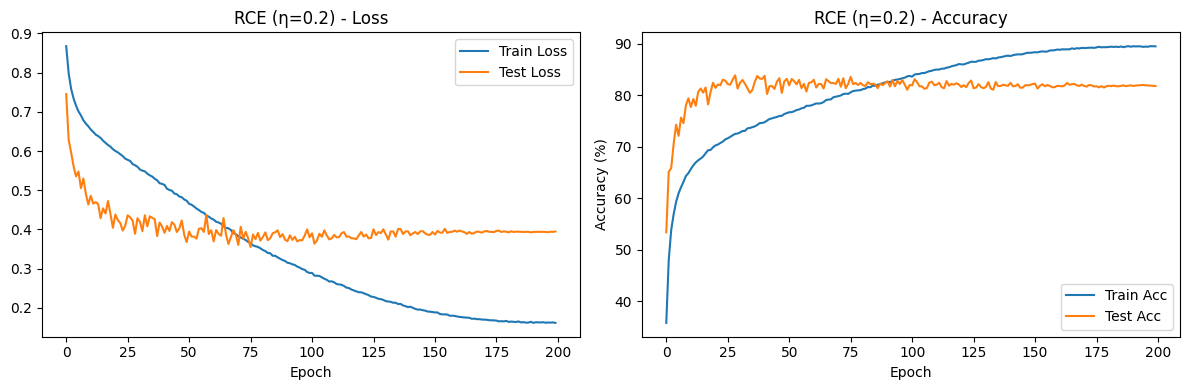


Training normalized Losses...
 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 38.46% | Test Loss: 0.0965


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 46.20% | Test Loss: 0.0891


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 53.11% | Test Loss: 0.0831


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 57.87% | Test Loss: 0.0784


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 57.47% | Test Loss: 0.0771


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 62.67% | Test Loss: 0.0722


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 60.57% | Test Loss: 0.0733


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 64.63% | Test Loss: 0.0693


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 64.78% | Test Loss: 0.0686


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 70.16% | Test Loss: 0.0632


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 70.26% | Test Loss: 0.0624


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 70.63% | Test Loss: 0.0630


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 71.83% | Test Loss: 0.0608


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 72.76% | Test Loss: 0.0594


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 73.11% | Test Loss: 0.0587


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 74.35% | Test Loss: 0.0570


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 75.38% | Test Loss: 0.0563


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 74.22% | Test Loss: 0.0568


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 76.09% | Test Loss: 0.0551


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 74.55% | Test Loss: 0.0566


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 75.80% | Test Loss: 0.0546


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 75.65% | Test Loss: 0.0551


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 76.08% | Test Loss: 0.0547


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 77.57% | Test Loss: 0.0530


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 76.68% | Test Loss: 0.0530


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 75.16% | Test Loss: 0.0566


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 77.28% | Test Loss: 0.0526


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 78.19% | Test Loss: 0.0510


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 78.05% | Test Loss: 0.0531


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 79.19% | Test Loss: 0.0509


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 77.24% | Test Loss: 0.0538


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 78.13% | Test Loss: 0.0517


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 79.30% | Test Loss: 0.0514


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 78.79% | Test Loss: 0.0511


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 79.12% | Test Loss: 0.0491


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 79.17% | Test Loss: 0.0501


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 79.58% | Test Loss: 0.0487


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 79.10% | Test Loss: 0.0490


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 79.92% | Test Loss: 0.0484


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 80.47% | Test Loss: 0.0483


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 79.50% | Test Loss: 0.0498


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 80.50% | Test Loss: 0.0479


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 78.51% | Test Loss: 0.0496


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 78.61% | Test Loss: 0.0501


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 80.63% | Test Loss: 0.0481


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 78.22% | Test Loss: 0.0508


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 80.62% | Test Loss: 0.0478


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 80.33% | Test Loss: 0.0493


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 80.90% | Test Loss: 0.0480


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 80.96% | Test Loss: 0.0470


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 80.24% | Test Loss: 0.0479


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 80.68% | Test Loss: 0.0470


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 80.76% | Test Loss: 0.0468


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.63% | Test Loss: 0.0457


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 80.69% | Test Loss: 0.0474


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 81.08% | Test Loss: 0.0459


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 76.92% | Test Loss: 0.0524


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 81.93% | Test Loss: 0.0456


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 81.28% | Test Loss: 0.0472


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 81.76% | Test Loss: 0.0455


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 81.02% | Test Loss: 0.0464


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 79.80% | Test Loss: 0.0475


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 81.22% | Test Loss: 0.0461


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 80.94% | Test Loss: 0.0461


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 80.75% | Test Loss: 0.0473


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 82.27% | Test Loss: 0.0443


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 81.05% | Test Loss: 0.0463


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.67% | Test Loss: 0.0450


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 81.47% | Test Loss: 0.0458


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 80.38% | Test Loss: 0.0474


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 79.31% | Test Loss: 0.0485


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 79.02% | Test Loss: 0.0485


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.83% | Test Loss: 0.0438


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 80.16% | Test Loss: 0.0460


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 80.03% | Test Loss: 0.0475


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 80.75% | Test Loss: 0.0464


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 80.13% | Test Loss: 0.0467


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 82.48% | Test Loss: 0.0437


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 81.02% | Test Loss: 0.0455


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 80.57% | Test Loss: 0.0470


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 80.70% | Test Loss: 0.0461


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 81.11% | Test Loss: 0.0451


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 81.45% | Test Loss: 0.0448


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 81.12% | Test Loss: 0.0458


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 80.47% | Test Loss: 0.0461


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 81.16% | Test Loss: 0.0447


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 80.16% | Test Loss: 0.0460


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 81.73% | Test Loss: 0.0436


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 81.26% | Test Loss: 0.0442


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.09% | Test Loss: 0.0444


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.54% | Test Loss: 0.0433


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 81.02% | Test Loss: 0.0451


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.32% | Test Loss: 0.0438


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 79.56% | Test Loss: 0.0472


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 80.11% | Test Loss: 0.0468


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 81.95% | Test Loss: 0.0430


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 82.34% | Test Loss: 0.0419


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.02% | Test Loss: 0.0439


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 81.43% | Test Loss: 0.0440


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 80.11% | Test Loss: 0.0468


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 78.96% | Test Loss: 0.0472


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 81.68% | Test Loss: 0.0435


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 81.07% | Test Loss: 0.0444


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 82.09% | Test Loss: 0.0430


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 77.03% | Test Loss: 0.0510


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 81.10% | Test Loss: 0.0440


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 81.70% | Test Loss: 0.0437


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 80.26% | Test Loss: 0.0451


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 81.94% | Test Loss: 0.0428


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.81% | Test Loss: 0.0432


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 78.73% | Test Loss: 0.0483


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 81.44% | Test Loss: 0.0431


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.93% | Test Loss: 0.0418


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.03% | Test Loss: 0.0445


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.70% | Test Loss: 0.0430


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 81.22% | Test Loss: 0.0439


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 80.20% | Test Loss: 0.0451


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 81.80% | Test Loss: 0.0425


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.75it/s]


Test Acc: 81.61% | Test Loss: 0.0435


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 79.98% | Test Loss: 0.0456


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 81.52% | Test Loss: 0.0425


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 81.15% | Test Loss: 0.0438


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 81.67% | Test Loss: 0.0434


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 81.12% | Test Loss: 0.0439


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 82.25% | Test Loss: 0.0420


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 79.58% | Test Loss: 0.0469


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 80.55% | Test Loss: 0.0450


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.17% | Test Loss: 0.0434


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 81.65% | Test Loss: 0.0427


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 80.70% | Test Loss: 0.0436


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 81.30% | Test Loss: 0.0429


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 80.62% | Test Loss: 0.0448


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 80.91% | Test Loss: 0.0437


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 81.24% | Test Loss: 0.0430


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 80.66% | Test Loss: 0.0439


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 81.29% | Test Loss: 0.0438


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 81.08% | Test Loss: 0.0436


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.02% | Test Loss: 0.0437


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 81.65% | Test Loss: 0.0422


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 80.90% | Test Loss: 0.0435


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 81.26% | Test Loss: 0.0431


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 81.49% | Test Loss: 0.0429


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 81.16% | Test Loss: 0.0431


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.34% | Test Loss: 0.0425


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 81.37% | Test Loss: 0.0430


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 81.82% | Test Loss: 0.0424


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 81.59% | Test Loss: 0.0426


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.32% | Test Loss: 0.0427


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 81.19% | Test Loss: 0.0429


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 80.98% | Test Loss: 0.0433


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 81.72% | Test Loss: 0.0419


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 81.71% | Test Loss: 0.0422


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.85% | Test Loss: 0.0424


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.68% | Test Loss: 0.0423


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 81.42% | Test Loss: 0.0428


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.61% | Test Loss: 0.0428


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 81.90% | Test Loss: 0.0426


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 81.55% | Test Loss: 0.0428


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 81.64% | Test Loss: 0.0421


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.95% | Test Loss: 0.0417


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.25% | Test Loss: 0.0433


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 81.28% | Test Loss: 0.0434


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 81.45% | Test Loss: 0.0426


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 81.93% | Test Loss: 0.0422


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 81.71% | Test Loss: 0.0421


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 81.71% | Test Loss: 0.0422


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.34% | Test Loss: 0.0425


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 81.70% | Test Loss: 0.0419


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.88% | Test Loss: 0.0418


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 81.70% | Test Loss: 0.0423


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 82.29% | Test Loss: 0.0416


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 81.75% | Test Loss: 0.0415


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 82.22% | Test Loss: 0.0418


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.90% | Test Loss: 0.0421


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 81.75% | Test Loss: 0.0421


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 82.02% | Test Loss: 0.0421


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 82.05% | Test Loss: 0.0416


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 81.90% | Test Loss: 0.0415


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 81.96% | Test Loss: 0.0420


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 82.16% | Test Loss: 0.0418


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 82.11% | Test Loss: 0.0418


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 82.27% | Test Loss: 0.0416


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.90% | Test Loss: 0.0418


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.97% | Test Loss: 0.0419


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 82.02% | Test Loss: 0.0417


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 82.01% | Test Loss: 0.0416


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 81.99% | Test Loss: 0.0416


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 81.92% | Test Loss: 0.0417


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.96% | Test Loss: 0.0417


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 82.00% | Test Loss: 0.0417


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 82.07% | Test Loss: 0.0416


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 82.01% | Test Loss: 0.0417


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 82.01% | Test Loss: 0.0418


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.95% | Test Loss: 0.0417


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 82.01% | Test Loss: 0.0417


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 82.04% | Test Loss: 0.0417


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 82.10% | Test Loss: 0.0417


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 82.04% | Test Loss: 0.0417


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 82.07% | Test Loss: 0.0417


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 81.88% | Test Loss: 0.0417


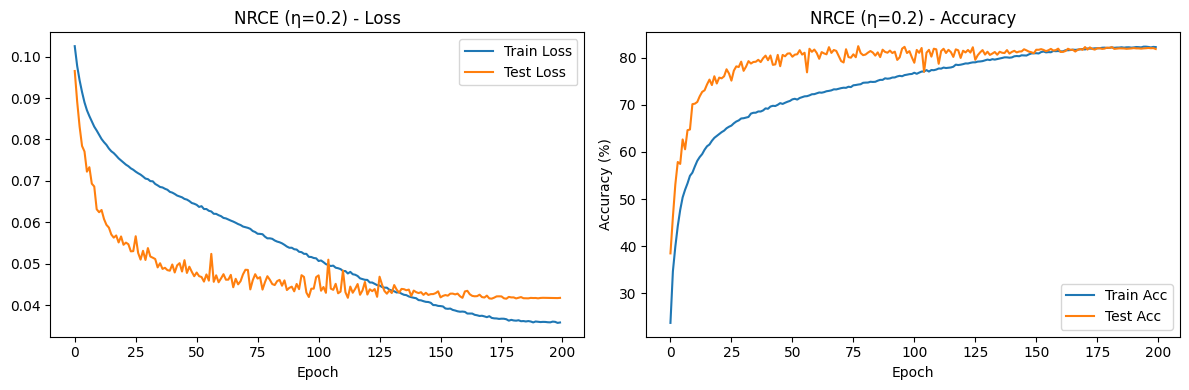


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 54.51% | Test Loss: 0.7575


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 64.48% | Test Loss: 0.6688


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 67.43% | Test Loss: 0.6287


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 71.17% | Test Loss: 0.5833


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 72.75% | Test Loss: 0.5744


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 74.64% | Test Loss: 0.5222


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 73.69% | Test Loss: 0.5302


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 76.81% | Test Loss: 0.5161


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 77.03% | Test Loss: 0.4993


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 76.82% | Test Loss: 0.4953


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 76.31% | Test Loss: 0.5207


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 76.02% | Test Loss: 0.5163


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 79.77% | Test Loss: 0.4582


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 77.16% | Test Loss: 0.5010


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 80.80% | Test Loss: 0.4564


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 80.28% | Test Loss: 0.4810


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 79.33% | Test Loss: 0.4681


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 81.71% | Test Loss: 0.4620


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 80.51% | Test Loss: 0.4588


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.13% | Test Loss: 0.4491


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 80.43% | Test Loss: 0.4476


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 82.59% | Test Loss: 0.4388


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 83.33% | Test Loss: 0.4186


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 81.98% | Test Loss: 0.4433


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 82.29% | Test Loss: 0.4253


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 81.75% | Test Loss: 0.4116


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 82.51% | Test Loss: 0.4373


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 80.44% | Test Loss: 0.4285


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 81.66% | Test Loss: 0.4294


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 82.93% | Test Loss: 0.4139


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 82.80% | Test Loss: 0.4044


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 80.92% | Test Loss: 0.4360


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 83.16% | Test Loss: 0.4197


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 83.73% | Test Loss: 0.3896


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 82.40% | Test Loss: 0.4083


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 82.07% | Test Loss: 0.4369


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 83.96% | Test Loss: 0.3923


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 84.22% | Test Loss: 0.3725


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 82.48% | Test Loss: 0.4175


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 83.57% | Test Loss: 0.3939


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 84.18% | Test Loss: 0.3826


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 83.38% | Test Loss: 0.4111


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 83.94% | Test Loss: 0.3893


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 83.69% | Test Loss: 0.4124


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 83.70% | Test Loss: 0.3949


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 84.72% | Test Loss: 0.3787


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.92% | Test Loss: 0.3892


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 82.98% | Test Loss: 0.3889


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 84.43% | Test Loss: 0.3644


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 83.42% | Test Loss: 0.3734


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 83.21% | Test Loss: 0.3760


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 83.59% | Test Loss: 0.3831


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 82.49% | Test Loss: 0.3978


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.55% | Test Loss: 0.4065


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 83.40% | Test Loss: 0.3835


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 83.79% | Test Loss: 0.3889


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 82.91% | Test Loss: 0.3979


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 84.12% | Test Loss: 0.3696


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 82.62% | Test Loss: 0.4094


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 83.48% | Test Loss: 0.3879


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 82.50% | Test Loss: 0.3907


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 83.99% | Test Loss: 0.3545


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 83.18% | Test Loss: 0.3788


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 80.97% | Test Loss: 0.4194


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 82.70% | Test Loss: 0.3850


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 83.67% | Test Loss: 0.3770


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 82.52% | Test Loss: 0.3917


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 83.85% | Test Loss: 0.3724


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 82.90% | Test Loss: 0.3749


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 81.92% | Test Loss: 0.3989


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 83.49% | Test Loss: 0.3746


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 83.34% | Test Loss: 0.3787


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 82.88% | Test Loss: 0.3959


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 82.94% | Test Loss: 0.3790


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 82.33% | Test Loss: 0.3993


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 83.29% | Test Loss: 0.3761


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 83.50% | Test Loss: 0.3694


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 84.04% | Test Loss: 0.3659


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.74% | Test Loss: 0.3658


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 82.62% | Test Loss: 0.3824


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 82.41% | Test Loss: 0.4029


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 83.18% | Test Loss: 0.3728


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 83.69% | Test Loss: 0.3679


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.14% | Test Loss: 0.3826


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 82.23% | Test Loss: 0.3914


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.96% | Test Loss: 0.4043


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 82.60% | Test Loss: 0.3850


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 81.95% | Test Loss: 0.4031


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 82.54% | Test Loss: 0.3843


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 83.23% | Test Loss: 0.3667


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.61% | Test Loss: 0.3827


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 82.15% | Test Loss: 0.3896


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 83.66% | Test Loss: 0.3768


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 81.89% | Test Loss: 0.4109


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 82.95% | Test Loss: 0.3765


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 83.65% | Test Loss: 0.3610


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 83.39% | Test Loss: 0.3772


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 82.12% | Test Loss: 0.3920


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 82.87% | Test Loss: 0.3832


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 81.31% | Test Loss: 0.4074


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 82.99% | Test Loss: 0.3829


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 83.07% | Test Loss: 0.3818


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 82.45% | Test Loss: 0.3880


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 82.18% | Test Loss: 0.3933


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 83.07% | Test Loss: 0.3753


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 82.22% | Test Loss: 0.3937


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 81.95% | Test Loss: 0.4070


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 82.64% | Test Loss: 0.3897


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 82.48% | Test Loss: 0.3896


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 83.05% | Test Loss: 0.3819


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 82.67% | Test Loss: 0.3826


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.08% | Test Loss: 0.4117


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 81.45% | Test Loss: 0.4050


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 82.58% | Test Loss: 0.3889


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 82.47% | Test Loss: 0.3881


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 82.41% | Test Loss: 0.3867


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 80.87% | Test Loss: 0.4127


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 82.63% | Test Loss: 0.3860


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 82.38% | Test Loss: 0.3896


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 82.22% | Test Loss: 0.3917


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 82.03% | Test Loss: 0.4008


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 82.09% | Test Loss: 0.3929


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 82.13% | Test Loss: 0.4012


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 81.75% | Test Loss: 0.4009


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 81.62% | Test Loss: 0.4016


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 82.17% | Test Loss: 0.3867


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 82.12% | Test Loss: 0.3990


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 82.75% | Test Loss: 0.3921


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 82.30% | Test Loss: 0.3915


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 82.50% | Test Loss: 0.3958


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 81.89% | Test Loss: 0.3965


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 82.60% | Test Loss: 0.3930


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 82.51% | Test Loss: 0.3847


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 82.40% | Test Loss: 0.3935


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 82.19% | Test Loss: 0.3942


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 82.31% | Test Loss: 0.3962


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 81.99% | Test Loss: 0.3992


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 82.51% | Test Loss: 0.3891


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 82.10% | Test Loss: 0.3966


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.65it/s]


Test Acc: 81.55% | Test Loss: 0.4020


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 82.10% | Test Loss: 0.3968


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 81.91% | Test Loss: 0.3989


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 82.14% | Test Loss: 0.4001


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 81.86% | Test Loss: 0.4015


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 82.49% | Test Loss: 0.3935


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 82.30% | Test Loss: 0.3993


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 82.67% | Test Loss: 0.3920


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 82.62% | Test Loss: 0.3930


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 82.76% | Test Loss: 0.3928


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 82.32% | Test Loss: 0.3966


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 82.05% | Test Loss: 0.4026


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 82.57% | Test Loss: 0.3896


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 82.44% | Test Loss: 0.3983


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.62% | Test Loss: 0.3934


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 82.58% | Test Loss: 0.3930


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 82.49% | Test Loss: 0.3942


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 82.03% | Test Loss: 0.4010


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 82.35% | Test Loss: 0.3977


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 82.69% | Test Loss: 0.3927


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 82.12% | Test Loss: 0.3998


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.15% | Test Loss: 0.4003


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 82.07% | Test Loss: 0.3992


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 81.86% | Test Loss: 0.4044


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 82.14% | Test Loss: 0.4014


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 82.30% | Test Loss: 0.4034


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 82.19% | Test Loss: 0.4048


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 82.27% | Test Loss: 0.4007


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 81.97% | Test Loss: 0.4004


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 82.20% | Test Loss: 0.3996


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 82.46% | Test Loss: 0.4000


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 82.29% | Test Loss: 0.3989


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 82.15% | Test Loss: 0.4030


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.30% | Test Loss: 0.3999


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 82.44% | Test Loss: 0.4002


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 82.39% | Test Loss: 0.4035


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 82.40% | Test Loss: 0.4000


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 82.37% | Test Loss: 0.4017


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 82.02% | Test Loss: 0.4028


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 82.20% | Test Loss: 0.4023


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 82.01% | Test Loss: 0.4015


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 82.28% | Test Loss: 0.4010


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 82.07% | Test Loss: 0.4032


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 82.19% | Test Loss: 0.4023


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 82.14% | Test Loss: 0.4013


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 82.29% | Test Loss: 0.4026


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 82.10% | Test Loss: 0.4027


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 82.02% | Test Loss: 0.4033


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 82.11% | Test Loss: 0.4017


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 82.16% | Test Loss: 0.4024


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 82.12% | Test Loss: 0.4021


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 82.03% | Test Loss: 0.4027


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 81.98% | Test Loss: 0.4026


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 82.26% | Test Loss: 0.4023


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 82.20% | Test Loss: 0.4022


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 82.13% | Test Loss: 0.4023


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 82.22% | Test Loss: 0.4016


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 82.11% | Test Loss: 0.4032


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 82.16% | Test Loss: 0.4032


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 82.26% | Test Loss: 0.4023


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 82.13% | Test Loss: 0.4030


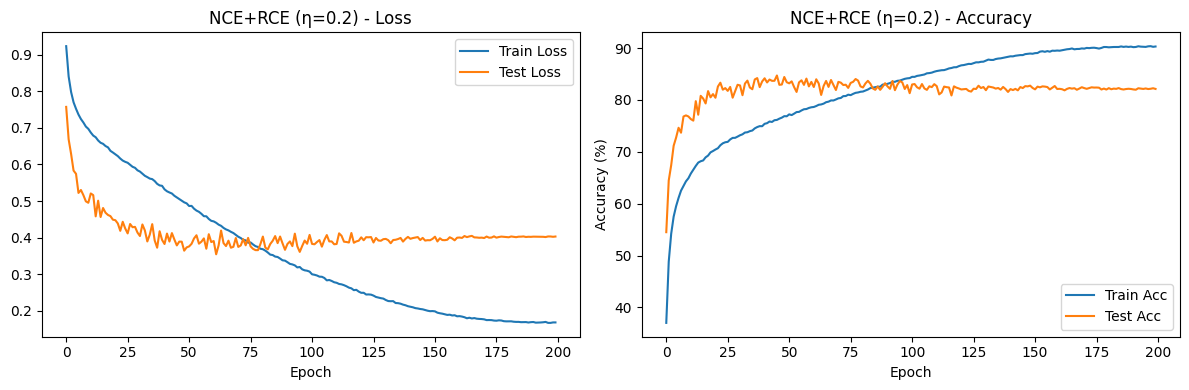

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 55.14% | Test Loss: 0.7494


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 60.99% | Test Loss: 0.6897


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 65.42% | Test Loss: 0.6503


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 68.52% | Test Loss: 0.6085


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 70.69% | Test Loss: 0.5672


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 73.70% | Test Loss: 0.5347


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 74.10% | Test Loss: 0.5443


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 76.92% | Test Loss: 0.5348


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 77.11% | Test Loss: 0.4976


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 77.15% | Test Loss: 0.4875


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 79.39% | Test Loss: 0.4749


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 77.63% | Test Loss: 0.5018


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 79.90% | Test Loss: 0.4501


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 79.19% | Test Loss: 0.4718


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 79.27% | Test Loss: 0.4635


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 79.78% | Test Loss: 0.4666


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 81.60% | Test Loss: 0.4276


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 80.98% | Test Loss: 0.4503


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 81.28% | Test Loss: 0.4253


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 82.04% | Test Loss: 0.4382


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 80.96% | Test Loss: 0.4687


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 77.32% | Test Loss: 0.4871


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 80.92% | Test Loss: 0.4546


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 82.01% | Test Loss: 0.4494


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 83.14% | Test Loss: 0.4337


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 82.03% | Test Loss: 0.4421


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.13% | Test Loss: 0.4123


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 80.32% | Test Loss: 0.4281


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 81.45% | Test Loss: 0.4405


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 83.14% | Test Loss: 0.4086


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 81.49% | Test Loss: 0.4387


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 81.13% | Test Loss: 0.4374


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 81.47% | Test Loss: 0.4141


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 82.63% | Test Loss: 0.4210


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 82.75% | Test Loss: 0.4010


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 82.99% | Test Loss: 0.4029


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 82.39% | Test Loss: 0.4079


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 83.54% | Test Loss: 0.4079


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 81.85% | Test Loss: 0.4396


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 83.85% | Test Loss: 0.4016


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 82.72% | Test Loss: 0.4048


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 81.51% | Test Loss: 0.4234


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 83.56% | Test Loss: 0.3727


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 80.30% | Test Loss: 0.4339


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 82.60% | Test Loss: 0.4008


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 83.50% | Test Loss: 0.3901


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 81.81% | Test Loss: 0.3963


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.45% | Test Loss: 0.4099


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 82.20% | Test Loss: 0.4055


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 82.16% | Test Loss: 0.4071


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 83.51% | Test Loss: 0.3753


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 82.46% | Test Loss: 0.4038


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 81.38% | Test Loss: 0.4319


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 83.21% | Test Loss: 0.4025


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 82.17% | Test Loss: 0.4030


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 81.84% | Test Loss: 0.4164


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 83.09% | Test Loss: 0.3837


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 83.48% | Test Loss: 0.3717


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 82.41% | Test Loss: 0.4117


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 81.74% | Test Loss: 0.4067


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 82.33% | Test Loss: 0.3839


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 83.69% | Test Loss: 0.3735


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 83.43% | Test Loss: 0.3687


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 82.69% | Test Loss: 0.3849


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 82.59% | Test Loss: 0.3899


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 82.51% | Test Loss: 0.3896


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 81.27% | Test Loss: 0.4026


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 81.21% | Test Loss: 0.4273


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 83.21% | Test Loss: 0.3898


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 82.46% | Test Loss: 0.3892


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 82.44% | Test Loss: 0.4044


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 83.67% | Test Loss: 0.3683


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 82.68% | Test Loss: 0.3799


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 83.29% | Test Loss: 0.3678


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 82.72% | Test Loss: 0.3869


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 83.49% | Test Loss: 0.3680


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 82.79% | Test Loss: 0.3736


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 83.59% | Test Loss: 0.3621


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 81.60% | Test Loss: 0.3996


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 81.98% | Test Loss: 0.3885


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 83.44% | Test Loss: 0.3682


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 81.99% | Test Loss: 0.3972


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 83.54% | Test Loss: 0.3580


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 81.25% | Test Loss: 0.4118


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 82.38% | Test Loss: 0.3885


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 82.90% | Test Loss: 0.3707


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 83.26% | Test Loss: 0.3647


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 82.54% | Test Loss: 0.3824


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 82.51% | Test Loss: 0.3830


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 82.76% | Test Loss: 0.3738


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 81.96% | Test Loss: 0.3884


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 82.81% | Test Loss: 0.3788


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 82.31% | Test Loss: 0.3850


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 82.74% | Test Loss: 0.3796


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 83.37% | Test Loss: 0.3729


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.69% | Test Loss: 0.3852


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 82.15% | Test Loss: 0.3899


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 83.00% | Test Loss: 0.3872


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 81.58% | Test Loss: 0.4061


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 82.61% | Test Loss: 0.3777


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 83.29% | Test Loss: 0.3711


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 82.61% | Test Loss: 0.3778


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 82.32% | Test Loss: 0.3858


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 82.50% | Test Loss: 0.3810


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 82.02% | Test Loss: 0.3916


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 82.66% | Test Loss: 0.3739


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.43% | Test Loss: 0.4021


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 81.72% | Test Loss: 0.4015


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 82.74% | Test Loss: 0.3806


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 82.32% | Test Loss: 0.3896


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 82.59% | Test Loss: 0.3849


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 83.42% | Test Loss: 0.3699


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 82.59% | Test Loss: 0.3870


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 82.00% | Test Loss: 0.3931


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.94% | Test Loss: 0.3958


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 81.46% | Test Loss: 0.4021


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 82.28% | Test Loss: 0.3964


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 81.43% | Test Loss: 0.4005


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 81.70% | Test Loss: 0.3996


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 81.85% | Test Loss: 0.4016


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 82.23% | Test Loss: 0.3879


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 81.72% | Test Loss: 0.3982


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 81.80% | Test Loss: 0.3977


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 81.53% | Test Loss: 0.4002


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 81.50% | Test Loss: 0.4020


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.14% | Test Loss: 0.3973


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 82.57% | Test Loss: 0.3965


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 82.13% | Test Loss: 0.3959


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 81.77% | Test Loss: 0.3967


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 82.07% | Test Loss: 0.3974


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 81.27% | Test Loss: 0.4089


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 82.37% | Test Loss: 0.3903


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.33% | Test Loss: 0.4035


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.92% | Test Loss: 0.4053


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 81.94% | Test Loss: 0.4045


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 82.11% | Test Loss: 0.3950


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 82.41% | Test Loss: 0.3878


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 81.27% | Test Loss: 0.4092


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 82.28% | Test Loss: 0.3931


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 82.09% | Test Loss: 0.4063


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 81.96% | Test Loss: 0.4021


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.18% | Test Loss: 0.4067


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 81.93% | Test Loss: 0.4004


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 82.74% | Test Loss: 0.3898


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 81.37% | Test Loss: 0.4056


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.26% | Test Loss: 0.4100


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 81.71% | Test Loss: 0.4001


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.08% | Test Loss: 0.3998


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 81.83% | Test Loss: 0.4059


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 81.47% | Test Loss: 0.4138


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 81.73% | Test Loss: 0.4081


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 82.61% | Test Loss: 0.4024


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 82.23% | Test Loss: 0.4056


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 82.31% | Test Loss: 0.4046


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 82.26% | Test Loss: 0.4002


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 82.00% | Test Loss: 0.4033


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 81.26% | Test Loss: 0.4106


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 82.00% | Test Loss: 0.4057


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 81.76% | Test Loss: 0.4077


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 81.37% | Test Loss: 0.4108


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 81.75% | Test Loss: 0.4072


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 81.68% | Test Loss: 0.4064


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 81.66% | Test Loss: 0.4106


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 81.82% | Test Loss: 0.4113


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.97% | Test Loss: 0.4096


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 82.12% | Test Loss: 0.4078


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 81.69% | Test Loss: 0.4130


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.89% | Test Loss: 0.4116


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 81.95% | Test Loss: 0.4105


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 82.26% | Test Loss: 0.4094


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 81.53% | Test Loss: 0.4159


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 81.92% | Test Loss: 0.4129


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 81.83% | Test Loss: 0.4129


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 81.65% | Test Loss: 0.4140


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 81.65% | Test Loss: 0.4128


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 81.58% | Test Loss: 0.4146


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 81.35% | Test Loss: 0.4152


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.57% | Test Loss: 0.4134


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 81.61% | Test Loss: 0.4119


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 81.70% | Test Loss: 0.4118


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 81.52% | Test Loss: 0.4126


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 81.72% | Test Loss: 0.4129


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 81.83% | Test Loss: 0.4110


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 81.89% | Test Loss: 0.4097


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 81.87% | Test Loss: 0.4107


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 81.94% | Test Loss: 0.4083


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.84% | Test Loss: 0.4106


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 81.94% | Test Loss: 0.4103


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 81.76% | Test Loss: 0.4120


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 81.85% | Test Loss: 0.4115


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 81.88% | Test Loss: 0.4108


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 81.79% | Test Loss: 0.4121


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 81.75% | Test Loss: 0.4130


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.63% | Test Loss: 0.4122


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 81.90% | Test Loss: 0.4118


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.85% | Test Loss: 0.4120


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 81.78% | Test Loss: 0.4113


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 81.81% | Test Loss: 0.4122


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.79% | Test Loss: 0.4124


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 81.84% | Test Loss: 0.4121


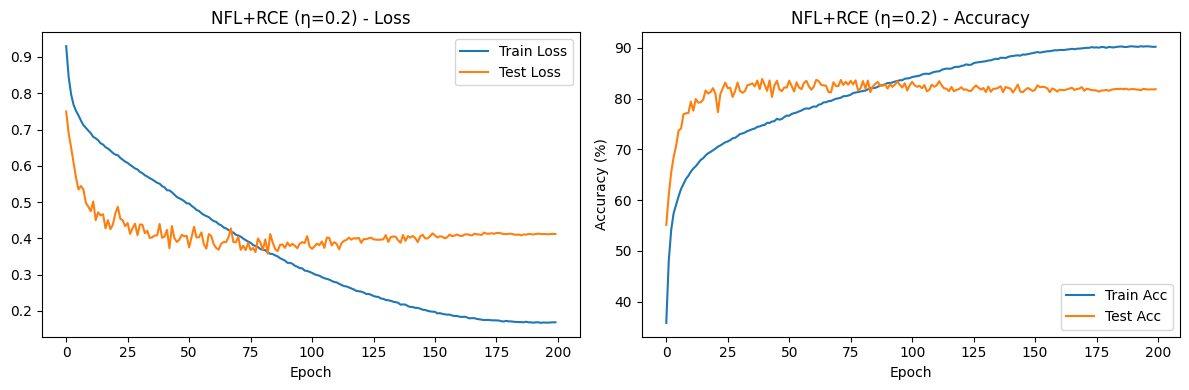

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 57.38% | Test Loss: 1.2409


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 63.08% | Test Loss: 1.1229


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 65.51% | Test Loss: 1.0479


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 71.03% | Test Loss: 0.9357


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 75.58% | Test Loss: 0.8441


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 74.66% | Test Loss: 0.8506


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 72.50% | Test Loss: 0.8976


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 75.11% | Test Loss: 0.8414


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 78.59% | Test Loss: 0.7863


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 79.39% | Test Loss: 0.7318


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 78.98% | Test Loss: 0.7510


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.00% | Test Loss: 0.6963


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 79.74% | Test Loss: 0.7271


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 81.02% | Test Loss: 0.7062


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 82.72% | Test Loss: 0.6603


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.34% | Test Loss: 0.6573


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 83.13% | Test Loss: 0.6335


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.26% | Test Loss: 0.6965


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.41% | Test Loss: 0.6883


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 81.82% | Test Loss: 0.6814


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 80.12% | Test Loss: 0.7096


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 83.58% | Test Loss: 0.6571


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 83.87% | Test Loss: 0.6257


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 83.79% | Test Loss: 0.6405


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 84.50% | Test Loss: 0.6086


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 84.06% | Test Loss: 0.6280


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 83.79% | Test Loss: 0.6348


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 83.44% | Test Loss: 0.6451


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 85.00% | Test Loss: 0.6355


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 85.40% | Test Loss: 0.5617


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 84.56% | Test Loss: 0.6165


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 85.02% | Test Loss: 0.5745


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 84.90% | Test Loss: 0.5816


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 84.18% | Test Loss: 0.6089


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 86.00% | Test Loss: 0.5500


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.70% | Test Loss: 0.6149


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 84.11% | Test Loss: 0.5838


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 85.23% | Test Loss: 0.5966


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 84.96% | Test Loss: 0.6005


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 85.35% | Test Loss: 0.5842


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 86.33% | Test Loss: 0.5395


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 85.33% | Test Loss: 0.5485


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 83.07% | Test Loss: 0.6247


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 83.85% | Test Loss: 0.6101


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 84.91% | Test Loss: 0.5904


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 84.72% | Test Loss: 0.5911


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 83.95% | Test Loss: 0.5900


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 84.77% | Test Loss: 0.5628


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 85.14% | Test Loss: 0.5520


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 86.27% | Test Loss: 0.5403


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 84.34% | Test Loss: 0.5910


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 84.26% | Test Loss: 0.5855


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 85.56% | Test Loss: 0.5485


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 85.28% | Test Loss: 0.5724


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 84.29% | Test Loss: 0.5660


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 84.72% | Test Loss: 0.5887


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 84.68% | Test Loss: 0.5609


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 85.06% | Test Loss: 0.5664


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 84.25% | Test Loss: 0.5933


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 83.66% | Test Loss: 0.6114


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 84.00% | Test Loss: 0.6015


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 84.99% | Test Loss: 0.5521


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 84.01% | Test Loss: 0.5904


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 83.91% | Test Loss: 0.5929


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 85.03% | Test Loss: 0.5533


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 84.86% | Test Loss: 0.5600


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 83.84% | Test Loss: 0.5988


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 84.31% | Test Loss: 0.5737


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 84.35% | Test Loss: 0.5786


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 83.19% | Test Loss: 0.6171


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 83.80% | Test Loss: 0.5768


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 83.08% | Test Loss: 0.6237


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 83.67% | Test Loss: 0.5987


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 84.18% | Test Loss: 0.5746


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 83.89% | Test Loss: 0.5867


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.20% | Test Loss: 0.6076


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 84.05% | Test Loss: 0.5736


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 84.74% | Test Loss: 0.5646


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 84.00% | Test Loss: 0.5811


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 84.13% | Test Loss: 0.5874


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 84.63% | Test Loss: 0.5630


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 83.70% | Test Loss: 0.5776


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 83.20% | Test Loss: 0.6181


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 83.47% | Test Loss: 0.6024


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 83.56% | Test Loss: 0.5982


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 83.03% | Test Loss: 0.6198


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 84.61% | Test Loss: 0.5657


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 82.92% | Test Loss: 0.6175


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 83.51% | Test Loss: 0.5943


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 83.75% | Test Loss: 0.5822


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 83.71% | Test Loss: 0.5917


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 84.13% | Test Loss: 0.5790


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 83.63% | Test Loss: 0.5811


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 83.75% | Test Loss: 0.5875


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 82.77% | Test Loss: 0.6023


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 83.44% | Test Loss: 0.5816


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 82.80% | Test Loss: 0.6083


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 83.20% | Test Loss: 0.6071


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 83.03% | Test Loss: 0.6086


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 83.49% | Test Loss: 0.5949


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 83.63% | Test Loss: 0.5976


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 84.15% | Test Loss: 0.5757


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 84.14% | Test Loss: 0.5834


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 83.30% | Test Loss: 0.5955


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 84.17% | Test Loss: 0.5803


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 83.25% | Test Loss: 0.6017


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 84.08% | Test Loss: 0.5859


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 83.60% | Test Loss: 0.5794


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 83.51% | Test Loss: 0.5987


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.96% | Test Loss: 0.6068


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 84.30% | Test Loss: 0.5793


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 83.53% | Test Loss: 0.6060


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 83.38% | Test Loss: 0.6091


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 83.60% | Test Loss: 0.5982


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 83.57% | Test Loss: 0.5938


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 84.11% | Test Loss: 0.5853


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 83.86% | Test Loss: 0.5856


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 82.80% | Test Loss: 0.6057


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 83.63% | Test Loss: 0.5876


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.75% | Test Loss: 0.5876


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 83.42% | Test Loss: 0.5951


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 83.63% | Test Loss: 0.5791


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 83.58% | Test Loss: 0.6013


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 83.88% | Test Loss: 0.5754


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 83.96% | Test Loss: 0.5923


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 84.02% | Test Loss: 0.5819


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 83.57% | Test Loss: 0.5936


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 83.74% | Test Loss: 0.5875


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 83.81% | Test Loss: 0.5907


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 83.70% | Test Loss: 0.5876


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 83.18% | Test Loss: 0.6020


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 84.28% | Test Loss: 0.5769


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 83.70% | Test Loss: 0.5882


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 83.77% | Test Loss: 0.5914


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 83.39% | Test Loss: 0.5861


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 84.05% | Test Loss: 0.5857


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 83.91% | Test Loss: 0.5900


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 83.47% | Test Loss: 0.5940


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 83.45% | Test Loss: 0.6034


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 83.36% | Test Loss: 0.6044


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 83.53% | Test Loss: 0.5994


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 82.99% | Test Loss: 0.6022


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 83.25% | Test Loss: 0.5960


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 83.74% | Test Loss: 0.5917


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 83.44% | Test Loss: 0.5926


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 83.22% | Test Loss: 0.6055


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 83.18% | Test Loss: 0.5969


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 83.17% | Test Loss: 0.6062


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 83.57% | Test Loss: 0.6044


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 83.21% | Test Loss: 0.6028


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 83.56% | Test Loss: 0.5921


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 83.47% | Test Loss: 0.5952


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 83.21% | Test Loss: 0.6008


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 83.56% | Test Loss: 0.5964


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 83.89% | Test Loss: 0.5962


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 83.79% | Test Loss: 0.5952


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 83.46% | Test Loss: 0.6021


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 83.13% | Test Loss: 0.6089


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 83.45% | Test Loss: 0.6060


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.23% | Test Loss: 0.6097


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 83.47% | Test Loss: 0.6012


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 83.38% | Test Loss: 0.6040


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 83.79% | Test Loss: 0.6004


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 83.69% | Test Loss: 0.5964


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 83.60% | Test Loss: 0.5975


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 83.41% | Test Loss: 0.6021


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 83.54% | Test Loss: 0.6006


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 83.67% | Test Loss: 0.6055


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 83.49% | Test Loss: 0.6041


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 83.50% | Test Loss: 0.6046


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.45% | Test Loss: 0.6038


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 83.70% | Test Loss: 0.6024


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 83.75% | Test Loss: 0.6009


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 83.84% | Test Loss: 0.6024


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 83.56% | Test Loss: 0.6060


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 83.48% | Test Loss: 0.6033


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 83.79% | Test Loss: 0.6005


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 83.53% | Test Loss: 0.6069


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 83.27% | Test Loss: 0.6107


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 83.40% | Test Loss: 0.6077


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 83.44% | Test Loss: 0.6054


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 83.50% | Test Loss: 0.6065


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 83.84% | Test Loss: 0.6021


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 83.45% | Test Loss: 0.6071


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 83.55% | Test Loss: 0.6043


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 83.55% | Test Loss: 0.6053


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 83.43% | Test Loss: 0.6091


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 83.57% | Test Loss: 0.6062


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 83.64% | Test Loss: 0.6049


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 83.49% | Test Loss: 0.6060


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 83.65% | Test Loss: 0.6031


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 83.57% | Test Loss: 0.6052


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 83.51% | Test Loss: 0.6076


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 83.59% | Test Loss: 0.6028


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 83.57% | Test Loss: 0.6054


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 83.50% | Test Loss: 0.6058


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 83.54% | Test Loss: 0.6077


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 83.59% | Test Loss: 0.6052


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 83.61% | Test Loss: 0.6074


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 83.51% | Test Loss: 0.6050


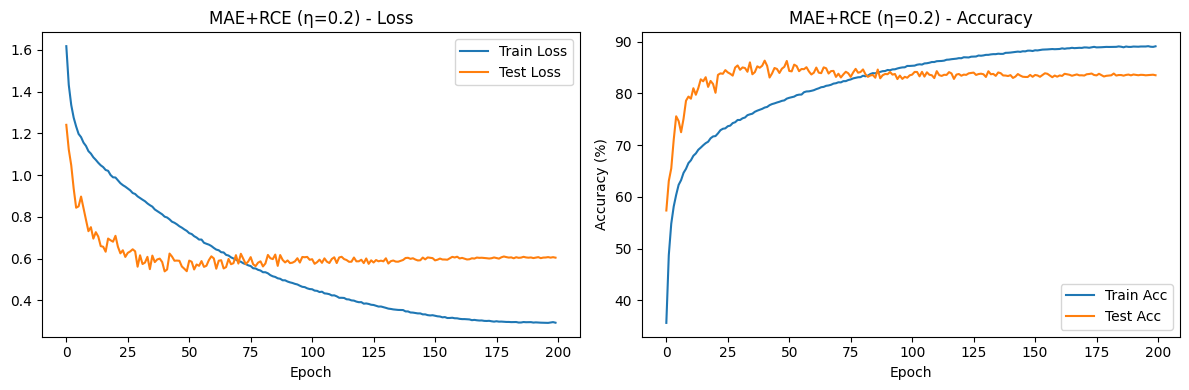


Noise Rate: 0.4

Training vanilla Losses...
 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 49.03% | Test Loss: 0.7958


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 57.63% | Test Loss: 0.7522


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 63.02% | Test Loss: 0.7004


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 66.20% | Test Loss: 0.6522


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 68.34% | Test Loss: 0.6701


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 69.44% | Test Loss: 0.6881


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 69.49% | Test Loss: 0.6633


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 66.71% | Test Loss: 0.6772


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 73.17% | Test Loss: 0.6405


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 75.13% | Test Loss: 0.6233


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 74.74% | Test Loss: 0.5978


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 75.30% | Test Loss: 0.5960


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 77.18% | Test Loss: 0.5927


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 76.12% | Test Loss: 0.6191


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 76.57% | Test Loss: 0.5828


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 73.47% | Test Loss: 0.5697


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 76.72% | Test Loss: 0.5819


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 71.89% | Test Loss: 0.6156


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 76.20% | Test Loss: 0.5770


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 75.16% | Test Loss: 0.6024


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 77.08% | Test Loss: 0.6124


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 78.33% | Test Loss: 0.5717


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 75.60% | Test Loss: 0.5943


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 79.05% | Test Loss: 0.6032


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 78.08% | Test Loss: 0.5883


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 76.34% | Test Loss: 0.5947


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 76.70% | Test Loss: 0.5696


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 76.21% | Test Loss: 0.5624


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 78.38% | Test Loss: 0.5550


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 79.64% | Test Loss: 0.5646


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 77.33% | Test Loss: 0.5753


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 75.79% | Test Loss: 0.5759


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 77.78% | Test Loss: 0.5798


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 79.48% | Test Loss: 0.5405


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 78.09% | Test Loss: 0.5379


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 78.80% | Test Loss: 0.5668


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 78.98% | Test Loss: 0.5322


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 77.73% | Test Loss: 0.5576


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 77.42% | Test Loss: 0.5516


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 78.96% | Test Loss: 0.5454


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 78.39% | Test Loss: 0.5486


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 75.87% | Test Loss: 0.5525


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 78.22% | Test Loss: 0.5605


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 77.10% | Test Loss: 0.5380


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 75.93% | Test Loss: 0.5518


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 77.83% | Test Loss: 0.5444


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 79.18% | Test Loss: 0.4971


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 77.02% | Test Loss: 0.5380


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 75.32% | Test Loss: 0.5362


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 78.41% | Test Loss: 0.5380


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 77.50% | Test Loss: 0.5310


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 78.53% | Test Loss: 0.5498


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 77.10% | Test Loss: 0.5579


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 76.68% | Test Loss: 0.5360


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 79.12% | Test Loss: 0.5036


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 76.98% | Test Loss: 0.5237


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 77.56% | Test Loss: 0.5326


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 75.38% | Test Loss: 0.5593


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 76.67% | Test Loss: 0.5193


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 78.25% | Test Loss: 0.5047


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 75.41% | Test Loss: 0.5598


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 76.16% | Test Loss: 0.5050


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 76.28% | Test Loss: 0.5274


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 75.72% | Test Loss: 0.5364


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 75.15% | Test Loss: 0.5539


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 73.63% | Test Loss: 0.5729


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 74.10% | Test Loss: 0.5623


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 76.82% | Test Loss: 0.5306


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 76.06% | Test Loss: 0.5471


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 70.80% | Test Loss: 0.6088


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 75.94% | Test Loss: 0.5157


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 75.48% | Test Loss: 0.5354


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 74.23% | Test Loss: 0.5533


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 73.04% | Test Loss: 0.5488


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 75.28% | Test Loss: 0.5327


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 74.06% | Test Loss: 0.5452


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 75.46% | Test Loss: 0.5197


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 73.84% | Test Loss: 0.5200


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 72.03% | Test Loss: 0.5693


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 75.39% | Test Loss: 0.5093


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 73.54% | Test Loss: 0.5427


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 72.46% | Test Loss: 0.5431


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 74.94% | Test Loss: 0.5102


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 73.38% | Test Loss: 0.5251


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 74.00% | Test Loss: 0.5156


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 74.22% | Test Loss: 0.5261


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 74.93% | Test Loss: 0.5131


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 72.96% | Test Loss: 0.5309


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 73.91% | Test Loss: 0.5165


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 70.02% | Test Loss: 0.5741


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 73.29% | Test Loss: 0.5209


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 72.02% | Test Loss: 0.5343


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 70.21% | Test Loss: 0.5645


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 73.15% | Test Loss: 0.5321


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 71.46% | Test Loss: 0.5463


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 72.24% | Test Loss: 0.5415


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 73.39% | Test Loss: 0.5167


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 71.59% | Test Loss: 0.5456


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 69.34% | Test Loss: 0.5718


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 71.83% | Test Loss: 0.5352


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 71.47% | Test Loss: 0.5431


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 69.77% | Test Loss: 0.5633


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 69.98% | Test Loss: 0.5629


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 71.42% | Test Loss: 0.5418


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 69.55% | Test Loss: 0.5584


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 73.35% | Test Loss: 0.5172


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 71.66% | Test Loss: 0.5372


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 70.11% | Test Loss: 0.5534


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 70.90% | Test Loss: 0.5466


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 70.84% | Test Loss: 0.5435


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.83% | Test Loss: 0.5309


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 70.42% | Test Loss: 0.5531


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 68.24% | Test Loss: 0.5732


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 69.92% | Test Loss: 0.5664


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 70.69% | Test Loss: 0.5436


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 69.90% | Test Loss: 0.5534


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 71.65% | Test Loss: 0.5374


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 69.10% | Test Loss: 0.5699


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 70.32% | Test Loss: 0.5485


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 71.84% | Test Loss: 0.5359


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 69.60% | Test Loss: 0.5613


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 69.27% | Test Loss: 0.5684


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 67.62% | Test Loss: 0.5822


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 67.51% | Test Loss: 0.5873


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 70.64% | Test Loss: 0.5512


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 70.18% | Test Loss: 0.5595


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 66.32% | Test Loss: 0.6033


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 69.05% | Test Loss: 0.5636


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 69.05% | Test Loss: 0.5707


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 67.29% | Test Loss: 0.5891


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 68.26% | Test Loss: 0.5778


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 69.93% | Test Loss: 0.5613


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 67.31% | Test Loss: 0.5917


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 68.53% | Test Loss: 0.5721


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 69.39% | Test Loss: 0.5722


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 69.02% | Test Loss: 0.5705


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 69.63% | Test Loss: 0.5635


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 68.86% | Test Loss: 0.5724


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 69.29% | Test Loss: 0.5669


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 68.62% | Test Loss: 0.5809


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 68.38% | Test Loss: 0.5791


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 67.76% | Test Loss: 0.5843


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 66.34% | Test Loss: 0.6034


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 66.33% | Test Loss: 0.5950


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 69.10% | Test Loss: 0.5759


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 67.77% | Test Loss: 0.5881


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 69.95% | Test Loss: 0.5700


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.24% | Test Loss: 0.5871


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 68.02% | Test Loss: 0.5871


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 67.68% | Test Loss: 0.5882


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 67.60% | Test Loss: 0.5904


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 67.65% | Test Loss: 0.5924


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 68.12% | Test Loss: 0.5903


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 67.06% | Test Loss: 0.6078


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 66.56% | Test Loss: 0.6010


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 66.94% | Test Loss: 0.6036


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 65.82% | Test Loss: 0.6167


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 66.90% | Test Loss: 0.6061


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 66.78% | Test Loss: 0.6053


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 67.60% | Test Loss: 0.5956


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 67.23% | Test Loss: 0.6029


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 66.24% | Test Loss: 0.6153


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 66.92% | Test Loss: 0.6035


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 66.59% | Test Loss: 0.6133


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 67.53% | Test Loss: 0.6059


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 66.72% | Test Loss: 0.6106


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 66.91% | Test Loss: 0.6072


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 65.88% | Test Loss: 0.6184


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 67.13% | Test Loss: 0.6109


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 67.09% | Test Loss: 0.6117


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 66.87% | Test Loss: 0.6135


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 67.26% | Test Loss: 0.6060


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 67.46% | Test Loss: 0.6036


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 66.78% | Test Loss: 0.6131


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 67.76% | Test Loss: 0.6027


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 67.38% | Test Loss: 0.6084


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 67.13% | Test Loss: 0.6097


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 66.32% | Test Loss: 0.6197


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 66.66% | Test Loss: 0.6129


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 66.99% | Test Loss: 0.6149


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 66.87% | Test Loss: 0.6123


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 67.83% | Test Loss: 0.6071


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 67.00% | Test Loss: 0.6167


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 67.20% | Test Loss: 0.6129


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 67.79% | Test Loss: 0.6056


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 66.92% | Test Loss: 0.6126


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 67.51% | Test Loss: 0.6094


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 67.16% | Test Loss: 0.6127


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 67.29% | Test Loss: 0.6103


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 67.06% | Test Loss: 0.6118


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 67.09% | Test Loss: 0.6118


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 67.70% | Test Loss: 0.6061


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 67.38% | Test Loss: 0.6102


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 67.54% | Test Loss: 0.6094


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 67.04% | Test Loss: 0.6112


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 67.11% | Test Loss: 0.6109


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 67.41% | Test Loss: 0.6089


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 67.38% | Test Loss: 0.6078


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 67.45% | Test Loss: 0.6086


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 67.32% | Test Loss: 0.6108


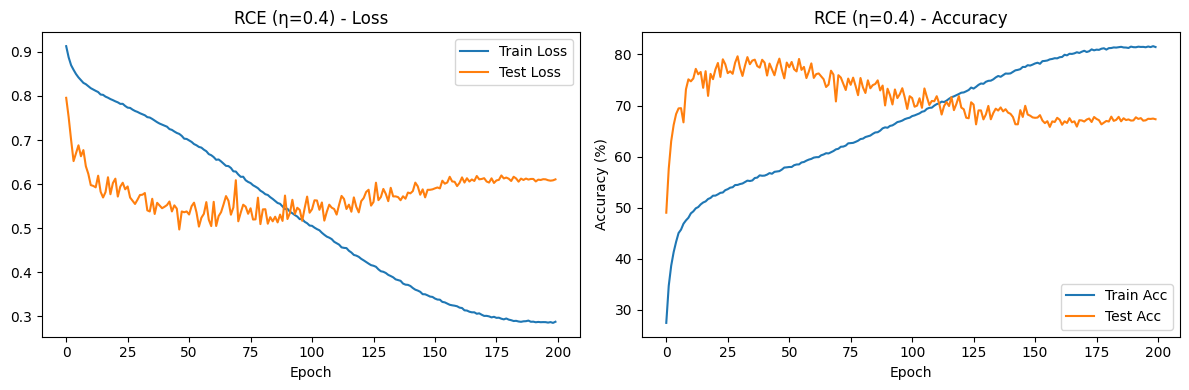


Training normalized Losses...
 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 36.59% | Test Loss: 0.0993


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 44.55% | Test Loss: 0.0943


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 49.62% | Test Loss: 0.0911


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 52.69% | Test Loss: 0.0877


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 53.70% | Test Loss: 0.0859


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 55.27% | Test Loss: 0.0851


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 58.55% | Test Loss: 0.0827


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 59.92% | Test Loss: 0.0802


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 62.26% | Test Loss: 0.0805


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 63.77% | Test Loss: 0.0778


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 62.28% | Test Loss: 0.0784


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 65.72% | Test Loss: 0.0767


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 64.71% | Test Loss: 0.0763


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 66.71% | Test Loss: 0.0749


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 69.72% | Test Loss: 0.0728


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 69.58% | Test Loss: 0.0724


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 70.57% | Test Loss: 0.0717


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 69.94% | Test Loss: 0.0724


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 68.83% | Test Loss: 0.0722


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 69.80% | Test Loss: 0.0704


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 70.75% | Test Loss: 0.0698


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 71.72% | Test Loss: 0.0698


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 72.49% | Test Loss: 0.0682


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 72.54% | Test Loss: 0.0682


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 73.98% | Test Loss: 0.0668


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 72.23% | Test Loss: 0.0687


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 71.68% | Test Loss: 0.0705


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 74.21% | Test Loss: 0.0672


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 74.48% | Test Loss: 0.0668


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 72.52% | Test Loss: 0.0672


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 72.60% | Test Loss: 0.0677


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 74.94% | Test Loss: 0.0654


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 74.78% | Test Loss: 0.0660


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 74.15% | Test Loss: 0.0666


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 75.43% | Test Loss: 0.0658


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 73.54% | Test Loss: 0.0662


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 74.64% | Test Loss: 0.0655


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 74.47% | Test Loss: 0.0653


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 75.85% | Test Loss: 0.0660


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 75.91% | Test Loss: 0.0647


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 75.77% | Test Loss: 0.0647


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 76.63% | Test Loss: 0.0636


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 76.81% | Test Loss: 0.0637


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 76.15% | Test Loss: 0.0645


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 76.31% | Test Loss: 0.0632


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 76.49% | Test Loss: 0.0641


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 76.77% | Test Loss: 0.0635


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 75.76% | Test Loss: 0.0652


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 75.96% | Test Loss: 0.0642


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 76.58% | Test Loss: 0.0635


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 76.87% | Test Loss: 0.0651


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 75.68% | Test Loss: 0.0639


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 76.60% | Test Loss: 0.0628


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 76.33% | Test Loss: 0.0629


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 76.55% | Test Loss: 0.0623


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 77.61% | Test Loss: 0.0607


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 75.98% | Test Loss: 0.0618


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 76.08% | Test Loss: 0.0638


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 75.23% | Test Loss: 0.0644


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 76.80% | Test Loss: 0.0630


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 76.36% | Test Loss: 0.0639


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 76.52% | Test Loss: 0.0620


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 76.69% | Test Loss: 0.0623


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 76.84% | Test Loss: 0.0628


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 75.39% | Test Loss: 0.0630


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 74.73% | Test Loss: 0.0634


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 75.60% | Test Loss: 0.0614


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 75.39% | Test Loss: 0.0615


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 77.07% | Test Loss: 0.0628


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 74.45% | Test Loss: 0.0638


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 76.19% | Test Loss: 0.0607


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 77.16% | Test Loss: 0.0610


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 74.57% | Test Loss: 0.0619


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 73.79% | Test Loss: 0.0635


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 77.07% | Test Loss: 0.0603


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 75.64% | Test Loss: 0.0616


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 75.62% | Test Loss: 0.0613


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 75.73% | Test Loss: 0.0615


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 76.41% | Test Loss: 0.0611


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 75.43% | Test Loss: 0.0612


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 77.36% | Test Loss: 0.0596


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 77.62% | Test Loss: 0.0587


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 76.33% | Test Loss: 0.0607


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 76.52% | Test Loss: 0.0602


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 74.08% | Test Loss: 0.0618


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 75.47% | Test Loss: 0.0607


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 75.24% | Test Loss: 0.0614


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 74.04% | Test Loss: 0.0630


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 75.33% | Test Loss: 0.0614


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 76.12% | Test Loss: 0.0608


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 72.58% | Test Loss: 0.0625


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 73.76% | Test Loss: 0.0621


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 74.63% | Test Loss: 0.0606


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 75.23% | Test Loss: 0.0621


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 74.06% | Test Loss: 0.0613


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 75.66% | Test Loss: 0.0589


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 75.21% | Test Loss: 0.0595


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 73.94% | Test Loss: 0.0603


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 74.80% | Test Loss: 0.0607


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 75.13% | Test Loss: 0.0602


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 75.18% | Test Loss: 0.0595


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 74.60% | Test Loss: 0.0606


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 74.71% | Test Loss: 0.0610


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 74.55% | Test Loss: 0.0610


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 75.61% | Test Loss: 0.0590


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 75.36% | Test Loss: 0.0593


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 73.29% | Test Loss: 0.0610


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 73.77% | Test Loss: 0.0606


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 74.89% | Test Loss: 0.0587


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 74.21% | Test Loss: 0.0599


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 75.19% | Test Loss: 0.0591


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 74.27% | Test Loss: 0.0598


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 74.34% | Test Loss: 0.0606


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 73.53% | Test Loss: 0.0603


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 74.43% | Test Loss: 0.0591


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 74.89% | Test Loss: 0.0589


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 75.33% | Test Loss: 0.0586


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 72.45% | Test Loss: 0.0608


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 73.00% | Test Loss: 0.0610


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 74.63% | Test Loss: 0.0585


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 73.89% | Test Loss: 0.0598


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 72.72% | Test Loss: 0.0610


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 74.13% | Test Loss: 0.0589


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 74.01% | Test Loss: 0.0591


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 71.39% | Test Loss: 0.0615


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 74.40% | Test Loss: 0.0577


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 75.27% | Test Loss: 0.0582


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 73.41% | Test Loss: 0.0600


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 73.62% | Test Loss: 0.0590


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 74.37% | Test Loss: 0.0586


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 74.65% | Test Loss: 0.0570


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 73.99% | Test Loss: 0.0585


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 73.56% | Test Loss: 0.0586


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 73.77% | Test Loss: 0.0588


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 72.74% | Test Loss: 0.0592


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 73.65% | Test Loss: 0.0584


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 72.71% | Test Loss: 0.0596


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 74.41% | Test Loss: 0.0574


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 73.65% | Test Loss: 0.0594


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 73.90% | Test Loss: 0.0587


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 74.39% | Test Loss: 0.0576


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 73.80% | Test Loss: 0.0587


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 74.32% | Test Loss: 0.0575


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 73.64% | Test Loss: 0.0583


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 72.67% | Test Loss: 0.0589


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 74.16% | Test Loss: 0.0580


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 72.89% | Test Loss: 0.0587


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 73.92% | Test Loss: 0.0573


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 73.99% | Test Loss: 0.0571


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 72.80% | Test Loss: 0.0595


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 73.08% | Test Loss: 0.0587


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 72.80% | Test Loss: 0.0590


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 72.72% | Test Loss: 0.0592


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 73.71% | Test Loss: 0.0577


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 73.44% | Test Loss: 0.0583


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 73.69% | Test Loss: 0.0579


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 71.91% | Test Loss: 0.0601


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 73.93% | Test Loss: 0.0577


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 73.03% | Test Loss: 0.0585


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 72.62% | Test Loss: 0.0585


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 73.27% | Test Loss: 0.0578


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 73.90% | Test Loss: 0.0573


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 73.17% | Test Loss: 0.0578


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 73.94% | Test Loss: 0.0571


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 73.96% | Test Loss: 0.0572


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 73.46% | Test Loss: 0.0580


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 73.84% | Test Loss: 0.0571


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 73.93% | Test Loss: 0.0574


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 73.99% | Test Loss: 0.0568


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 73.90% | Test Loss: 0.0569


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 73.78% | Test Loss: 0.0567


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 73.43% | Test Loss: 0.0572


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 73.97% | Test Loss: 0.0568


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 73.42% | Test Loss: 0.0574


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 73.70% | Test Loss: 0.0569


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 73.57% | Test Loss: 0.0570


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 73.54% | Test Loss: 0.0574


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 73.93% | Test Loss: 0.0568


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 73.47% | Test Loss: 0.0576


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 73.63% | Test Loss: 0.0570


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 73.62% | Test Loss: 0.0573


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 73.77% | Test Loss: 0.0571


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 73.75% | Test Loss: 0.0569


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 73.85% | Test Loss: 0.0569


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 73.87% | Test Loss: 0.0570


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 74.03% | Test Loss: 0.0567


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 73.88% | Test Loss: 0.0566


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 73.79% | Test Loss: 0.0568


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 73.82% | Test Loss: 0.0568


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 73.88% | Test Loss: 0.0566


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 74.01% | Test Loss: 0.0567


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 73.80% | Test Loss: 0.0568


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 74.06% | Test Loss: 0.0567


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 74.00% | Test Loss: 0.0566


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 73.88% | Test Loss: 0.0568


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 73.98% | Test Loss: 0.0568


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 73.93% | Test Loss: 0.0567


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 73.97% | Test Loss: 0.0566


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 74.05% | Test Loss: 0.0568


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 74.02% | Test Loss: 0.0566


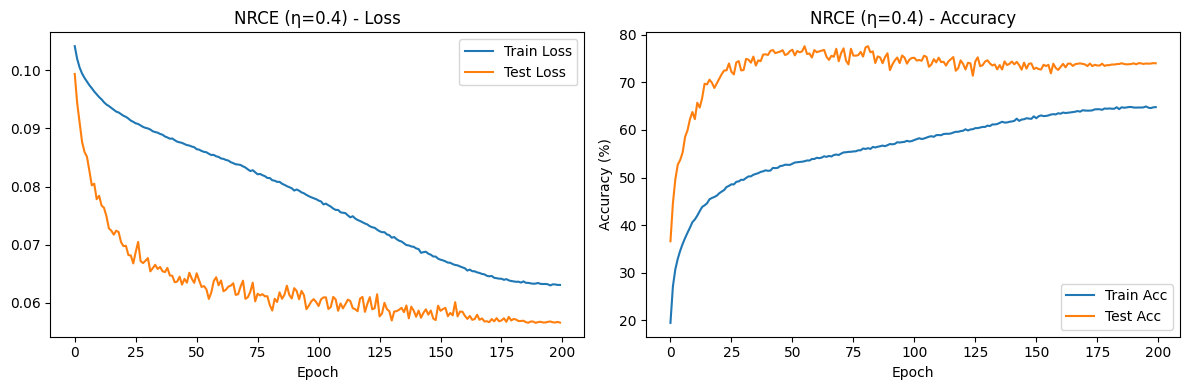


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 48.58% | Test Loss: 0.8374


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 57.93% | Test Loss: 0.7543


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 63.10% | Test Loss: 0.7307


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 64.74% | Test Loss: 0.7175


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 68.12% | Test Loss: 0.6625


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 70.10% | Test Loss: 0.6915


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 69.48% | Test Loss: 0.6688


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 72.31% | Test Loss: 0.6359


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 72.05% | Test Loss: 0.6440


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 73.84% | Test Loss: 0.6379


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 74.13% | Test Loss: 0.6206


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 75.01% | Test Loss: 0.6451


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 75.41% | Test Loss: 0.6209


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 76.40% | Test Loss: 0.6457


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 73.96% | Test Loss: 0.5991


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 76.72% | Test Loss: 0.6100


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 76.84% | Test Loss: 0.6125


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 77.53% | Test Loss: 0.5960


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 76.07% | Test Loss: 0.6243


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 76.07% | Test Loss: 0.5712


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 77.09% | Test Loss: 0.5930


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 76.25% | Test Loss: 0.5976


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 76.49% | Test Loss: 0.5596


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 76.98% | Test Loss: 0.5672


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 76.65% | Test Loss: 0.5946


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 75.24% | Test Loss: 0.6258


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 75.50% | Test Loss: 0.5944


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 78.73% | Test Loss: 0.5547


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 80.09% | Test Loss: 0.5415


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 79.55% | Test Loss: 0.5617


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 76.57% | Test Loss: 0.5735


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 79.88% | Test Loss: 0.5623


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 76.52% | Test Loss: 0.6005


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 77.95% | Test Loss: 0.5652


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 79.33% | Test Loss: 0.5392


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 78.62% | Test Loss: 0.5571


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 78.31% | Test Loss: 0.5561


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 78.15% | Test Loss: 0.5699


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.05it/s]


Test Acc: 77.00% | Test Loss: 0.5740


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 76.36% | Test Loss: 0.5915


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 76.72% | Test Loss: 0.5993


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 79.37% | Test Loss: 0.5022


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 78.10% | Test Loss: 0.5651


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 76.39% | Test Loss: 0.5841


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 79.18% | Test Loss: 0.5387


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 78.00% | Test Loss: 0.5415


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 76.00% | Test Loss: 0.5774


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 76.26% | Test Loss: 0.5530


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 76.54% | Test Loss: 0.5495


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 77.85% | Test Loss: 0.5389


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 76.47% | Test Loss: 0.5515


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 78.39% | Test Loss: 0.5140


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 77.25% | Test Loss: 0.5568


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 78.39% | Test Loss: 0.5267


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 76.54% | Test Loss: 0.5632


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 75.13% | Test Loss: 0.5466


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 76.37% | Test Loss: 0.5376


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 76.42% | Test Loss: 0.5359


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 76.23% | Test Loss: 0.5528


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 76.22% | Test Loss: 0.5757


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 75.99% | Test Loss: 0.5308


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 76.26% | Test Loss: 0.5460


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 75.83% | Test Loss: 0.5577


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 74.80% | Test Loss: 0.5745


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 74.81% | Test Loss: 0.5725


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 67.91% | Test Loss: 0.6592


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 75.26% | Test Loss: 0.5375


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 75.27% | Test Loss: 0.5393


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 75.64% | Test Loss: 0.5411


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 74.97% | Test Loss: 0.5227


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 74.39% | Test Loss: 0.5583


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 75.04% | Test Loss: 0.5479


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 76.83% | Test Loss: 0.5046


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 75.42% | Test Loss: 0.5500


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 74.67% | Test Loss: 0.5513


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 75.22% | Test Loss: 0.5343


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 71.88% | Test Loss: 0.5877


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 74.53% | Test Loss: 0.5424


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 73.86% | Test Loss: 0.5566


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 74.74% | Test Loss: 0.5418


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 73.81% | Test Loss: 0.5543


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 74.54% | Test Loss: 0.5295


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 73.56% | Test Loss: 0.5504


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 74.56% | Test Loss: 0.5302


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 73.29% | Test Loss: 0.5502


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 73.84% | Test Loss: 0.5271


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 72.39% | Test Loss: 0.5711


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.61% | Test Loss: 0.5683


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 69.96% | Test Loss: 0.5879


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 73.95% | Test Loss: 0.5375


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 71.63% | Test Loss: 0.5645


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 74.63% | Test Loss: 0.5180


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 73.97% | Test Loss: 0.5329


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 70.77% | Test Loss: 0.5814


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 72.53% | Test Loss: 0.5515


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 72.80% | Test Loss: 0.5420


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 72.29% | Test Loss: 0.5510


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 70.90% | Test Loss: 0.5775


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 71.30% | Test Loss: 0.5676


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 72.74% | Test Loss: 0.5537


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 71.06% | Test Loss: 0.5778


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 69.48% | Test Loss: 0.5954


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 72.92% | Test Loss: 0.5413


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 69.68% | Test Loss: 0.5830


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 71.83% | Test Loss: 0.5675


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 69.21% | Test Loss: 0.5942


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 70.81% | Test Loss: 0.5707


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 71.84% | Test Loss: 0.5635


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 71.62% | Test Loss: 0.5569


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 69.79% | Test Loss: 0.5836


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.50% | Test Loss: 0.5832


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 70.09% | Test Loss: 0.5729


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 71.07% | Test Loss: 0.5628


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 67.05% | Test Loss: 0.6172


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 71.18% | Test Loss: 0.5662


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 70.12% | Test Loss: 0.5716


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 69.16% | Test Loss: 0.5922


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 69.23% | Test Loss: 0.5859


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 69.56% | Test Loss: 0.5852


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 70.67% | Test Loss: 0.5673


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 69.87% | Test Loss: 0.5730


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 68.60% | Test Loss: 0.5976


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 68.93% | Test Loss: 0.5848


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 70.01% | Test Loss: 0.5828


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 69.38% | Test Loss: 0.5862


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 69.58% | Test Loss: 0.5898


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 69.19% | Test Loss: 0.5855


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 69.68% | Test Loss: 0.5915


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 70.72% | Test Loss: 0.5772


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 67.99% | Test Loss: 0.6082


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 68.72% | Test Loss: 0.5924


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 69.90% | Test Loss: 0.5910


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 68.58% | Test Loss: 0.6018


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 70.36% | Test Loss: 0.5790


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 70.71% | Test Loss: 0.5813


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 68.56% | Test Loss: 0.6089


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 69.16% | Test Loss: 0.6111


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 67.96% | Test Loss: 0.6195


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 69.54% | Test Loss: 0.5947


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 69.97% | Test Loss: 0.5993


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.86% | Test Loss: 0.6112


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 66.98% | Test Loss: 0.6286


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 69.11% | Test Loss: 0.6090


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 68.40% | Test Loss: 0.6162


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 69.22% | Test Loss: 0.6092


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 68.36% | Test Loss: 0.6158


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 68.96% | Test Loss: 0.6137


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 69.85% | Test Loss: 0.6033


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 70.08% | Test Loss: 0.5933


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 67.77% | Test Loss: 0.6256


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 66.53% | Test Loss: 0.6463


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 67.13% | Test Loss: 0.6270


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 67.42% | Test Loss: 0.6292


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 67.77% | Test Loss: 0.6245


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 68.72% | Test Loss: 0.6219


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 68.14% | Test Loss: 0.6278


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 68.74% | Test Loss: 0.6146


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 67.34% | Test Loss: 0.6333


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 68.36% | Test Loss: 0.6229


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 67.43% | Test Loss: 0.6360


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 69.07% | Test Loss: 0.6230


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 68.14% | Test Loss: 0.6276


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 67.47% | Test Loss: 0.6405


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 67.77% | Test Loss: 0.6312


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 68.18% | Test Loss: 0.6265


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 67.67% | Test Loss: 0.6338


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 68.47% | Test Loss: 0.6288


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 68.04% | Test Loss: 0.6330


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 68.10% | Test Loss: 0.6320


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 68.90% | Test Loss: 0.6253


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 67.75% | Test Loss: 0.6372


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 67.82% | Test Loss: 0.6349


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 68.71% | Test Loss: 0.6261


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 67.44% | Test Loss: 0.6436


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 68.20% | Test Loss: 0.6340


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 68.56% | Test Loss: 0.6331


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 68.60% | Test Loss: 0.6327


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 68.06% | Test Loss: 0.6343


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 68.03% | Test Loss: 0.6372


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 68.33% | Test Loss: 0.6369


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 68.14% | Test Loss: 0.6374


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 67.87% | Test Loss: 0.6378


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 67.93% | Test Loss: 0.6400


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 68.08% | Test Loss: 0.6354


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 67.95% | Test Loss: 0.6370


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 68.39% | Test Loss: 0.6332


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.27% | Test Loss: 0.6365


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 68.02% | Test Loss: 0.6402


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 68.08% | Test Loss: 0.6375


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 68.37% | Test Loss: 0.6359


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 67.73% | Test Loss: 0.6389


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 68.24% | Test Loss: 0.6356


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 68.39% | Test Loss: 0.6361


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 67.95% | Test Loss: 0.6403


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 68.32% | Test Loss: 0.6371


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 68.19% | Test Loss: 0.6382


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 68.24% | Test Loss: 0.6373


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 68.28% | Test Loss: 0.6365


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 68.01% | Test Loss: 0.6389


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 68.16% | Test Loss: 0.6379


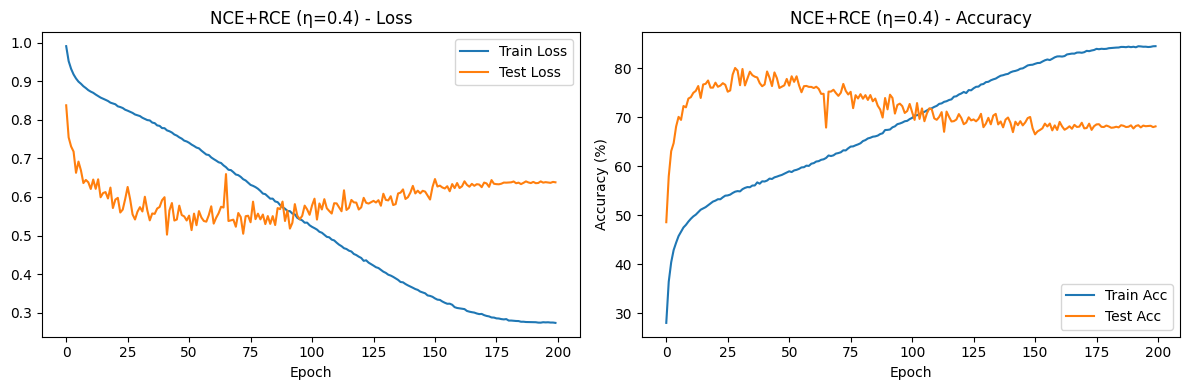

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 51.15% | Test Loss: 0.8456


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 55.08% | Test Loss: 0.7776


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 62.44% | Test Loss: 0.7395


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 66.17% | Test Loss: 0.6851


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 68.61% | Test Loss: 0.6862


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 69.98% | Test Loss: 0.6764


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 69.04% | Test Loss: 0.6381


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 70.42% | Test Loss: 0.6618


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 71.09% | Test Loss: 0.6713


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 74.98% | Test Loss: 0.6289


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 76.40% | Test Loss: 0.6128


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 73.73% | Test Loss: 0.6416


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 74.40% | Test Loss: 0.6256


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 74.99% | Test Loss: 0.6130


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 75.94% | Test Loss: 0.6166


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 75.23% | Test Loss: 0.6182


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 75.55% | Test Loss: 0.5966


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 75.96% | Test Loss: 0.6101


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 77.13% | Test Loss: 0.6188


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 77.40% | Test Loss: 0.5958


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 78.20% | Test Loss: 0.5917


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 79.62% | Test Loss: 0.5606


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 78.33% | Test Loss: 0.6022


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 78.14% | Test Loss: 0.5622


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 80.43% | Test Loss: 0.5624


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 77.71% | Test Loss: 0.5727


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 78.11% | Test Loss: 0.5508


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 77.18% | Test Loss: 0.5833


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 78.23% | Test Loss: 0.5823


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 79.06% | Test Loss: 0.5828


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 78.41% | Test Loss: 0.5819


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 78.63% | Test Loss: 0.5791


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 77.75% | Test Loss: 0.5924


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 77.44% | Test Loss: 0.5528


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 78.86% | Test Loss: 0.5515


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 78.33% | Test Loss: 0.5572


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 77.85% | Test Loss: 0.5286


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 76.65% | Test Loss: 0.5552


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 78.18% | Test Loss: 0.5897


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 79.51% | Test Loss: 0.5620


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 78.29% | Test Loss: 0.5759


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 78.01% | Test Loss: 0.5699


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 79.58% | Test Loss: 0.5286


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 79.08% | Test Loss: 0.5078


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 78.62% | Test Loss: 0.5393


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 78.56% | Test Loss: 0.5282


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 76.30% | Test Loss: 0.5371


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 78.57% | Test Loss: 0.5438


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 77.11% | Test Loss: 0.5299


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 78.74% | Test Loss: 0.5381


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.01it/s]


Test Acc: 73.71% | Test Loss: 0.5867


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 76.44% | Test Loss: 0.5887


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 74.58% | Test Loss: 0.5598


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 76.97% | Test Loss: 0.5375


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 75.00% | Test Loss: 0.5547


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 77.79% | Test Loss: 0.5467


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 77.40% | Test Loss: 0.4996


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 76.15% | Test Loss: 0.5395


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 76.91% | Test Loss: 0.5303


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 74.96% | Test Loss: 0.5628


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 76.75% | Test Loss: 0.5548


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 75.61% | Test Loss: 0.5514


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 75.55% | Test Loss: 0.5814


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 75.88% | Test Loss: 0.5572


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 74.11% | Test Loss: 0.5611


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 74.55% | Test Loss: 0.5577


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 76.44% | Test Loss: 0.5384


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 75.41% | Test Loss: 0.5468


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 75.23% | Test Loss: 0.5405


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 76.13% | Test Loss: 0.5298


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 75.67% | Test Loss: 0.5256


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 75.27% | Test Loss: 0.5220


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 74.84% | Test Loss: 0.5489


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 76.25% | Test Loss: 0.5110


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 73.78% | Test Loss: 0.5575


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 72.83% | Test Loss: 0.5673


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 73.72% | Test Loss: 0.5615


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 74.04% | Test Loss: 0.5483


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 74.46% | Test Loss: 0.5452


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 75.09% | Test Loss: 0.5352


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 72.54% | Test Loss: 0.5580


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 74.88% | Test Loss: 0.5179


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 73.95% | Test Loss: 0.5322


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 72.18% | Test Loss: 0.5722


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 74.28% | Test Loss: 0.5196


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 72.52% | Test Loss: 0.5545


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 73.21% | Test Loss: 0.5427


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 71.61% | Test Loss: 0.5619


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 70.18% | Test Loss: 0.5961


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 71.96% | Test Loss: 0.5625


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 71.35% | Test Loss: 0.5752


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 73.24% | Test Loss: 0.5496


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 73.01% | Test Loss: 0.5382


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 71.65% | Test Loss: 0.5595


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 73.36% | Test Loss: 0.5385


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 70.40% | Test Loss: 0.5785


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 69.06% | Test Loss: 0.5885


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 70.51% | Test Loss: 0.5756


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 72.36% | Test Loss: 0.5431


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 71.29% | Test Loss: 0.5643


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 70.55% | Test Loss: 0.5721


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 71.66% | Test Loss: 0.5586


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 71.23% | Test Loss: 0.5655


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 71.83% | Test Loss: 0.5516


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 71.22% | Test Loss: 0.5657


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 70.06% | Test Loss: 0.5692


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 73.12% | Test Loss: 0.5305


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.87% | Test Loss: 0.5873


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 70.58% | Test Loss: 0.5730


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 68.96% | Test Loss: 0.5864


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 69.79% | Test Loss: 0.5815


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 70.38% | Test Loss: 0.5759


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 72.27% | Test Loss: 0.5462


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 71.91% | Test Loss: 0.5496


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.70% | Test Loss: 0.5637


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 68.38% | Test Loss: 0.6010


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 69.44% | Test Loss: 0.5854


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 70.25% | Test Loss: 0.5705


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 71.28% | Test Loss: 0.5668


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 69.24% | Test Loss: 0.5928


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 70.47% | Test Loss: 0.5735


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 66.30% | Test Loss: 0.6224


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.18% | Test Loss: 0.6085


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 69.95% | Test Loss: 0.5911


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 70.19% | Test Loss: 0.5773


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 70.38% | Test Loss: 0.5739


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 69.30% | Test Loss: 0.5898


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 68.69% | Test Loss: 0.5942


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 67.49% | Test Loss: 0.6108


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 70.58% | Test Loss: 0.5795


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 70.07% | Test Loss: 0.5827


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 68.97% | Test Loss: 0.5928


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 68.91% | Test Loss: 0.5953


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 69.43% | Test Loss: 0.5962


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 69.03% | Test Loss: 0.5972


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 69.19% | Test Loss: 0.6041


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 68.58% | Test Loss: 0.6078


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 66.37% | Test Loss: 0.6315


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 67.79% | Test Loss: 0.6149


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 68.05% | Test Loss: 0.6098


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 69.10% | Test Loss: 0.6050


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 68.86% | Test Loss: 0.6060


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 68.85% | Test Loss: 0.6064


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 67.65% | Test Loss: 0.6254


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 68.36% | Test Loss: 0.6083


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 68.29% | Test Loss: 0.6145


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 67.06% | Test Loss: 0.6243


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 69.48% | Test Loss: 0.6008


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 69.00% | Test Loss: 0.6092


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.29% | Test Loss: 0.6127


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 67.50% | Test Loss: 0.6253


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 67.85% | Test Loss: 0.6222


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 68.25% | Test Loss: 0.6249


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 68.78% | Test Loss: 0.6150


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 67.55% | Test Loss: 0.6276


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 68.08% | Test Loss: 0.6210


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 68.15% | Test Loss: 0.6212


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 68.22% | Test Loss: 0.6276


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 68.42% | Test Loss: 0.6259


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 68.01% | Test Loss: 0.6232


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 67.33% | Test Loss: 0.6303


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 68.41% | Test Loss: 0.6237


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 67.94% | Test Loss: 0.6301


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 68.64% | Test Loss: 0.6180


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 67.99% | Test Loss: 0.6290


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 68.16% | Test Loss: 0.6237


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 67.62% | Test Loss: 0.6311


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 68.03% | Test Loss: 0.6315


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 68.06% | Test Loss: 0.6336


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.14% | Test Loss: 0.6428


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 68.07% | Test Loss: 0.6325


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 67.41% | Test Loss: 0.6398


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 67.47% | Test Loss: 0.6379


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 68.00% | Test Loss: 0.6309


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 68.05% | Test Loss: 0.6292


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 68.17% | Test Loss: 0.6294


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 67.33% | Test Loss: 0.6408


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.91it/s]


Test Acc: 67.95% | Test Loss: 0.6351


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 68.12% | Test Loss: 0.6326


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 67.28% | Test Loss: 0.6434


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.03it/s]


Test Acc: 67.21% | Test Loss: 0.6463


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 67.44% | Test Loss: 0.6389


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 67.75% | Test Loss: 0.6371


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 67.81% | Test Loss: 0.6395


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 67.89% | Test Loss: 0.6404


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 67.73% | Test Loss: 0.6396


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 67.92% | Test Loss: 0.6373


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 67.97% | Test Loss: 0.6374


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 67.84% | Test Loss: 0.6376


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 67.61% | Test Loss: 0.6416


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 67.77% | Test Loss: 0.6378


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.90it/s]


Test Acc: 67.78% | Test Loss: 0.6403


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 67.85% | Test Loss: 0.6388


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 67.70% | Test Loss: 0.6396


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 67.66% | Test Loss: 0.6405


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 67.74% | Test Loss: 0.6414


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 67.66% | Test Loss: 0.6418


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 67.90% | Test Loss: 0.6405


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 67.79% | Test Loss: 0.6409


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 67.72% | Test Loss: 0.6427


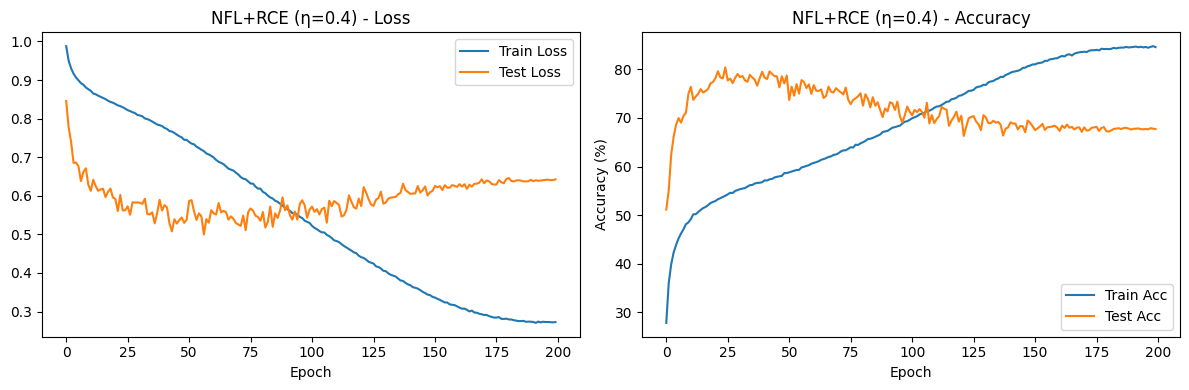

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 49.53% | Test Loss: 1.4455


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 60.01% | Test Loss: 1.2507


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 64.34% | Test Loss: 1.1793


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 67.23% | Test Loss: 1.1304


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 68.82% | Test Loss: 1.1237


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 73.62% | Test Loss: 0.9876


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 68.89% | Test Loss: 1.0468


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 74.88% | Test Loss: 0.9524


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 75.18% | Test Loss: 0.9935


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 72.54% | Test Loss: 1.0298


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 76.36% | Test Loss: 0.9815


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 74.98% | Test Loss: 0.9518


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 77.86% | Test Loss: 0.9122


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 76.53% | Test Loss: 0.9056


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 75.50% | Test Loss: 0.9546


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 76.76% | Test Loss: 0.9603


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 76.00% | Test Loss: 0.9533


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 78.77% | Test Loss: 0.9468


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 79.33% | Test Loss: 0.9100


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 79.12% | Test Loss: 0.9446


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 79.24% | Test Loss: 0.8846


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 79.13% | Test Loss: 0.8886


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 77.02% | Test Loss: 0.8967


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 78.98% | Test Loss: 0.9657


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 78.64% | Test Loss: 0.8967


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 80.52% | Test Loss: 0.8373


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 78.32% | Test Loss: 0.8810


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 79.06% | Test Loss: 0.8518


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 79.23% | Test Loss: 0.8595


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 78.80% | Test Loss: 0.8716


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 79.86% | Test Loss: 0.8540


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 80.42% | Test Loss: 0.8558


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 81.38% | Test Loss: 0.8701


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 81.22% | Test Loss: 0.8350


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 78.40% | Test Loss: 0.8930


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 81.02% | Test Loss: 0.8528


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 78.36% | Test Loss: 0.8821


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 80.17% | Test Loss: 0.8683


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 80.15% | Test Loss: 0.8347


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 79.00% | Test Loss: 0.8498


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 80.30% | Test Loss: 0.8189


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 80.68% | Test Loss: 0.8095


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 80.78% | Test Loss: 0.8440


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 78.18% | Test Loss: 0.9020


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 76.86% | Test Loss: 0.9007


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 79.43% | Test Loss: 0.8081


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 79.55% | Test Loss: 0.8761


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 79.37% | Test Loss: 0.8109


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 79.18% | Test Loss: 0.9105


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 78.85% | Test Loss: 0.8726


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 78.53% | Test Loss: 0.8080


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 78.57% | Test Loss: 0.8225


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 77.92% | Test Loss: 0.9138


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 78.87% | Test Loss: 0.8433


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 77.95% | Test Loss: 0.8940


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 79.44% | Test Loss: 0.8328


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 78.62% | Test Loss: 0.8176


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 78.46% | Test Loss: 0.8378


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 77.22% | Test Loss: 0.8683


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 77.40% | Test Loss: 0.8488


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 77.84% | Test Loss: 0.8286


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 76.22% | Test Loss: 0.9022


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 76.92% | Test Loss: 0.8358


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 76.70% | Test Loss: 0.8486


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 76.49% | Test Loss: 0.8704


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 76.61% | Test Loss: 0.8677


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 77.75% | Test Loss: 0.8154


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 77.62% | Test Loss: 0.8145


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 78.05% | Test Loss: 0.8010


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 76.69% | Test Loss: 0.8862


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 74.42% | Test Loss: 0.9198


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 75.82% | Test Loss: 0.8800


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 76.08% | Test Loss: 0.8457


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 76.89% | Test Loss: 0.8400


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 76.40% | Test Loss: 0.8436


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 75.81% | Test Loss: 0.8551


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 74.01% | Test Loss: 0.9184


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 74.78% | Test Loss: 0.9027


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 76.02% | Test Loss: 0.8395


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 74.02% | Test Loss: 0.9043


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 74.83% | Test Loss: 0.8738


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 73.80% | Test Loss: 0.9068


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 75.35% | Test Loss: 0.8653


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 72.37% | Test Loss: 0.9415


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 74.66% | Test Loss: 0.8835


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 73.10% | Test Loss: 0.9332


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 72.57% | Test Loss: 0.9258


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 74.54% | Test Loss: 0.8675


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 72.81% | Test Loss: 0.9140


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 72.35% | Test Loss: 0.9111


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 72.18% | Test Loss: 0.9307


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 72.45% | Test Loss: 0.9258


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 72.31% | Test Loss: 0.9217


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 73.82% | Test Loss: 0.8956


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 72.93% | Test Loss: 0.9076


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 71.34% | Test Loss: 0.9456


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 71.29% | Test Loss: 0.9475


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 71.83% | Test Loss: 0.9324


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 73.46% | Test Loss: 0.8731


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 72.66% | Test Loss: 0.9079


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 72.73% | Test Loss: 0.9152


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 72.32% | Test Loss: 0.9297


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 73.25% | Test Loss: 0.8958


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 70.83% | Test Loss: 0.9562


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 69.89% | Test Loss: 0.9779


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.04% | Test Loss: 0.9393


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 72.13% | Test Loss: 0.9189


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 72.29% | Test Loss: 0.9036


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 67.61% | Test Loss: 1.0227


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 71.73% | Test Loss: 0.9268


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 71.76% | Test Loss: 0.9226


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 68.67% | Test Loss: 0.9859


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 69.48% | Test Loss: 0.9863


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 69.27% | Test Loss: 0.9813


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 69.89% | Test Loss: 0.9729


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 68.93% | Test Loss: 0.9922


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 70.07% | Test Loss: 0.9664


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 70.64% | Test Loss: 0.9531


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 68.28% | Test Loss: 1.0082


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 68.26% | Test Loss: 1.0007


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 68.91% | Test Loss: 0.9867


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 69.52% | Test Loss: 0.9727


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 70.23% | Test Loss: 0.9638


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 69.79% | Test Loss: 0.9706


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 68.92% | Test Loss: 0.9881


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 69.12% | Test Loss: 0.9843


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 68.19% | Test Loss: 1.0015


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 69.83% | Test Loss: 0.9701


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 67.76% | Test Loss: 1.0097


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 71.23% | Test Loss: 0.9452


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 70.35% | Test Loss: 0.9532


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 68.80% | Test Loss: 0.9953


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 68.71% | Test Loss: 1.0072


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.74% | Test Loss: 0.9975


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 68.48% | Test Loss: 1.0105


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 69.19% | Test Loss: 0.9952


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 66.39% | Test Loss: 1.0414


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 69.40% | Test Loss: 0.9814


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 67.35% | Test Loss: 1.0281


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 68.59% | Test Loss: 0.9987


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 67.66% | Test Loss: 1.0194


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 69.31% | Test Loss: 0.9907


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 69.29% | Test Loss: 0.9868


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 69.04% | Test Loss: 1.0012


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.66% | Test Loss: 1.0057


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 68.29% | Test Loss: 1.0116


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 69.29% | Test Loss: 0.9952


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 67.79% | Test Loss: 1.0280


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 67.96% | Test Loss: 1.0311


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 67.68% | Test Loss: 1.0280


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 67.97% | Test Loss: 1.0304


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 67.20% | Test Loss: 1.0376


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 67.79% | Test Loss: 1.0271


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 69.05% | Test Loss: 1.0017


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 67.04% | Test Loss: 1.0454


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 68.62% | Test Loss: 1.0103


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 67.21% | Test Loss: 1.0424


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 68.21% | Test Loss: 1.0253


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 67.41% | Test Loss: 1.0353


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 67.91% | Test Loss: 1.0310


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 67.11% | Test Loss: 1.0396


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 68.46% | Test Loss: 1.0300


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 67.84% | Test Loss: 1.0352


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 67.74% | Test Loss: 1.0440


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 68.64% | Test Loss: 1.0152


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.04% | Test Loss: 1.0299


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 67.52% | Test Loss: 1.0432


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 67.26% | Test Loss: 1.0382


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 68.26% | Test Loss: 1.0238


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 68.43% | Test Loss: 1.0160


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 67.48% | Test Loss: 1.0414


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 67.25% | Test Loss: 1.0412


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 67.53% | Test Loss: 1.0386


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 66.81% | Test Loss: 1.0511


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 66.34% | Test Loss: 1.0626


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 67.14% | Test Loss: 1.0490


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 66.64% | Test Loss: 1.0554


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 67.41% | Test Loss: 1.0406


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 67.46% | Test Loss: 1.0396


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.40% | Test Loss: 1.0464


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 66.96% | Test Loss: 1.0570


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 67.60% | Test Loss: 1.0400


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 67.66% | Test Loss: 1.0394


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 66.87% | Test Loss: 1.0542


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 67.60% | Test Loss: 1.0376


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 67.42% | Test Loss: 1.0461


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 67.33% | Test Loss: 1.0463


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 67.70% | Test Loss: 1.0425


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 67.19% | Test Loss: 1.0491


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 67.10% | Test Loss: 1.0506


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 67.05% | Test Loss: 1.0521


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 67.51% | Test Loss: 1.0451


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 67.41% | Test Loss: 1.0478


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 67.35% | Test Loss: 1.0472


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 67.29% | Test Loss: 1.0517


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 67.48% | Test Loss: 1.0463


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 67.02% | Test Loss: 1.0517


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 67.44% | Test Loss: 1.0480


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 67.30% | Test Loss: 1.0481


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 67.41% | Test Loss: 1.0481


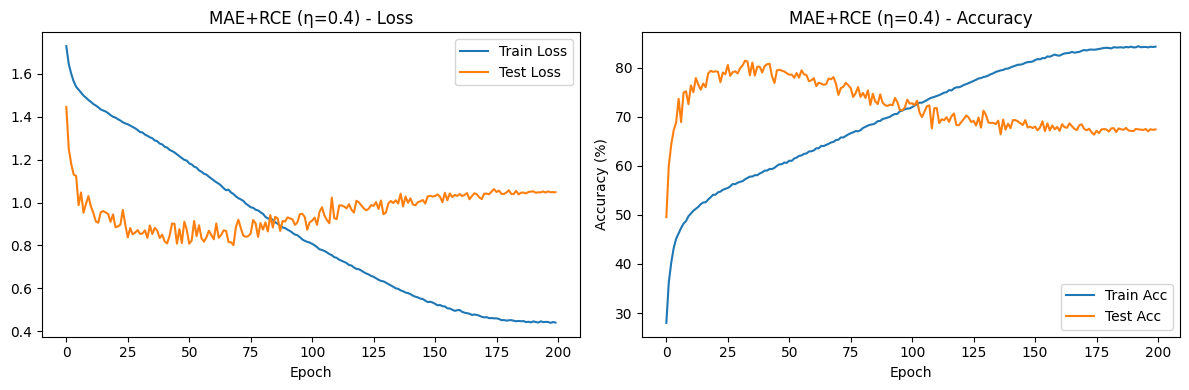


Noise Rate: 0.6

Training vanilla Losses...
 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 46.54% | Test Loss: 0.8584


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 48.46% | Test Loss: 0.8350


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 53.41% | Test Loss: 0.8280


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 59.25% | Test Loss: 0.8102


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 60.61% | Test Loss: 0.7986


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 61.55% | Test Loss: 0.7827


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 62.41% | Test Loss: 0.7919


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 65.74% | Test Loss: 0.7528


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 66.50% | Test Loss: 0.7577


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 66.27% | Test Loss: 0.7658


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 67.64% | Test Loss: 0.7362


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 69.28% | Test Loss: 0.7433


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 65.99% | Test Loss: 0.7683


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 66.80% | Test Loss: 0.7583


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 67.39% | Test Loss: 0.7481


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 69.76% | Test Loss: 0.7391


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 71.21% | Test Loss: 0.7602


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 69.95% | Test Loss: 0.7484


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 72.54% | Test Loss: 0.7280


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 68.47% | Test Loss: 0.7397


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 71.47% | Test Loss: 0.7374


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 70.29% | Test Loss: 0.7348


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 69.71% | Test Loss: 0.7259


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 69.93% | Test Loss: 0.7419


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 70.27% | Test Loss: 0.7277


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 68.72% | Test Loss: 0.7269


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 69.30% | Test Loss: 0.7563


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 72.47% | Test Loss: 0.7280


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 73.37% | Test Loss: 0.7132


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 71.80% | Test Loss: 0.7241


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 71.86% | Test Loss: 0.7027


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 69.56% | Test Loss: 0.7385


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 72.76% | Test Loss: 0.6903


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 73.00% | Test Loss: 0.6833


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 71.87% | Test Loss: 0.7135


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 72.73% | Test Loss: 0.6920


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 72.52% | Test Loss: 0.6889


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 69.92% | Test Loss: 0.7191


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 71.70% | Test Loss: 0.7228


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 71.07% | Test Loss: 0.6868


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 71.18% | Test Loss: 0.7062


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 68.10% | Test Loss: 0.7172


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 69.41% | Test Loss: 0.6878


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 69.02% | Test Loss: 0.7385


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 68.73% | Test Loss: 0.6675


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 68.36% | Test Loss: 0.6977


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 69.76% | Test Loss: 0.6717


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 69.76% | Test Loss: 0.7253


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 70.67% | Test Loss: 0.6705


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 67.31% | Test Loss: 0.7217


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.60% | Test Loss: 0.7015


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 67.48% | Test Loss: 0.6794


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 68.15% | Test Loss: 0.6999


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 67.90% | Test Loss: 0.6824


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 67.68% | Test Loss: 0.6995


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 67.12% | Test Loss: 0.7289


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 68.86% | Test Loss: 0.6810


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 67.84% | Test Loss: 0.6882


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 68.37% | Test Loss: 0.6744


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.76% | Test Loss: 0.7054


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 67.58% | Test Loss: 0.7048


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 65.63% | Test Loss: 0.6901


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 63.65% | Test Loss: 0.7353


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 64.44% | Test Loss: 0.6999


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 63.88% | Test Loss: 0.7174


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 64.78% | Test Loss: 0.7004


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 62.87% | Test Loss: 0.7181


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 60.37% | Test Loss: 0.7450


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 65.06% | Test Loss: 0.6578


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 67.46% | Test Loss: 0.6650


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 64.96% | Test Loss: 0.6797


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 64.03% | Test Loss: 0.6911


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 64.19% | Test Loss: 0.6836


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 60.49% | Test Loss: 0.7185


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 64.29% | Test Loss: 0.7032


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 61.97% | Test Loss: 0.6943


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 61.79% | Test Loss: 0.7099


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 61.19% | Test Loss: 0.7086


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 57.75% | Test Loss: 0.7313


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 57.49% | Test Loss: 0.7350


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 60.14% | Test Loss: 0.7025


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 61.75% | Test Loss: 0.6802


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 60.21% | Test Loss: 0.7015


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 59.49% | Test Loss: 0.7036


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 58.07% | Test Loss: 0.7112


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 59.18% | Test Loss: 0.7041


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 58.46% | Test Loss: 0.7137


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 57.42% | Test Loss: 0.7152


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 58.15% | Test Loss: 0.7108


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 61.00% | Test Loss: 0.6840


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 58.63% | Test Loss: 0.7093


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 57.85% | Test Loss: 0.7082


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 58.85% | Test Loss: 0.6915


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 58.86% | Test Loss: 0.6967


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 56.79% | Test Loss: 0.7112


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 60.48% | Test Loss: 0.6922


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 56.18% | Test Loss: 0.7189


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 57.19% | Test Loss: 0.7119


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 58.63% | Test Loss: 0.6945


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 59.29% | Test Loss: 0.6909


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 57.27% | Test Loss: 0.7042


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 56.32% | Test Loss: 0.7119


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 55.59% | Test Loss: 0.7163


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 58.20% | Test Loss: 0.6918


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 55.98% | Test Loss: 0.7163


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 55.75% | Test Loss: 0.7181


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 52.70% | Test Loss: 0.7387


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 56.73% | Test Loss: 0.7049


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 54.33% | Test Loss: 0.7221


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 57.76% | Test Loss: 0.6915


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 58.61% | Test Loss: 0.6865


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 52.14% | Test Loss: 0.7493


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 56.07% | Test Loss: 0.7097


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 54.75% | Test Loss: 0.7237


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 50.79% | Test Loss: 0.7520


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 53.61% | Test Loss: 0.7291


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 55.64% | Test Loss: 0.7082


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 53.02% | Test Loss: 0.7383


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 52.18% | Test Loss: 0.7565


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 49.94% | Test Loss: 0.7631


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 51.24% | Test Loss: 0.7589


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 51.32% | Test Loss: 0.7522


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 54.54% | Test Loss: 0.7234


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 55.12% | Test Loss: 0.7149


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 51.57% | Test Loss: 0.7510


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 53.61% | Test Loss: 0.7385


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 54.15% | Test Loss: 0.7323


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 53.49% | Test Loss: 0.7380


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 51.09% | Test Loss: 0.7556


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 52.52% | Test Loss: 0.7600


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 52.89% | Test Loss: 0.7415


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 49.20% | Test Loss: 0.7692


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 54.39% | Test Loss: 0.7369


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 51.45% | Test Loss: 0.7677


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 53.95% | Test Loss: 0.7442


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 52.71% | Test Loss: 0.7533


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 50.94% | Test Loss: 0.7647


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 51.79% | Test Loss: 0.7688


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 52.39% | Test Loss: 0.7507


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 52.20% | Test Loss: 0.7653


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 50.23% | Test Loss: 0.7866


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 51.63% | Test Loss: 0.7669


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 49.42% | Test Loss: 0.7856


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 48.47% | Test Loss: 0.8056


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 51.60% | Test Loss: 0.7668


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 51.73% | Test Loss: 0.7677


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 49.60% | Test Loss: 0.7795


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 50.59% | Test Loss: 0.7791


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 51.02% | Test Loss: 0.7790


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 51.59% | Test Loss: 0.7744


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 49.16% | Test Loss: 0.7956


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 50.47% | Test Loss: 0.7846


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 51.25% | Test Loss: 0.7789


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 51.62% | Test Loss: 0.7894


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 50.41% | Test Loss: 0.7978


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 49.85% | Test Loss: 0.7907


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 51.98% | Test Loss: 0.7774


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 50.93% | Test Loss: 0.7957


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 48.68% | Test Loss: 0.8087


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 48.83% | Test Loss: 0.8097


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 50.66% | Test Loss: 0.7948


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 49.88% | Test Loss: 0.8066


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 50.34% | Test Loss: 0.8049


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 49.64% | Test Loss: 0.8098


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 51.17% | Test Loss: 0.7951


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 50.48% | Test Loss: 0.8027


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 50.11% | Test Loss: 0.8051


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 50.26% | Test Loss: 0.8112


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 50.50% | Test Loss: 0.8004


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 49.37% | Test Loss: 0.8170


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 48.42% | Test Loss: 0.8134


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 48.51% | Test Loss: 0.8192


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 49.66% | Test Loss: 0.8205


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 49.07% | Test Loss: 0.8219


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 49.55% | Test Loss: 0.8126


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 49.51% | Test Loss: 0.8147


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 49.31% | Test Loss: 0.8213


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 49.98% | Test Loss: 0.8171


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 49.79% | Test Loss: 0.8182


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 49.41% | Test Loss: 0.8235


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 49.79% | Test Loss: 0.8221


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 49.81% | Test Loss: 0.8197


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 50.12% | Test Loss: 0.8187


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 49.50% | Test Loss: 0.8250


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 48.93% | Test Loss: 0.8283


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 50.11% | Test Loss: 0.8194


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 49.78% | Test Loss: 0.8194


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 49.26% | Test Loss: 0.8270


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 49.80% | Test Loss: 0.8220


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 49.91% | Test Loss: 0.8217


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 50.17% | Test Loss: 0.8189


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 49.71% | Test Loss: 0.8214


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 49.48% | Test Loss: 0.8242


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 49.61% | Test Loss: 0.8230


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 49.51% | Test Loss: 0.8218


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 49.49% | Test Loss: 0.8226


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 49.95% | Test Loss: 0.8203


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 49.86% | Test Loss: 0.8207


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 49.44% | Test Loss: 0.8236


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 49.66% | Test Loss: 0.8231


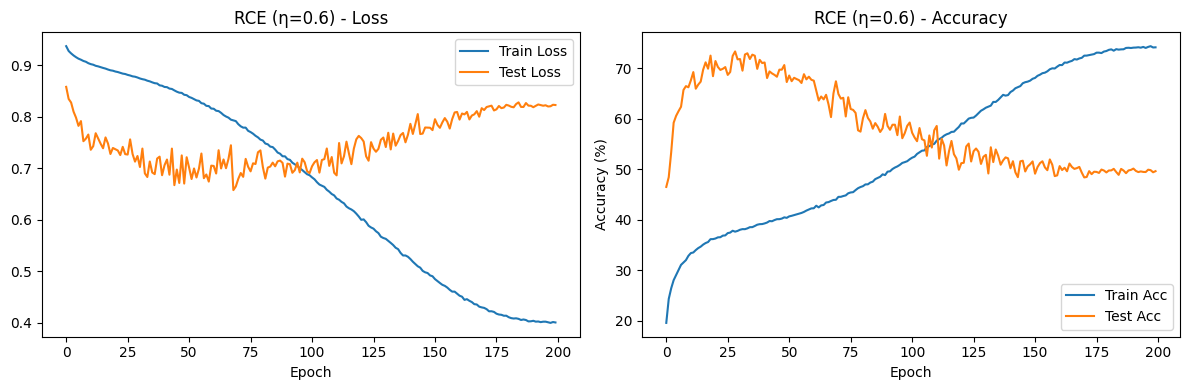


Training normalized Losses...
 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 31.56% | Test Loss: 0.1021


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 39.24% | Test Loss: 0.0996


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 43.17% | Test Loss: 0.0976


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 46.30% | Test Loss: 0.0960


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 48.84% | Test Loss: 0.0945


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 49.77% | Test Loss: 0.0938


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 52.21% | Test Loss: 0.0932


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 53.22% | Test Loss: 0.0922


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 54.37% | Test Loss: 0.0912


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 55.33% | Test Loss: 0.0917


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 56.32% | Test Loss: 0.0905


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 57.49% | Test Loss: 0.0900


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 58.42% | Test Loss: 0.0893


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 58.38% | Test Loss: 0.0886


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 60.35% | Test Loss: 0.0883


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 59.88% | Test Loss: 0.0878


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 60.49% | Test Loss: 0.0871


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 61.23% | Test Loss: 0.0874


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 61.56% | Test Loss: 0.0856


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 62.50% | Test Loss: 0.0865


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 61.27% | Test Loss: 0.0863


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 62.75% | Test Loss: 0.0860


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 62.69% | Test Loss: 0.0855


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 64.18% | Test Loss: 0.0852


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 64.95% | Test Loss: 0.0851


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 64.67% | Test Loss: 0.0845


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 64.43% | Test Loss: 0.0843


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 66.23% | Test Loss: 0.0838


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 66.73% | Test Loss: 0.0825


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 66.87% | Test Loss: 0.0828


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 66.39% | Test Loss: 0.0829


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 66.30% | Test Loss: 0.0827


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 67.38% | Test Loss: 0.0833


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 68.51% | Test Loss: 0.0820


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 67.44% | Test Loss: 0.0818


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 66.56% | Test Loss: 0.0825


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 68.78% | Test Loss: 0.0825


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 68.25% | Test Loss: 0.0818


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 68.52% | Test Loss: 0.0823


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 68.81% | Test Loss: 0.0822


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 69.70% | Test Loss: 0.0808


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 64.88% | Test Loss: 0.0814


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 66.79% | Test Loss: 0.0814


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 68.76% | Test Loss: 0.0807


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 69.13% | Test Loss: 0.0801


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 69.84% | Test Loss: 0.0806


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 69.85% | Test Loss: 0.0793


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 69.38% | Test Loss: 0.0807


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 70.04% | Test Loss: 0.0790


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 69.39% | Test Loss: 0.0810


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 69.26% | Test Loss: 0.0799


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 69.09% | Test Loss: 0.0806


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 69.40% | Test Loss: 0.0797


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 67.93% | Test Loss: 0.0810


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 70.13% | Test Loss: 0.0789


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 69.60% | Test Loss: 0.0795


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 69.81% | Test Loss: 0.0786


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 70.95% | Test Loss: 0.0788


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 70.88% | Test Loss: 0.0785


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 70.73% | Test Loss: 0.0780


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 69.45% | Test Loss: 0.0790


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.79% | Test Loss: 0.0778


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 69.98% | Test Loss: 0.0785


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 69.21% | Test Loss: 0.0792


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 70.08% | Test Loss: 0.0791


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 69.97% | Test Loss: 0.0780


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 70.23% | Test Loss: 0.0771


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 68.96% | Test Loss: 0.0788


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 69.79% | Test Loss: 0.0785


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 68.68% | Test Loss: 0.0793


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 69.40% | Test Loss: 0.0785


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 69.09% | Test Loss: 0.0786


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 70.69% | Test Loss: 0.0784


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 70.34% | Test Loss: 0.0777


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 70.66% | Test Loss: 0.0767


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 70.98% | Test Loss: 0.0770


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 68.71% | Test Loss: 0.0780


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 68.73% | Test Loss: 0.0779


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 68.65% | Test Loss: 0.0781


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 69.56% | Test Loss: 0.0783


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 66.47% | Test Loss: 0.0783


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 69.77% | Test Loss: 0.0763


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 66.66% | Test Loss: 0.0793


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.59% | Test Loss: 0.0783


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 69.33% | Test Loss: 0.0767


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 69.23% | Test Loss: 0.0765


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 69.48% | Test Loss: 0.0764


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 69.13% | Test Loss: 0.0762


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 69.36% | Test Loss: 0.0767


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 70.07% | Test Loss: 0.0757


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 68.73% | Test Loss: 0.0776


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 69.62% | Test Loss: 0.0761


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 69.38% | Test Loss: 0.0765


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 69.49% | Test Loss: 0.0764


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 68.13% | Test Loss: 0.0767


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 68.01% | Test Loss: 0.0769


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 68.09% | Test Loss: 0.0771


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 67.58% | Test Loss: 0.0768


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 69.19% | Test Loss: 0.0767


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 68.02% | Test Loss: 0.0769


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 68.17% | Test Loss: 0.0763


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 67.32% | Test Loss: 0.0771


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 68.20% | Test Loss: 0.0765


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.60% | Test Loss: 0.0770


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 67.08% | Test Loss: 0.0770


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.40% | Test Loss: 0.0752


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 67.19% | Test Loss: 0.0765


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 67.73% | Test Loss: 0.0758


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 66.45% | Test Loss: 0.0764


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 67.71% | Test Loss: 0.0756


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.47% | Test Loss: 0.0766


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 67.28% | Test Loss: 0.0754


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 65.40% | Test Loss: 0.0781


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 66.34% | Test Loss: 0.0772


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 66.60% | Test Loss: 0.0750


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 67.06% | Test Loss: 0.0751


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 64.27% | Test Loss: 0.0768


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 66.59% | Test Loss: 0.0757


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 65.88% | Test Loss: 0.0764


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 64.55% | Test Loss: 0.0768


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 64.50% | Test Loss: 0.0769


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 66.39% | Test Loss: 0.0751


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 65.76% | Test Loss: 0.0749


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 65.90% | Test Loss: 0.0759


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 66.94% | Test Loss: 0.0752


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 66.62% | Test Loss: 0.0744


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 65.88% | Test Loss: 0.0754


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 65.75% | Test Loss: 0.0759


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 66.34% | Test Loss: 0.0747


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 65.81% | Test Loss: 0.0753


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 63.73% | Test Loss: 0.0762


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 65.30% | Test Loss: 0.0760


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 66.39% | Test Loss: 0.0746


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 66.30% | Test Loss: 0.0753


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 65.52% | Test Loss: 0.0747


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 65.56% | Test Loss: 0.0757


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 65.78% | Test Loss: 0.0754


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 65.59% | Test Loss: 0.0748


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 64.76% | Test Loss: 0.0759


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 64.26% | Test Loss: 0.0760


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 65.68% | Test Loss: 0.0754


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 65.01% | Test Loss: 0.0752


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 64.15% | Test Loss: 0.0760


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 64.98% | Test Loss: 0.0756


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 62.71% | Test Loss: 0.0763


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 65.44% | Test Loss: 0.0743


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 65.49% | Test Loss: 0.0747


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 65.16% | Test Loss: 0.0743


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 65.11% | Test Loss: 0.0754


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 65.24% | Test Loss: 0.0743


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 62.85% | Test Loss: 0.0761


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 65.05% | Test Loss: 0.0744


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 63.82% | Test Loss: 0.0752


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 63.11% | Test Loss: 0.0766


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 64.34% | Test Loss: 0.0752


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 65.36% | Test Loss: 0.0741


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 64.65% | Test Loss: 0.0743


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 64.95% | Test Loss: 0.0746


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 64.46% | Test Loss: 0.0748


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 63.97% | Test Loss: 0.0752


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 63.96% | Test Loss: 0.0752


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 64.27% | Test Loss: 0.0745


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 64.64% | Test Loss: 0.0744


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 65.27% | Test Loss: 0.0743


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 64.49% | Test Loss: 0.0744


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 65.07% | Test Loss: 0.0740


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 65.34% | Test Loss: 0.0742


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 63.80% | Test Loss: 0.0751


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 65.20% | Test Loss: 0.0738


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 64.77% | Test Loss: 0.0740


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 65.02% | Test Loss: 0.0743


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 64.90% | Test Loss: 0.0739


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 64.79% | Test Loss: 0.0739


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 64.36% | Test Loss: 0.0740


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 64.83% | Test Loss: 0.0742


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 64.28% | Test Loss: 0.0740


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 64.90% | Test Loss: 0.0737


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 64.99% | Test Loss: 0.0737


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 64.69% | Test Loss: 0.0739


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 64.36% | Test Loss: 0.0743


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 64.54% | Test Loss: 0.0741


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 64.82% | Test Loss: 0.0742


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 64.58% | Test Loss: 0.0741


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 64.35% | Test Loss: 0.0745


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 64.43% | Test Loss: 0.0740


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 64.43% | Test Loss: 0.0742


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 64.61% | Test Loss: 0.0741


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 64.42% | Test Loss: 0.0741


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 64.43% | Test Loss: 0.0741


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 64.57% | Test Loss: 0.0737


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 64.36% | Test Loss: 0.0740


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 64.40% | Test Loss: 0.0741


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 64.55% | Test Loss: 0.0740


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 64.75% | Test Loss: 0.0739


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 64.44% | Test Loss: 0.0740


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 64.77% | Test Loss: 0.0739


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 64.41% | Test Loss: 0.0740


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 64.48% | Test Loss: 0.0740


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 64.10% | Test Loss: 0.0740


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 64.57% | Test Loss: 0.0740


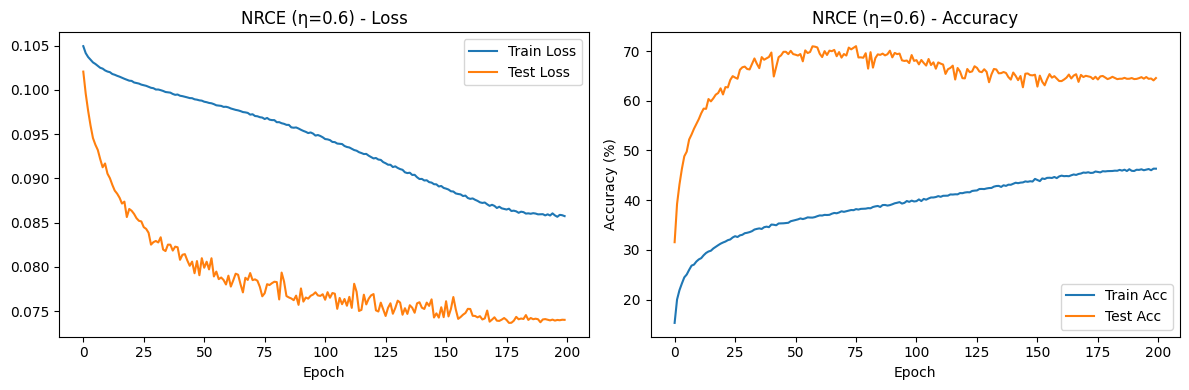


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 43.18% | Test Loss: 0.9300


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 51.48% | Test Loss: 0.8818


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 54.43% | Test Loss: 0.8800


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 56.21% | Test Loss: 0.8524


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 62.18% | Test Loss: 0.8372


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 62.42% | Test Loss: 0.8165


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 61.45% | Test Loss: 0.8274


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 59.81% | Test Loss: 0.8396


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 64.33% | Test Loss: 0.8134


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 66.27% | Test Loss: 0.8010


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 65.17% | Test Loss: 0.7960


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 66.46% | Test Loss: 0.8117


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 69.66% | Test Loss: 0.7922


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 68.52% | Test Loss: 0.7707


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 69.01% | Test Loss: 0.7917


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 71.24% | Test Loss: 0.7899


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 69.62% | Test Loss: 0.7662


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 72.27% | Test Loss: 0.7548


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 71.32% | Test Loss: 0.7524


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 71.99% | Test Loss: 0.7668


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 70.70% | Test Loss: 0.7470


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 72.28% | Test Loss: 0.7423


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 70.59% | Test Loss: 0.7473


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 71.31% | Test Loss: 0.7722


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 70.20% | Test Loss: 0.7396


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 72.82% | Test Loss: 0.7320


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 74.16% | Test Loss: 0.7365


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 70.04% | Test Loss: 0.7475


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 71.15% | Test Loss: 0.7253


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.83it/s]


Test Acc: 65.41% | Test Loss: 0.8068


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.05it/s]


Test Acc: 72.72% | Test Loss: 0.7634


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 70.73% | Test Loss: 0.7509


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 68.78% | Test Loss: 0.7555


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 71.51% | Test Loss: 0.7336


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 70.78% | Test Loss: 0.7378


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 70.45% | Test Loss: 0.7561


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 68.52% | Test Loss: 0.7542


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 68.48% | Test Loss: 0.7859


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 69.57% | Test Loss: 0.7302


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 70.98% | Test Loss: 0.7111


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 69.44% | Test Loss: 0.7431


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 68.19% | Test Loss: 0.7580


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 70.46% | Test Loss: 0.7349


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 69.00% | Test Loss: 0.7498


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 67.76% | Test Loss: 0.7721


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 68.79% | Test Loss: 0.7363


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 68.52% | Test Loss: 0.7552


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 67.11% | Test Loss: 0.7657


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 67.04% | Test Loss: 0.7213


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 67.93% | Test Loss: 0.7166


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 67.22% | Test Loss: 0.7362


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 66.09% | Test Loss: 0.7572


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 66.69% | Test Loss: 0.7310


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 68.70% | Test Loss: 0.6841


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 65.75% | Test Loss: 0.7114


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 68.36% | Test Loss: 0.7130


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 62.45% | Test Loss: 0.7497


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 65.42% | Test Loss: 0.7586


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 65.93% | Test Loss: 0.7302


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 65.97% | Test Loss: 0.7067


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 64.07% | Test Loss: 0.7522


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 61.15% | Test Loss: 0.7775


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 65.17% | Test Loss: 0.7280


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 66.08% | Test Loss: 0.6929


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 62.73% | Test Loss: 0.7445


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 60.98% | Test Loss: 0.7391


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 63.70% | Test Loss: 0.7216


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 65.17% | Test Loss: 0.7129


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 62.59% | Test Loss: 0.7461


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 63.05% | Test Loss: 0.7272


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 57.48% | Test Loss: 0.7765


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 61.89% | Test Loss: 0.7247


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 57.48% | Test Loss: 0.7758


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 61.88% | Test Loss: 0.7355


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 60.91% | Test Loss: 0.7342


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 59.84% | Test Loss: 0.7437


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 60.95% | Test Loss: 0.7289


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 57.01% | Test Loss: 0.7714


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 59.98% | Test Loss: 0.7297


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 58.27% | Test Loss: 0.7613


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 60.52% | Test Loss: 0.7176


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 56.83% | Test Loss: 0.7633


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 61.66% | Test Loss: 0.7115


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 57.08% | Test Loss: 0.7600


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 58.77% | Test Loss: 0.7314


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 59.62% | Test Loss: 0.7290


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 55.73% | Test Loss: 0.7759


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 54.79% | Test Loss: 0.7784


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 59.17% | Test Loss: 0.7344


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 57.06% | Test Loss: 0.7564


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 56.25% | Test Loss: 0.7574


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 58.09% | Test Loss: 0.7434


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 56.87% | Test Loss: 0.7529


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 55.54% | Test Loss: 0.7709


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 51.44% | Test Loss: 0.8054


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 55.04% | Test Loss: 0.7752


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 55.94% | Test Loss: 0.7575


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 51.47% | Test Loss: 0.8040


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 55.84% | Test Loss: 0.7698


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 53.89% | Test Loss: 0.7835


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 52.13% | Test Loss: 0.7979


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 55.66% | Test Loss: 0.7655


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 51.92% | Test Loss: 0.8016


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 54.71% | Test Loss: 0.7743


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 53.63% | Test Loss: 0.7888


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 54.58% | Test Loss: 0.7782


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 53.32% | Test Loss: 0.7927


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 50.79% | Test Loss: 0.8164


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 52.62% | Test Loss: 0.7970


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 51.95% | Test Loss: 0.8199


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 55.66% | Test Loss: 0.7725


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 49.97% | Test Loss: 0.8335


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 51.62% | Test Loss: 0.8111


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 52.54% | Test Loss: 0.8076


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 51.64% | Test Loss: 0.8157


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 47.59% | Test Loss: 0.8525


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 49.79% | Test Loss: 0.8353


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 51.47% | Test Loss: 0.8278


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 49.87% | Test Loss: 0.8408


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 46.32% | Test Loss: 0.8773


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 49.32% | Test Loss: 0.8477


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 50.42% | Test Loss: 0.8384


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 49.86% | Test Loss: 0.8385


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 49.66% | Test Loss: 0.8530


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 51.86% | Test Loss: 0.8281


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 48.38% | Test Loss: 0.8542


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 46.41% | Test Loss: 0.8797


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 49.47% | Test Loss: 0.8494


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 46.62% | Test Loss: 0.8831


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 50.41% | Test Loss: 0.8473


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 49.02% | Test Loss: 0.8584


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 50.70% | Test Loss: 0.8510


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 48.85% | Test Loss: 0.8617


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 48.57% | Test Loss: 0.8779


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 50.31% | Test Loss: 0.8604


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 48.43% | Test Loss: 0.8789


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 50.07% | Test Loss: 0.8723


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 49.56% | Test Loss: 0.8682


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 47.05% | Test Loss: 0.8970


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 49.73% | Test Loss: 0.8642


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 49.22% | Test Loss: 0.8763


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 48.04% | Test Loss: 0.8913


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 46.79% | Test Loss: 0.9070


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 48.45% | Test Loss: 0.8921


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 47.92% | Test Loss: 0.8967


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 45.19% | Test Loss: 0.9193


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 47.92% | Test Loss: 0.8999


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 48.29% | Test Loss: 0.9049


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 46.28% | Test Loss: 0.9328


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 47.06% | Test Loss: 0.9241


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 47.06% | Test Loss: 0.9109


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 46.95% | Test Loss: 0.9268


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 49.56% | Test Loss: 0.8983


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 46.94% | Test Loss: 0.9198


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 47.64% | Test Loss: 0.9178


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 46.56% | Test Loss: 0.9313


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 47.66% | Test Loss: 0.9187


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 47.68% | Test Loss: 0.9228


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 47.19% | Test Loss: 0.9255


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.90it/s]


Test Acc: 48.09% | Test Loss: 0.9235


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 48.53% | Test Loss: 0.9239


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 46.87% | Test Loss: 0.9388


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 47.38% | Test Loss: 0.9390


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 47.89% | Test Loss: 0.9268


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 47.50% | Test Loss: 0.9383


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 48.10% | Test Loss: 0.9373


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 47.63% | Test Loss: 0.9378


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 47.07% | Test Loss: 0.9463


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 47.45% | Test Loss: 0.9425


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 46.02% | Test Loss: 0.9585


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 47.04% | Test Loss: 0.9419


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 47.38% | Test Loss: 0.9460


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 46.43% | Test Loss: 0.9582


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 46.47% | Test Loss: 0.9567


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 46.56% | Test Loss: 0.9547


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 47.01% | Test Loss: 0.9568


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 47.24% | Test Loss: 0.9552


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 46.60% | Test Loss: 0.9590


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 46.98% | Test Loss: 0.9530


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 46.80% | Test Loss: 0.9599


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 46.55% | Test Loss: 0.9620


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 45.95% | Test Loss: 0.9667


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 46.63% | Test Loss: 0.9578


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 46.21% | Test Loss: 0.9607


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 46.53% | Test Loss: 0.9619


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 46.55% | Test Loss: 0.9646


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 46.69% | Test Loss: 0.9597


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 46.55% | Test Loss: 0.9665


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 46.53% | Test Loss: 0.9605


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 46.11% | Test Loss: 0.9620


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 46.66% | Test Loss: 0.9629


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 46.78% | Test Loss: 0.9632


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 46.43% | Test Loss: 0.9647


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 46.88% | Test Loss: 0.9634


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 46.86% | Test Loss: 0.9662


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 46.91% | Test Loss: 0.9601


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 46.67% | Test Loss: 0.9624


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 46.75% | Test Loss: 0.9623


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 46.63% | Test Loss: 0.9662


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 47.05% | Test Loss: 0.9626


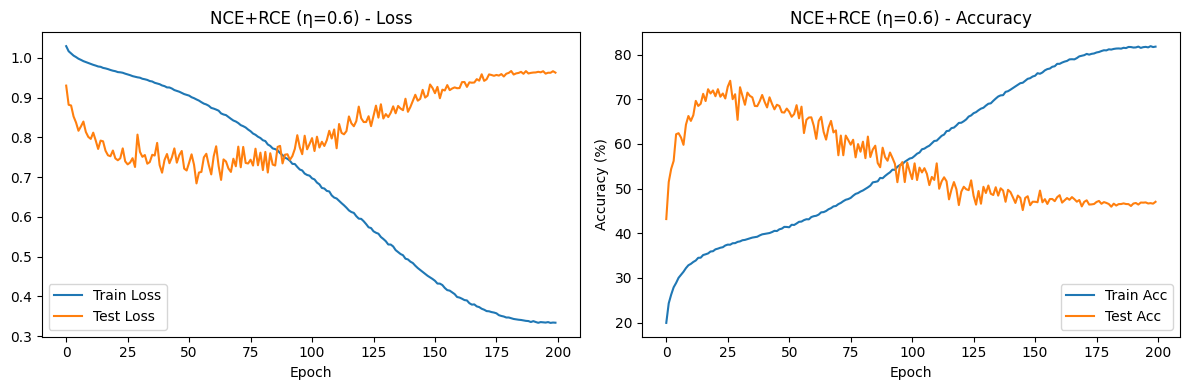

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 46.25% | Test Loss: 0.9212


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 51.65% | Test Loss: 0.8777


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 56.02% | Test Loss: 0.8649


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 55.69% | Test Loss: 0.8729


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 61.12% | Test Loss: 0.8575


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 60.52% | Test Loss: 0.8330


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 59.92% | Test Loss: 0.8205


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 65.65% | Test Loss: 0.8006


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 66.32% | Test Loss: 0.7988


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 63.47% | Test Loss: 0.7879


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 65.62% | Test Loss: 0.7907


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 69.36% | Test Loss: 0.7893


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 67.34% | Test Loss: 0.7885


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 67.48% | Test Loss: 0.7887


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 67.73% | Test Loss: 0.7886


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 69.52% | Test Loss: 0.7592


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 66.88% | Test Loss: 0.8073


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 70.99% | Test Loss: 0.7546


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 70.71% | Test Loss: 0.7561


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 70.60% | Test Loss: 0.7973


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 72.77% | Test Loss: 0.7458


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 71.34% | Test Loss: 0.7251


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 69.15% | Test Loss: 0.7553


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 69.29% | Test Loss: 0.7588


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 73.07% | Test Loss: 0.7236


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.66it/s]


Test Acc: 71.75% | Test Loss: 0.7397


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 72.30% | Test Loss: 0.7289


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 71.53% | Test Loss: 0.7423


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 72.92% | Test Loss: 0.7445


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 72.59% | Test Loss: 0.6949


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 72.26% | Test Loss: 0.7328


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.94it/s]


Test Acc: 72.06% | Test Loss: 0.7351


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 71.64% | Test Loss: 0.7287


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 69.97% | Test Loss: 0.7344


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 71.21% | Test Loss: 0.7391


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 71.60% | Test Loss: 0.7382


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 71.56% | Test Loss: 0.6975


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 68.79% | Test Loss: 0.7731


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 70.83% | Test Loss: 0.7434


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 71.79% | Test Loss: 0.7171


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 68.27% | Test Loss: 0.7611


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 69.19% | Test Loss: 0.7388


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 69.38% | Test Loss: 0.7312


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 69.06% | Test Loss: 0.7332


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 71.17% | Test Loss: 0.7150


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 68.98% | Test Loss: 0.7428


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 69.85% | Test Loss: 0.7428


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 65.13% | Test Loss: 0.7499


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 66.24% | Test Loss: 0.7469


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 68.53% | Test Loss: 0.7277


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 67.84% | Test Loss: 0.7053


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 68.47% | Test Loss: 0.7121


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 65.31% | Test Loss: 0.7320


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 64.62% | Test Loss: 0.7528


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 66.57% | Test Loss: 0.7319


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 66.29% | Test Loss: 0.7407


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 66.03% | Test Loss: 0.7315


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 64.40% | Test Loss: 0.7564


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 66.58% | Test Loss: 0.7200


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 63.01% | Test Loss: 0.7480


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.69it/s]


Test Acc: 65.60% | Test Loss: 0.7166


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 62.61% | Test Loss: 0.7280


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 60.06% | Test Loss: 0.7484


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 62.95% | Test Loss: 0.7421


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 57.74% | Test Loss: 0.7874


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 62.01% | Test Loss: 0.7417


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 60.90% | Test Loss: 0.7395


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 59.59% | Test Loss: 0.7735


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 64.17% | Test Loss: 0.7005


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 61.07% | Test Loss: 0.7440


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.03it/s]


Test Acc: 62.24% | Test Loss: 0.7184


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 61.45% | Test Loss: 0.7324


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 60.75% | Test Loss: 0.7316


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 62.06% | Test Loss: 0.7198


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 58.98% | Test Loss: 0.7562


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 58.13% | Test Loss: 0.7724


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.78it/s]


Test Acc: 61.71% | Test Loss: 0.7198


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 57.23% | Test Loss: 0.7601


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 59.25% | Test Loss: 0.7355


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 53.77% | Test Loss: 0.7906


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 60.98% | Test Loss: 0.7259


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 56.81% | Test Loss: 0.7515


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 58.19% | Test Loss: 0.7392


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 56.83% | Test Loss: 0.7548


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 58.35% | Test Loss: 0.7456


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 57.79% | Test Loss: 0.7408


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 55.21% | Test Loss: 0.7726


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 56.64% | Test Loss: 0.7500


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 57.96% | Test Loss: 0.7396


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 56.03% | Test Loss: 0.7571


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 57.42% | Test Loss: 0.7458


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 56.56% | Test Loss: 0.7559


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 55.04% | Test Loss: 0.7668


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 54.28% | Test Loss: 0.7784


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 57.15% | Test Loss: 0.7488


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 56.34% | Test Loss: 0.7469


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 53.28% | Test Loss: 0.7806


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 54.50% | Test Loss: 0.7713


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 52.87% | Test Loss: 0.7835


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 54.35% | Test Loss: 0.7695


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 55.82% | Test Loss: 0.7608


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 55.38% | Test Loss: 0.7540


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 53.15% | Test Loss: 0.7837


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 55.90% | Test Loss: 0.7566


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 51.88% | Test Loss: 0.8012


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 54.53% | Test Loss: 0.7664


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 51.17% | Test Loss: 0.8014


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 54.36% | Test Loss: 0.7737


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 53.20% | Test Loss: 0.7876


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 53.82% | Test Loss: 0.7811


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 50.56% | Test Loss: 0.8137


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 51.75% | Test Loss: 0.7953


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 51.35% | Test Loss: 0.8045


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 51.48% | Test Loss: 0.7988


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 53.56% | Test Loss: 0.7972


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 52.37% | Test Loss: 0.8032


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 51.51% | Test Loss: 0.8034


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 48.72% | Test Loss: 0.8385


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 52.56% | Test Loss: 0.8096


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 49.70% | Test Loss: 0.8191


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 51.38% | Test Loss: 0.8137


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 49.57% | Test Loss: 0.8280


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 50.63% | Test Loss: 0.8272


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 50.38% | Test Loss: 0.8280


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 50.66% | Test Loss: 0.8324


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 51.28% | Test Loss: 0.8271


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 50.52% | Test Loss: 0.8395


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 50.90% | Test Loss: 0.8328


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 49.39% | Test Loss: 0.8433


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 48.24% | Test Loss: 0.8559


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 50.70% | Test Loss: 0.8356


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 46.87% | Test Loss: 0.8735


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 49.25% | Test Loss: 0.8622


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 50.08% | Test Loss: 0.8542


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 48.29% | Test Loss: 0.8695


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 46.70% | Test Loss: 0.8747


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 50.39% | Test Loss: 0.8544


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 51.63% | Test Loss: 0.8342


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 47.17% | Test Loss: 0.8820


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 46.54% | Test Loss: 0.8940


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 47.16% | Test Loss: 0.8788


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 48.18% | Test Loss: 0.8793


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 48.93% | Test Loss: 0.8677


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 50.06% | Test Loss: 0.8642


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 49.48% | Test Loss: 0.8738


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 49.82% | Test Loss: 0.8736


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 47.42% | Test Loss: 0.8989


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 50.26% | Test Loss: 0.8748


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.85it/s]


Test Acc: 46.60% | Test Loss: 0.9033


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 49.35% | Test Loss: 0.8843


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 47.01% | Test Loss: 0.9091


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 47.73% | Test Loss: 0.9049


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 47.56% | Test Loss: 0.9061


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 48.76% | Test Loss: 0.9089


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 46.64% | Test Loss: 0.9133


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 48.56% | Test Loss: 0.8946


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 48.92% | Test Loss: 0.8915


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 47.64% | Test Loss: 0.9084


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 47.36% | Test Loss: 0.9128


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 49.28% | Test Loss: 0.8905


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 46.46% | Test Loss: 0.9292


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 47.59% | Test Loss: 0.9201


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 47.27% | Test Loss: 0.9224


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 47.43% | Test Loss: 0.9236


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 47.97% | Test Loss: 0.9170


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 47.54% | Test Loss: 0.9250


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 47.79% | Test Loss: 0.9227


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 47.12% | Test Loss: 0.9237


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.94it/s]


Test Acc: 46.06% | Test Loss: 0.9412


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 46.83% | Test Loss: 0.9394


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 47.33% | Test Loss: 0.9339


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 47.52% | Test Loss: 0.9294


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 47.26% | Test Loss: 0.9378


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 46.41% | Test Loss: 0.9426


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 47.89% | Test Loss: 0.9324


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 48.11% | Test Loss: 0.9305


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 47.51% | Test Loss: 0.9341


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 47.00% | Test Loss: 0.9403


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 47.23% | Test Loss: 0.9403


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 46.96% | Test Loss: 0.9398


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 46.94% | Test Loss: 0.9439


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 46.93% | Test Loss: 0.9450


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 47.26% | Test Loss: 0.9400


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 47.30% | Test Loss: 0.9411


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 46.94% | Test Loss: 0.9459


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 46.88% | Test Loss: 0.9441


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 47.17% | Test Loss: 0.9423


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 47.06% | Test Loss: 0.9421


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 47.09% | Test Loss: 0.9438


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 46.46% | Test Loss: 0.9494


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 47.18% | Test Loss: 0.9450


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 46.41% | Test Loss: 0.9510


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 46.74% | Test Loss: 0.9478


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 46.93% | Test Loss: 0.9459


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 46.78% | Test Loss: 0.9456


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 47.20% | Test Loss: 0.9439


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 47.06% | Test Loss: 0.9445


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 46.58% | Test Loss: 0.9473


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 46.77% | Test Loss: 0.9461


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 47.31% | Test Loss: 0.9443


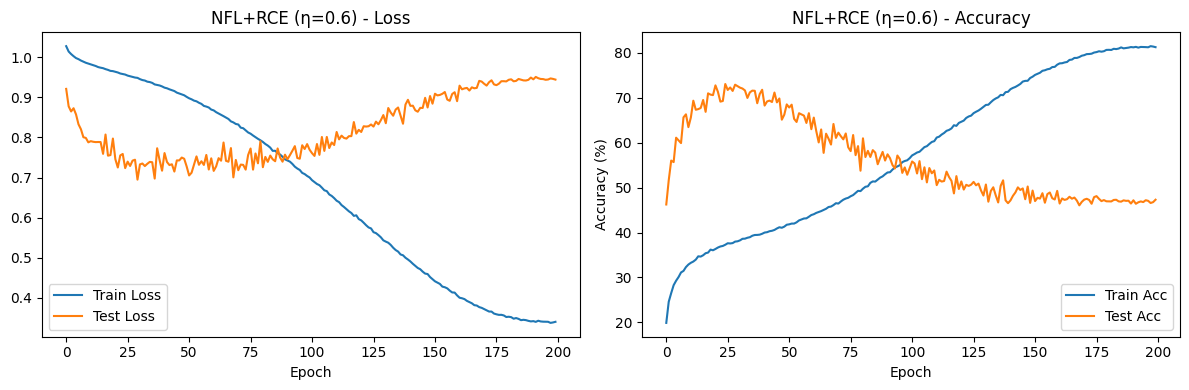

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 38.94% | Test Loss: 1.6312


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 43.84% | Test Loss: 1.5350


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 53.73% | Test Loss: 1.4501


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 58.88% | Test Loss: 1.3679


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 63.44% | Test Loss: 1.3565


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 61.77% | Test Loss: 1.3418


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 65.85% | Test Loss: 1.3128


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 65.54% | Test Loss: 1.3082


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 64.68% | Test Loss: 1.3267


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 66.46% | Test Loss: 1.2382


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 68.77% | Test Loss: 1.2709


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 68.27% | Test Loss: 1.2296


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 69.98% | Test Loss: 1.2570


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 70.54% | Test Loss: 1.2321


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.74% | Test Loss: 1.2186


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 71.10% | Test Loss: 1.2714


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 73.76% | Test Loss: 1.2219


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 72.80% | Test Loss: 1.2537


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 70.30% | Test Loss: 1.2383


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 71.30% | Test Loss: 1.1971


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 71.10% | Test Loss: 1.1641


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 72.56% | Test Loss: 1.1705


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 73.96% | Test Loss: 1.1810


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 70.30% | Test Loss: 1.2521


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 72.84% | Test Loss: 1.1875


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 72.46% | Test Loss: 1.1842


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 73.93% | Test Loss: 1.1526


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 69.52% | Test Loss: 1.2121


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 73.28% | Test Loss: 1.1753


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 71.64% | Test Loss: 1.2258


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 74.48% | Test Loss: 1.1319


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 71.35% | Test Loss: 1.2087


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 72.70% | Test Loss: 1.1177


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 72.29% | Test Loss: 1.1624


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 71.27% | Test Loss: 1.1807


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 73.17% | Test Loss: 1.1770


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 72.15% | Test Loss: 1.1530


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 74.23% | Test Loss: 1.0841


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 72.06% | Test Loss: 1.2071


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 71.99% | Test Loss: 1.1353


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 73.72% | Test Loss: 1.1232


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 68.58% | Test Loss: 1.2099


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 71.96% | Test Loss: 1.1582


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 68.85% | Test Loss: 1.2222


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 69.97% | Test Loss: 1.1855


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 72.36% | Test Loss: 1.1440


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 71.14% | Test Loss: 1.1903


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 70.50% | Test Loss: 1.1580


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 70.83% | Test Loss: 1.1305


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 69.68% | Test Loss: 1.1461


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 68.57% | Test Loss: 1.2012


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 68.70% | Test Loss: 1.1732


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 70.96% | Test Loss: 1.1222


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 69.70% | Test Loss: 1.1603


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 67.44% | Test Loss: 1.2063


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 69.85% | Test Loss: 1.1599


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 69.34% | Test Loss: 1.1060


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 68.72% | Test Loss: 1.1387


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 66.84% | Test Loss: 1.1744


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 68.31% | Test Loss: 1.1381


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 64.15% | Test Loss: 1.2243


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 65.23% | Test Loss: 1.2078


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 66.05% | Test Loss: 1.1694


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 68.10% | Test Loss: 1.0848


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 65.09% | Test Loss: 1.2219


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 64.54% | Test Loss: 1.1862


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 63.89% | Test Loss: 1.2054


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 63.78% | Test Loss: 1.1652


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 63.46% | Test Loss: 1.1947


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 64.28% | Test Loss: 1.1844


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 65.10% | Test Loss: 1.1781


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 61.62% | Test Loss: 1.2544


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 61.70% | Test Loss: 1.2392


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 63.31% | Test Loss: 1.1727


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 60.82% | Test Loss: 1.2461


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 62.40% | Test Loss: 1.2057


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 61.82% | Test Loss: 1.2102


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 61.28% | Test Loss: 1.2161


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 61.10% | Test Loss: 1.2291


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 60.56% | Test Loss: 1.2141


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 60.08% | Test Loss: 1.2293


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 60.94% | Test Loss: 1.2175


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 57.94% | Test Loss: 1.2692


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 61.00% | Test Loss: 1.1876


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 59.19% | Test Loss: 1.2427


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 58.41% | Test Loss: 1.2513


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 60.16% | Test Loss: 1.2123


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 57.25% | Test Loss: 1.2786


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 59.53% | Test Loss: 1.2357


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 59.10% | Test Loss: 1.2356


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 56.83% | Test Loss: 1.2734


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 58.50% | Test Loss: 1.2648


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 55.66% | Test Loss: 1.3110


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 56.18% | Test Loss: 1.2912


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 56.94% | Test Loss: 1.2713


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 57.82% | Test Loss: 1.2538


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 56.34% | Test Loss: 1.2853


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 54.11% | Test Loss: 1.3294


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 53.92% | Test Loss: 1.3227


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 54.07% | Test Loss: 1.3117


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 57.09% | Test Loss: 1.2618


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 56.21% | Test Loss: 1.2837


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 54.95% | Test Loss: 1.3028


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 53.94% | Test Loss: 1.3202


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 51.69% | Test Loss: 1.3701


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 54.56% | Test Loss: 1.3238


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 55.74% | Test Loss: 1.2943


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 53.49% | Test Loss: 1.3391


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 51.43% | Test Loss: 1.3766


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 50.98% | Test Loss: 1.3790


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 51.27% | Test Loss: 1.3915


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 53.61% | Test Loss: 1.3411


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 51.60% | Test Loss: 1.3740


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 51.98% | Test Loss: 1.3713


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 53.14% | Test Loss: 1.3448


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 51.75% | Test Loss: 1.3847


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 50.63% | Test Loss: 1.4052


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 52.43% | Test Loss: 1.3665


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 51.72% | Test Loss: 1.3745


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 52.04% | Test Loss: 1.3895


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 47.10% | Test Loss: 1.4753


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 51.76% | Test Loss: 1.3875


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 51.92% | Test Loss: 1.3843


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 50.96% | Test Loss: 1.4140


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 50.35% | Test Loss: 1.4168


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 49.41% | Test Loss: 1.4265


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 52.00% | Test Loss: 1.3868


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 52.30% | Test Loss: 1.3808


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 50.10% | Test Loss: 1.4266


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 49.99% | Test Loss: 1.4374


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 52.10% | Test Loss: 1.3879


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 49.08% | Test Loss: 1.4514


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 46.56% | Test Loss: 1.4896


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 49.24% | Test Loss: 1.4484


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 49.71% | Test Loss: 1.4475


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 50.17% | Test Loss: 1.4360


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 49.14% | Test Loss: 1.4533


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 49.40% | Test Loss: 1.4452


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 50.87% | Test Loss: 1.4250


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 50.25% | Test Loss: 1.4396


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 49.79% | Test Loss: 1.4567


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 50.21% | Test Loss: 1.4599


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 49.76% | Test Loss: 1.4650


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 49.23% | Test Loss: 1.4713


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 47.73% | Test Loss: 1.4998


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 49.01% | Test Loss: 1.4690


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 47.90% | Test Loss: 1.4996


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 46.42% | Test Loss: 1.5192


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 47.24% | Test Loss: 1.5096


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 48.17% | Test Loss: 1.5030


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 48.97% | Test Loss: 1.4850


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 47.75% | Test Loss: 1.5098


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 47.24% | Test Loss: 1.5224


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 48.94% | Test Loss: 1.4764


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 48.78% | Test Loss: 1.5063


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 48.38% | Test Loss: 1.5029


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 47.65% | Test Loss: 1.5354


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 47.05% | Test Loss: 1.5372


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 49.02% | Test Loss: 1.4985


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 47.53% | Test Loss: 1.5303


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 48.70% | Test Loss: 1.5065


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 48.02% | Test Loss: 1.5243


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 47.80% | Test Loss: 1.5346


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 48.31% | Test Loss: 1.5255


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 47.19% | Test Loss: 1.5397


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 47.52% | Test Loss: 1.5396


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 47.80% | Test Loss: 1.5296


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 48.69% | Test Loss: 1.5171


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 48.08% | Test Loss: 1.5325


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 47.78% | Test Loss: 1.5291


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 48.02% | Test Loss: 1.5322


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 47.16% | Test Loss: 1.5544


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 47.82% | Test Loss: 1.5371


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 47.85% | Test Loss: 1.5393


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 47.33% | Test Loss: 1.5518


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 47.07% | Test Loss: 1.5556


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 47.10% | Test Loss: 1.5494


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 47.22% | Test Loss: 1.5522


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 47.47% | Test Loss: 1.5484


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 47.51% | Test Loss: 1.5525


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 48.21% | Test Loss: 1.5414


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 47.39% | Test Loss: 1.5499


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 47.24% | Test Loss: 1.5569


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 47.51% | Test Loss: 1.5512


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 47.47% | Test Loss: 1.5517


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 47.21% | Test Loss: 1.5554


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 47.81% | Test Loss: 1.5466


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 47.36% | Test Loss: 1.5539


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 47.19% | Test Loss: 1.5559


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 47.42% | Test Loss: 1.5520


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 47.34% | Test Loss: 1.5534


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 47.32% | Test Loss: 1.5508


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 47.49% | Test Loss: 1.5510


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 47.30% | Test Loss: 1.5547


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 47.23% | Test Loss: 1.5567


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 47.05% | Test Loss: 1.5536


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 47.38% | Test Loss: 1.5527


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 47.25% | Test Loss: 1.5544


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 47.56% | Test Loss: 1.5521


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 47.40% | Test Loss: 1.5508


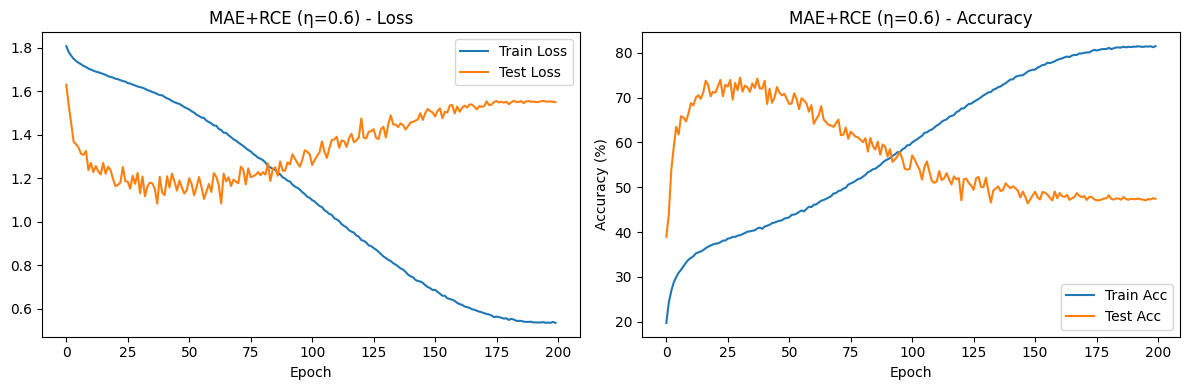


Noise Rate: 0.8

Training vanilla Losses...
 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 33.80% | Test Loss: 0.9227


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 42.62% | Test Loss: 0.9119


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 43.15% | Test Loss: 0.9057


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 46.73% | Test Loss: 0.8998


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 43.96% | Test Loss: 0.9009


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 47.62% | Test Loss: 0.8946


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 50.22% | Test Loss: 0.8948


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 49.38% | Test Loss: 0.8956


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 51.68% | Test Loss: 0.8781


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 51.76% | Test Loss: 0.8862


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 53.23% | Test Loss: 0.8832


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 55.41% | Test Loss: 0.8820


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 51.22% | Test Loss: 0.8757


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 56.04% | Test Loss: 0.8750


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 55.75% | Test Loss: 0.8827


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 56.57% | Test Loss: 0.8664


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 56.36% | Test Loss: 0.8643


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 56.68% | Test Loss: 0.8752


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 57.13% | Test Loss: 0.8642


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 57.42% | Test Loss: 0.8582


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 56.85% | Test Loss: 0.8652


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 57.77% | Test Loss: 0.8655


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 57.31% | Test Loss: 0.8567


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 57.66% | Test Loss: 0.8564


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 56.43% | Test Loss: 0.8577


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 57.04% | Test Loss: 0.8579


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 57.01% | Test Loss: 0.8510


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 51.63% | Test Loss: 0.8566


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 55.68% | Test Loss: 0.8664


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 57.16% | Test Loss: 0.8575


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 58.08% | Test Loss: 0.8510


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 55.10% | Test Loss: 0.8616


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 56.12% | Test Loss: 0.8421


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 54.47% | Test Loss: 0.8532


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 54.24% | Test Loss: 0.8571


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 55.64% | Test Loss: 0.8466


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 56.13% | Test Loss: 0.8528


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 52.83% | Test Loss: 0.8467


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 51.86% | Test Loss: 0.8677


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 50.24% | Test Loss: 0.8612


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 54.63% | Test Loss: 0.8383


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 52.59% | Test Loss: 0.8464


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 52.13% | Test Loss: 0.8631


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 55.12% | Test Loss: 0.8480


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 50.99% | Test Loss: 0.8600


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 51.77% | Test Loss: 0.8371


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 52.05% | Test Loss: 0.8500


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 53.69% | Test Loss: 0.8425


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 52.48% | Test Loss: 0.8314


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 50.62% | Test Loss: 0.8387


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 50.94% | Test Loss: 0.8385


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 52.15% | Test Loss: 0.8435


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 48.54% | Test Loss: 0.8565


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 46.05% | Test Loss: 0.8625


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 49.63% | Test Loss: 0.8345


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 49.28% | Test Loss: 0.8469


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 48.95% | Test Loss: 0.8315


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 51.82% | Test Loss: 0.8299


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 45.68% | Test Loss: 0.8558


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 45.64% | Test Loss: 0.8451


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 44.79% | Test Loss: 0.8504


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 45.85% | Test Loss: 0.8502


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 43.82% | Test Loss: 0.8518


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 43.85% | Test Loss: 0.8544


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 43.36% | Test Loss: 0.8565


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 45.33% | Test Loss: 0.8357


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 40.25% | Test Loss: 0.8638


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 40.03% | Test Loss: 0.8691


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 41.19% | Test Loss: 0.8540


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 40.26% | Test Loss: 0.8578


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 40.89% | Test Loss: 0.8579


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 41.90% | Test Loss: 0.8483


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 44.78% | Test Loss: 0.8325


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 42.15% | Test Loss: 0.8475


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 42.43% | Test Loss: 0.8446


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 44.25% | Test Loss: 0.8334


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 39.83% | Test Loss: 0.8503


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 41.56% | Test Loss: 0.8458


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 36.86% | Test Loss: 0.8694


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 37.76% | Test Loss: 0.8608


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 40.27% | Test Loss: 0.8458


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 39.13% | Test Loss: 0.8549


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 37.51% | Test Loss: 0.8634


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 41.45% | Test Loss: 0.8431


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 41.91% | Test Loss: 0.8376


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 37.36% | Test Loss: 0.8642


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 37.08% | Test Loss: 0.8644


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 36.79% | Test Loss: 0.8645


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 38.29% | Test Loss: 0.8512


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 34.72% | Test Loss: 0.8779


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 36.28% | Test Loss: 0.8669


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 37.09% | Test Loss: 0.8646


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 35.63% | Test Loss: 0.8749


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 33.34% | Test Loss: 0.8833


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 34.29% | Test Loss: 0.8844


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 31.44% | Test Loss: 0.8982


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 33.61% | Test Loss: 0.8841


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 36.95% | Test Loss: 0.8660


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 35.98% | Test Loss: 0.8719


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 33.41% | Test Loss: 0.8894


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 33.33% | Test Loss: 0.8881


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 33.06% | Test Loss: 0.8936


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 32.00% | Test Loss: 0.8980


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 32.92% | Test Loss: 0.8960


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 31.97% | Test Loss: 0.9008


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 32.86% | Test Loss: 0.9007


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 35.67% | Test Loss: 0.8809


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 30.57% | Test Loss: 0.9117


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 31.86% | Test Loss: 0.9080


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 30.56% | Test Loss: 0.9156


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 31.46% | Test Loss: 0.9093


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 31.46% | Test Loss: 0.9070


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 31.71% | Test Loss: 0.9119


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 31.85% | Test Loss: 0.9123


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 34.33% | Test Loss: 0.8974


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 30.47% | Test Loss: 0.9259


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 29.87% | Test Loss: 0.9268


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 32.23% | Test Loss: 0.9284


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 30.08% | Test Loss: 0.9379


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 30.60% | Test Loss: 0.9293


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 30.14% | Test Loss: 0.9340


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 31.61% | Test Loss: 0.9228


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 32.65% | Test Loss: 0.9183


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 31.51% | Test Loss: 0.9240


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 31.43% | Test Loss: 0.9366


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 31.91% | Test Loss: 0.9340


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 29.52% | Test Loss: 0.9526


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 30.64% | Test Loss: 0.9422


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 27.71% | Test Loss: 0.9714


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 29.27% | Test Loss: 0.9662


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 29.86% | Test Loss: 0.9600


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 31.43% | Test Loss: 0.9623


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 29.31% | Test Loss: 0.9724


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 28.30% | Test Loss: 0.9833


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 30.53% | Test Loss: 0.9648


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 28.21% | Test Loss: 0.9853


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 28.33% | Test Loss: 0.9790


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 31.85% | Test Loss: 0.9638


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 28.92% | Test Loss: 0.9998


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 28.53% | Test Loss: 0.9921


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 29.64% | Test Loss: 0.9831


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 26.82% | Test Loss: 1.0073


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 30.60% | Test Loss: 0.9850


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 31.13% | Test Loss: 0.9809


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 30.53% | Test Loss: 0.9878


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 27.21% | Test Loss: 1.0110


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 29.41% | Test Loss: 1.0027


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 30.26% | Test Loss: 0.9943


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 28.03% | Test Loss: 1.0208


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 28.98% | Test Loss: 1.0039


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 29.70% | Test Loss: 1.0065


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 28.08% | Test Loss: 1.0168


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 29.37% | Test Loss: 1.0103


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 27.98% | Test Loss: 1.0295


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 31.04% | Test Loss: 1.0060


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 29.45% | Test Loss: 1.0181


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 28.59% | Test Loss: 1.0300


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 29.04% | Test Loss: 1.0386


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 29.32% | Test Loss: 1.0352


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 29.63% | Test Loss: 1.0311


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 28.85% | Test Loss: 1.0422


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 28.31% | Test Loss: 1.0432


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 29.40% | Test Loss: 1.0329


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 28.97% | Test Loss: 1.0500


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 29.32% | Test Loss: 1.0463


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 28.10% | Test Loss: 1.0465


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 28.80% | Test Loss: 1.0465


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 28.44% | Test Loss: 1.0558


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 28.38% | Test Loss: 1.0566


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 29.02% | Test Loss: 1.0521


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 29.13% | Test Loss: 1.0516


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 26.96% | Test Loss: 1.0672


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 28.29% | Test Loss: 1.0628


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 28.26% | Test Loss: 1.0684


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 28.29% | Test Loss: 1.0717


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 27.87% | Test Loss: 1.0746


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 28.24% | Test Loss: 1.0732


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 29.43% | Test Loss: 1.0635


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 28.43% | Test Loss: 1.0733


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 27.87% | Test Loss: 1.0731


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 28.33% | Test Loss: 1.0743


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 28.01% | Test Loss: 1.0763


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 29.02% | Test Loss: 1.0739


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 28.26% | Test Loss: 1.0747


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 28.34% | Test Loss: 1.0752


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 28.58% | Test Loss: 1.0721


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 28.76% | Test Loss: 1.0715


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 28.48% | Test Loss: 1.0729


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 28.81% | Test Loss: 1.0758


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 28.53% | Test Loss: 1.0760


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 28.56% | Test Loss: 1.0775


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 28.63% | Test Loss: 1.0734


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 28.36% | Test Loss: 1.0768


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 28.66% | Test Loss: 1.0785


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 28.55% | Test Loss: 1.0771


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 28.45% | Test Loss: 1.0799


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 28.43% | Test Loss: 1.0770


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 28.35% | Test Loss: 1.0784


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 28.50% | Test Loss: 1.0759


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 28.46% | Test Loss: 1.0782


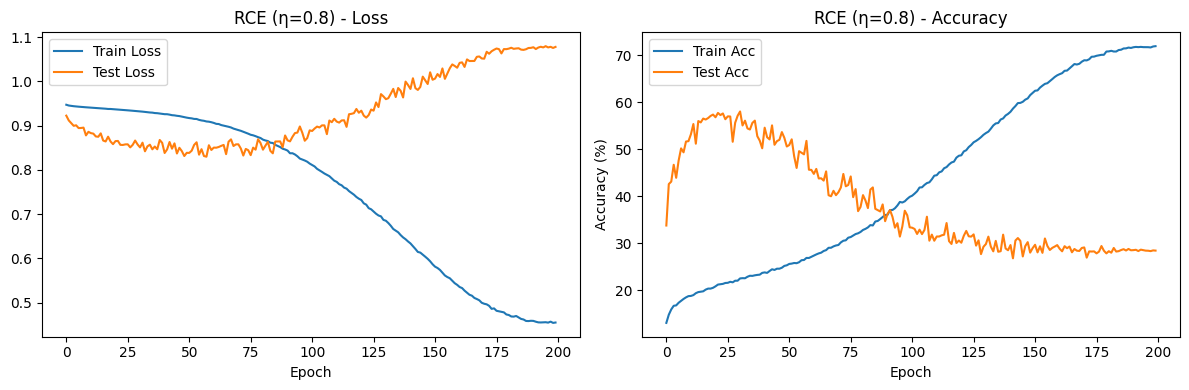


Training normalized Losses...
 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 27.85% | Test Loss: 0.1040


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 33.61% | Test Loss: 0.1031


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 35.59% | Test Loss: 0.1025


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 38.21% | Test Loss: 0.1022


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 39.12% | Test Loss: 0.1018


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 40.58% | Test Loss: 0.1015


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.74it/s]


Test Acc: 41.69% | Test Loss: 0.1014


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 42.78% | Test Loss: 0.1010


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 42.79% | Test Loss: 0.1009


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 44.34% | Test Loss: 0.1005


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 43.82% | Test Loss: 0.1006


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 45.78% | Test Loss: 0.1002


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 44.95% | Test Loss: 0.0999


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 47.09% | Test Loss: 0.0999


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 46.23% | Test Loss: 0.0998


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 47.64% | Test Loss: 0.0996


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 48.56% | Test Loss: 0.0995


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 47.88% | Test Loss: 0.0992


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 48.58% | Test Loss: 0.0991


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 49.15% | Test Loss: 0.0992


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 50.13% | Test Loss: 0.0988


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 49.95% | Test Loss: 0.0985


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 49.50% | Test Loss: 0.0990


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 50.71% | Test Loss: 0.0987


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 50.14% | Test Loss: 0.0984


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 50.89% | Test Loss: 0.0985


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 51.27% | Test Loss: 0.0983


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 51.76% | Test Loss: 0.0982


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 52.04% | Test Loss: 0.0982


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 53.03% | Test Loss: 0.0982


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 53.01% | Test Loss: 0.0980


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 52.73% | Test Loss: 0.0979


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 53.75% | Test Loss: 0.0980


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 53.83% | Test Loss: 0.0977


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 54.44% | Test Loss: 0.0974


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 53.61% | Test Loss: 0.0975


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 54.58% | Test Loss: 0.0972


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 55.17% | Test Loss: 0.0973


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 53.22% | Test Loss: 0.0971


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 54.76% | Test Loss: 0.0975


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 55.24% | Test Loss: 0.0971


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 55.30% | Test Loss: 0.0970


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 55.85% | Test Loss: 0.0970


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 54.76% | Test Loss: 0.0972


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 56.09% | Test Loss: 0.0970


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 56.50% | Test Loss: 0.0970


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 56.12% | Test Loss: 0.0965


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 56.79% | Test Loss: 0.0966


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 55.95% | Test Loss: 0.0967


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 57.46% | Test Loss: 0.0964


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 56.72% | Test Loss: 0.0964


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 56.77% | Test Loss: 0.0964


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 57.03% | Test Loss: 0.0963


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 56.24% | Test Loss: 0.0964


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 57.69% | Test Loss: 0.0964


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 56.34% | Test Loss: 0.0963


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 57.44% | Test Loss: 0.0959


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 58.47% | Test Loss: 0.0958


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 56.79% | Test Loss: 0.0962


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 57.85% | Test Loss: 0.0960


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 56.65% | Test Loss: 0.0956


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 57.65% | Test Loss: 0.0956


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 57.06% | Test Loss: 0.0956


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 58.36% | Test Loss: 0.0953


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 58.03% | Test Loss: 0.0957


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 57.95% | Test Loss: 0.0952


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 58.03% | Test Loss: 0.0952


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 57.37% | Test Loss: 0.0954


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 59.24% | Test Loss: 0.0954


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 59.10% | Test Loss: 0.0951


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 57.93% | Test Loss: 0.0953


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 59.31% | Test Loss: 0.0951


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 59.05% | Test Loss: 0.0951


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 58.31% | Test Loss: 0.0950


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 58.65% | Test Loss: 0.0952


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 58.97% | Test Loss: 0.0950


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 58.00% | Test Loss: 0.0953


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 58.51% | Test Loss: 0.0949


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 57.89% | Test Loss: 0.0948


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 58.42% | Test Loss: 0.0955


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 59.08% | Test Loss: 0.0948


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 59.02% | Test Loss: 0.0949


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 58.29% | Test Loss: 0.0951


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 58.48% | Test Loss: 0.0947


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 59.27% | Test Loss: 0.0949


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 58.15% | Test Loss: 0.0948


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 58.97% | Test Loss: 0.0948


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 58.51% | Test Loss: 0.0943


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 58.90% | Test Loss: 0.0945


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 58.83% | Test Loss: 0.0943


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 59.35% | Test Loss: 0.0946


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 58.90% | Test Loss: 0.0945


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 58.66% | Test Loss: 0.0943


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 58.64% | Test Loss: 0.0947


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 59.11% | Test Loss: 0.0942


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 57.02% | Test Loss: 0.0947


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 59.39% | Test Loss: 0.0942


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 59.00% | Test Loss: 0.0937


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 58.52% | Test Loss: 0.0941


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 58.15% | Test Loss: 0.0943


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 58.93% | Test Loss: 0.0938


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 59.14% | Test Loss: 0.0944


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 57.95% | Test Loss: 0.0939


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 59.12% | Test Loss: 0.0941


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 59.12% | Test Loss: 0.0939


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 59.77% | Test Loss: 0.0934


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 58.68% | Test Loss: 0.0941


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 58.62% | Test Loss: 0.0937


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.43it/s]


Test Acc: 59.55% | Test Loss: 0.0933


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 59.40% | Test Loss: 0.0936


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 58.04% | Test Loss: 0.0940


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 58.05% | Test Loss: 0.0940


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 59.34% | Test Loss: 0.0933


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 58.76% | Test Loss: 0.0937


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 59.15% | Test Loss: 0.0940


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 58.10% | Test Loss: 0.0938


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 59.44% | Test Loss: 0.0931


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 58.43% | Test Loss: 0.0935


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 58.68% | Test Loss: 0.0934


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 57.37% | Test Loss: 0.0939


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 58.68% | Test Loss: 0.0935


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 58.95% | Test Loss: 0.0929


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 58.40% | Test Loss: 0.0934


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 58.27% | Test Loss: 0.0933


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 58.60% | Test Loss: 0.0934


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 58.64% | Test Loss: 0.0936


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 57.98% | Test Loss: 0.0934


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 58.44% | Test Loss: 0.0930


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 58.32% | Test Loss: 0.0932


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 58.82% | Test Loss: 0.0929


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 58.05% | Test Loss: 0.0931


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 58.85% | Test Loss: 0.0929


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 58.87% | Test Loss: 0.0931


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 56.51% | Test Loss: 0.0933


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 58.28% | Test Loss: 0.0932


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 58.81% | Test Loss: 0.0927


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 57.78% | Test Loss: 0.0925


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 58.70% | Test Loss: 0.0929


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 58.31% | Test Loss: 0.0929


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 58.35% | Test Loss: 0.0928


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 58.25% | Test Loss: 0.0928


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 58.32% | Test Loss: 0.0927


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 57.34% | Test Loss: 0.0929


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 58.04% | Test Loss: 0.0926


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 58.03% | Test Loss: 0.0928


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 58.01% | Test Loss: 0.0926


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 57.05% | Test Loss: 0.0931


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 57.99% | Test Loss: 0.0929


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 57.68% | Test Loss: 0.0927


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 58.28% | Test Loss: 0.0923


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 57.60% | Test Loss: 0.0927


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 58.26% | Test Loss: 0.0924


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 56.99% | Test Loss: 0.0932


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 57.19% | Test Loss: 0.0927


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.74it/s]


Test Acc: 57.86% | Test Loss: 0.0926


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 58.21% | Test Loss: 0.0922


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 57.29% | Test Loss: 0.0926


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 57.55% | Test Loss: 0.0926


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 58.08% | Test Loss: 0.0924


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 57.91% | Test Loss: 0.0924


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 57.93% | Test Loss: 0.0924


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 57.70% | Test Loss: 0.0923


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 57.08% | Test Loss: 0.0925


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 57.76% | Test Loss: 0.0926


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 57.55% | Test Loss: 0.0927


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 58.49% | Test Loss: 0.0922


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 57.88% | Test Loss: 0.0923


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 57.45% | Test Loss: 0.0924


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 58.24% | Test Loss: 0.0922


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 57.55% | Test Loss: 0.0923


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 57.34% | Test Loss: 0.0925


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 57.84% | Test Loss: 0.0922


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 57.82% | Test Loss: 0.0923


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 56.89% | Test Loss: 0.0926


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 58.04% | Test Loss: 0.0922


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 57.96% | Test Loss: 0.0921


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 57.82% | Test Loss: 0.0922


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 57.45% | Test Loss: 0.0925


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 57.89% | Test Loss: 0.0922


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 57.61% | Test Loss: 0.0923


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 57.69% | Test Loss: 0.0923


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 57.99% | Test Loss: 0.0922


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 57.98% | Test Loss: 0.0921


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 57.44% | Test Loss: 0.0922


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 57.64% | Test Loss: 0.0921


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 57.86% | Test Loss: 0.0922


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 57.67% | Test Loss: 0.0922


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 57.85% | Test Loss: 0.0921


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 57.76% | Test Loss: 0.0922


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 57.81% | Test Loss: 0.0921


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 57.86% | Test Loss: 0.0921


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 57.62% | Test Loss: 0.0922


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 57.93% | Test Loss: 0.0922


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 57.92% | Test Loss: 0.0921


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 58.01% | Test Loss: 0.0922


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 57.93% | Test Loss: 0.0922


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 57.77% | Test Loss: 0.0922


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 57.87% | Test Loss: 0.0921


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 57.58% | Test Loss: 0.0922


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 57.99% | Test Loss: 0.0921


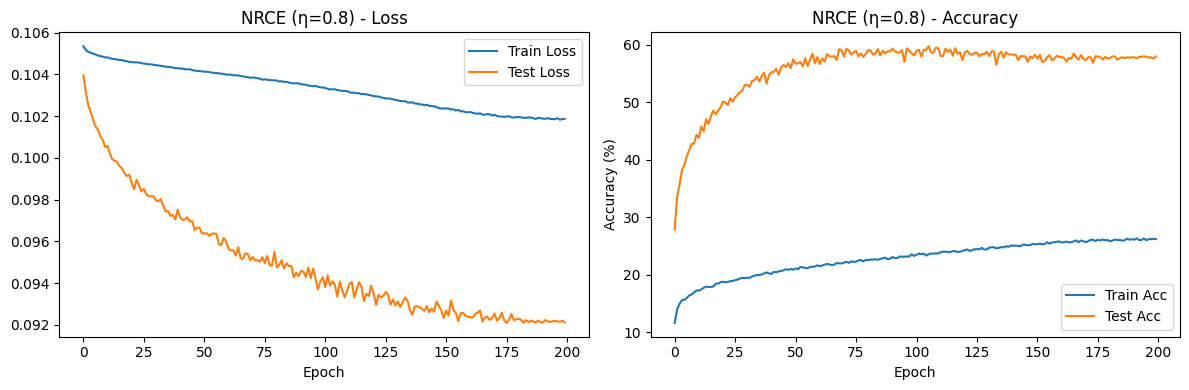


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 37.56% | Test Loss: 0.9974


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 39.87% | Test Loss: 0.9863


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 44.34% | Test Loss: 0.9807


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 45.18% | Test Loss: 0.9627


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 47.03% | Test Loss: 0.9716


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 49.91% | Test Loss: 0.9691


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 49.83% | Test Loss: 0.9501


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 51.19% | Test Loss: 0.9677


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 52.55% | Test Loss: 0.9509


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 53.76% | Test Loss: 0.9476


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 53.08% | Test Loss: 0.9438


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 54.48% | Test Loss: 0.9348


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 54.32% | Test Loss: 0.9265


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 56.82% | Test Loss: 0.9318


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 54.69% | Test Loss: 0.9246


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 55.91% | Test Loss: 0.9308


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.69it/s]


Test Acc: 55.84% | Test Loss: 0.9388


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 57.87% | Test Loss: 0.9368


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.39it/s]


Test Acc: 56.63% | Test Loss: 0.9124


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.69it/s]


Test Acc: 55.52% | Test Loss: 0.9296


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 57.24% | Test Loss: 0.9128


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 56.45% | Test Loss: 0.9281


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 58.76% | Test Loss: 0.9169


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 56.74% | Test Loss: 0.9230


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.74it/s]


Test Acc: 57.70% | Test Loss: 0.9082


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.00it/s]


Test Acc: 59.32% | Test Loss: 0.9039


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.09it/s]


Test Acc: 57.95% | Test Loss: 0.9131


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.90it/s]


Test Acc: 60.56% | Test Loss: 0.9045


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 58.10% | Test Loss: 0.9054


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 56.48% | Test Loss: 0.9024


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 55.38% | Test Loss: 0.9146


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 56.57% | Test Loss: 0.9041


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 52.94% | Test Loss: 0.9205


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 55.06% | Test Loss: 0.9112


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.68it/s]


Test Acc: 57.04% | Test Loss: 0.8872


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 53.32% | Test Loss: 0.9129


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 50.42% | Test Loss: 0.9081


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 54.06% | Test Loss: 0.9187


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 54.11% | Test Loss: 0.8952


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 45.86% | Test Loss: 0.9354


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 51.40% | Test Loss: 0.8937


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.67it/s]


Test Acc: 53.46% | Test Loss: 0.9065


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 53.17% | Test Loss: 0.9054


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 48.67% | Test Loss: 0.9178


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 49.44% | Test Loss: 0.8922


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 49.52% | Test Loss: 0.9092


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 48.73% | Test Loss: 0.9122


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 44.12% | Test Loss: 0.9221


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 46.14% | Test Loss: 0.9157


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 47.97% | Test Loss: 0.9097


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 48.93% | Test Loss: 0.8891


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 42.80% | Test Loss: 0.9230


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 42.43% | Test Loss: 0.9326


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 47.91% | Test Loss: 0.8924


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 43.65% | Test Loss: 0.9162


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 47.63% | Test Loss: 0.8859


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 44.86% | Test Loss: 0.9057


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 44.26% | Test Loss: 0.9113


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 42.84% | Test Loss: 0.9153


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 42.75% | Test Loss: 0.9067


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 45.84% | Test Loss: 0.8966


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 46.77% | Test Loss: 0.8849


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 43.37% | Test Loss: 0.9085


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.90it/s]


Test Acc: 41.61% | Test Loss: 0.9103


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 39.29% | Test Loss: 0.9288


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 41.34% | Test Loss: 0.9157


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.83it/s]


Test Acc: 44.16% | Test Loss: 0.8948


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 42.87% | Test Loss: 0.9066


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 38.16% | Test Loss: 0.9338


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 39.65% | Test Loss: 0.9196


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 38.79% | Test Loss: 0.9226


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 39.65% | Test Loss: 0.9153


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 37.57% | Test Loss: 0.9323


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 38.78% | Test Loss: 0.9224


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 42.09% | Test Loss: 0.8972


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 39.36% | Test Loss: 0.9174


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 39.05% | Test Loss: 0.9242


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 35.83% | Test Loss: 0.9442


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 39.48% | Test Loss: 0.9182


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 39.20% | Test Loss: 0.9184


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 39.43% | Test Loss: 0.9168


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 36.38% | Test Loss: 0.9389


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 36.41% | Test Loss: 0.9408


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 34.99% | Test Loss: 0.9530


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 37.15% | Test Loss: 0.9371


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 36.29% | Test Loss: 0.9416


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 34.84% | Test Loss: 0.9553


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 33.16% | Test Loss: 0.9759


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 33.59% | Test Loss: 0.9710


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 34.67% | Test Loss: 0.9581


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 35.91% | Test Loss: 0.9492


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 34.04% | Test Loss: 0.9657


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 33.61% | Test Loss: 0.9766


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 32.33% | Test Loss: 0.9841


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 33.07% | Test Loss: 0.9770


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 32.32% | Test Loss: 0.9881


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.80it/s]


Test Acc: 31.20% | Test Loss: 0.9983


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 31.99% | Test Loss: 1.0022


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 30.52% | Test Loss: 1.0087


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 30.11% | Test Loss: 1.0169


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 32.97% | Test Loss: 0.9871


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 33.56% | Test Loss: 0.9919


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 34.25% | Test Loss: 0.9926


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 29.48% | Test Loss: 1.0233


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 29.02% | Test Loss: 1.0187


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 31.25% | Test Loss: 1.0186


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 31.56% | Test Loss: 1.0136


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 30.26% | Test Loss: 1.0284


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 29.64% | Test Loss: 1.0336


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 29.20% | Test Loss: 1.0446


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 29.01% | Test Loss: 1.0494


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 27.76% | Test Loss: 1.0667


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 30.08% | Test Loss: 1.0390


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 30.82% | Test Loss: 1.0412


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 29.62% | Test Loss: 1.0608


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 31.93% | Test Loss: 1.0362


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 32.26% | Test Loss: 1.0426


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 31.00% | Test Loss: 1.0442


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 30.65% | Test Loss: 1.0579


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 29.97% | Test Loss: 1.0687


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 29.17% | Test Loss: 1.0770


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 29.77% | Test Loss: 1.0769


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 28.37% | Test Loss: 1.0933


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 28.68% | Test Loss: 1.1026


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 28.50% | Test Loss: 1.1217


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 28.69% | Test Loss: 1.1013


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 29.29% | Test Loss: 1.0993


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.91it/s]


Test Acc: 26.54% | Test Loss: 1.1210


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 28.32% | Test Loss: 1.1150


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.51it/s]


Test Acc: 28.77% | Test Loss: 1.1075


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.29it/s]


Test Acc: 27.74% | Test Loss: 1.1305


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.07it/s]


Test Acc: 27.11% | Test Loss: 1.1303


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.00it/s]


Test Acc: 28.15% | Test Loss: 1.1357


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 28.35% | Test Loss: 1.1399


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 26.63% | Test Loss: 1.1456


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.40it/s]


Test Acc: 28.78% | Test Loss: 1.1295


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.64it/s]


Test Acc: 26.23% | Test Loss: 1.1572


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.83it/s]


Test Acc: 27.46% | Test Loss: 1.1578


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 28.78% | Test Loss: 1.1425


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 28.02% | Test Loss: 1.1629


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.15it/s]


Test Acc: 26.71% | Test Loss: 1.1673


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.43it/s]


Test Acc: 26.83% | Test Loss: 1.1725


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.29it/s]


Test Acc: 27.15% | Test Loss: 1.1863


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.80it/s]


Test Acc: 26.34% | Test Loss: 1.1793


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 28.49% | Test Loss: 1.1614


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.78it/s]


Test Acc: 26.66% | Test Loss: 1.1827


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 27.44% | Test Loss: 1.1898


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 28.38% | Test Loss: 1.1745


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.87it/s]


Test Acc: 26.95% | Test Loss: 1.2026


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.83it/s]


Test Acc: 26.45% | Test Loss: 1.2099


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.55it/s]


Test Acc: 26.36% | Test Loss: 1.2020


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.13it/s]


Test Acc: 27.58% | Test Loss: 1.1956


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.83it/s]


Test Acc: 27.39% | Test Loss: 1.2034


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 26.69% | Test Loss: 1.2142


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.97it/s]


Test Acc: 26.90% | Test Loss: 1.2190


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.05it/s]


Test Acc: 25.45% | Test Loss: 1.2366


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.69it/s]


Test Acc: 27.31% | Test Loss: 1.2192


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.03it/s]


Test Acc: 26.66% | Test Loss: 1.2426


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 26.63% | Test Loss: 1.2411


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.56it/s]


Test Acc: 27.42% | Test Loss: 1.2288


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.45it/s]


Test Acc: 27.46% | Test Loss: 1.2302


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 26.29% | Test Loss: 1.2436


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.73it/s]


Test Acc: 27.11% | Test Loss: 1.2393


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.60it/s]


Test Acc: 26.64% | Test Loss: 1.2425


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.72it/s]


Test Acc: 26.69% | Test Loss: 1.2526


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.15it/s]


Test Acc: 26.88% | Test Loss: 1.2437


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.11it/s]


Test Acc: 26.34% | Test Loss: 1.2529


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.97it/s]


Test Acc: 25.92% | Test Loss: 1.2624


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.25it/s]


Test Acc: 26.42% | Test Loss: 1.2600


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.60it/s]


Test Acc: 26.54% | Test Loss: 1.2630


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.33it/s]


Test Acc: 26.25% | Test Loss: 1.2702


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.82it/s]


Test Acc: 26.17% | Test Loss: 1.2704


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.62it/s]


Test Acc: 26.10% | Test Loss: 1.2674


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.43it/s]


Test Acc: 25.49% | Test Loss: 1.2792


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.69it/s]


Test Acc: 26.46% | Test Loss: 1.2765


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.49it/s]


Test Acc: 26.16% | Test Loss: 1.2741


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.93it/s]


Test Acc: 25.97% | Test Loss: 1.2785


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.65it/s]


Test Acc: 26.03% | Test Loss: 1.2756


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.43it/s]


Test Acc: 26.63% | Test Loss: 1.2688


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 26.12% | Test Loss: 1.2846


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.70it/s]


Test Acc: 25.91% | Test Loss: 1.2868


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.74it/s]


Test Acc: 26.09% | Test Loss: 1.2901


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.10it/s]


Test Acc: 26.15% | Test Loss: 1.2826


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 26.09% | Test Loss: 1.2868


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 26.49% | Test Loss: 1.2818


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.65it/s]


Test Acc: 26.40% | Test Loss: 1.2898


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 25.85% | Test Loss: 1.2906


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.44it/s]


Test Acc: 26.00% | Test Loss: 1.2876


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.37it/s]


Test Acc: 26.29% | Test Loss: 1.2839


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.18it/s]


Test Acc: 25.79% | Test Loss: 1.2899


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 25.91% | Test Loss: 1.2883


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.86it/s]


Test Acc: 26.05% | Test Loss: 1.2870


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.26it/s]


Test Acc: 26.03% | Test Loss: 1.2880


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.07it/s]


Test Acc: 25.98% | Test Loss: 1.2892


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.58it/s]


Test Acc: 26.18% | Test Loss: 1.2857


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.08it/s]


Test Acc: 26.05% | Test Loss: 1.2883


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 26.13% | Test Loss: 1.2915


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 26.09% | Test Loss: 1.2894


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.18it/s]


Test Acc: 26.07% | Test Loss: 1.2894


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.12it/s]


Test Acc: 26.12% | Test Loss: 1.2915


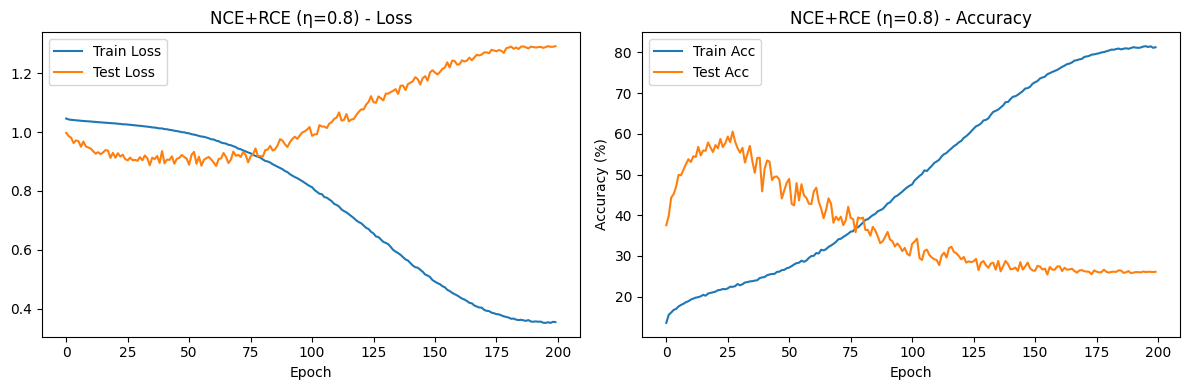

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 104.93it/s]


Test Acc: 35.26% | Test Loss: 0.9990


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.58it/s]


Test Acc: 37.79% | Test Loss: 0.9767


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 103.38it/s]


Test Acc: 45.63% | Test Loss: 0.9806


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 44.26% | Test Loss: 0.9720


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.18it/s]


Test Acc: 48.10% | Test Loss: 0.9623


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 104.44it/s]


Test Acc: 51.04% | Test Loss: 0.9534


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 104.56it/s]


Test Acc: 50.73% | Test Loss: 0.9501


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 103.49it/s]


Test Acc: 51.43% | Test Loss: 0.9455


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.90it/s]


Test Acc: 51.35% | Test Loss: 0.9535


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.43it/s]


Test Acc: 52.80% | Test Loss: 0.9412


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 53.96% | Test Loss: 0.9357


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 53.51% | Test Loss: 0.9300


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 55.36% | Test Loss: 0.9370


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 56.46% | Test Loss: 0.9441


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.68it/s]


Test Acc: 55.10% | Test Loss: 0.9351


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.17it/s]


Test Acc: 57.14% | Test Loss: 0.9288


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.29it/s]


Test Acc: 57.33% | Test Loss: 0.9238


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.21it/s]


Test Acc: 56.92% | Test Loss: 0.9181


Epoch 19/200:  80%|████████████████████▊     | 313/391 [00:02<00:00, 105.07it/s]


KeyboardInterrupt: 

In [3]:

loss_groups = {
    'vanilla': [ 'RCE'],
    'normalized': [  'NRCE'],
    'apl': ['NCE+RCE',  'NFL+RCE', 'MAE+RCE']
    
}

noise_levels = {
    "Symmetric": [0.2,0.4,0.6,0.8],
    "Asymmetric": [0.1, 0.2, 0.3, 0.4]
}

full_results = {}

for noise_type, rates in noise_levels.items():
    print(f"\n=== {noise_type} Noise Experiments ===")
    noise_results = {}

    for rate in rates:
        print(f"\nNoise Rate: {rate}")
        config = Config()
        config.noise_rate = rate
        config.asym = (noise_type == "Asymmetric")

        group_results = {}
        for group_name, loss_types in loss_groups.items():
            print(f"\nTraining {group_name} Losses...")
            loss_results = {}

            for loss in loss_types:
                config.loss_type = loss
                print(f" - {loss}")
                res = train_model(config)
                loss_results[loss] = res
                plot_results(res, f"{loss} (η={rate})")

            group_results[group_name] = loss_results

        noise_results[rate] = group_results

    full_results[noise_type] = noise_results


# Final Comparison Plot
def plot_final_accuracies(results, noise_type):
    plt.figure(figsize=(12,6))
    markers = ['o', 's', '^', 'D', 'v', '>']

    for group_idx, (group_name, loss_types) in enumerate(loss_groups.items()):
        for loss_idx, loss in enumerate(loss_types):
            accuracies = []
            rates = sorted(results.keys())

            for rate in rates:
                acc = results[rate][group_name][loss]['test_acc'][-1]
                accuracies.append(acc)

            plt.plot(rates, accuracies, marker=markers[loss_idx%len(markers)],
                     linestyle='--', label=f"{group_name}: {loss}")

    plt.title(f"Final Test Accuracy ({noise_type} Noise)")
    plt.xlabel("Noise Rate")
    plt.ylabel("Accuracy (%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots
for noise_type in noise_levels:
    plot_final_accuracies(full_results[noise_type], noise_type)
    plot_group_comparisons(full_results[noise_type], noise_type, 'vanilla', 'normalized')
